In [1]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
import pickle

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [7]:
# best_weight_path = './inference/results_GDSC/BF2_test_loss0.0699297_BestValEpo13_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF2_MAE_test_loss0.0702329_BestValEpo60_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF3_BCE_test_loss0.3974576_BestValEpo41_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
# best_weight_path = './inference/results_GDSC/BF2_MAE_test_loss0.0750375_BestValEpo107_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/'
# best_weight_path = './inference/results_GDSC/BF0_BCE_test_loss0.4135855_BestValEpo156_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse_nlayer1/'
best_weight_path = './inference/results_GDSC/BF4_MAE_test_loss0.0715675_BestValEpo155_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue_nlayer1DATrue/'

In [8]:
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
AUC_df_path_numerical = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/DAPL/share/gdsc1+2_ccle_AUC_sorted_binary(median).csv"

omics_files = {
    'Mut': "",
    'Exp': "../data/DAPL/share/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32], # Dr.Chiu:exp[500,200,50] [1000,100,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "",
                                  'Exp': "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
deconfound_EXPembedding = True # False True
DA_Folder = None
if deconfound_EXPembedding is True:
    DA_Folder = "VAE_w10SC"
    omics_files['Exp'] = f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl" #
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True
n_layer=1
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][1] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 1
continuous = True
learning_rate=1e-06

criterion = Custom_LossFunction(loss_type="MAE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
if criterion.loss_type == "BCE":
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Sensitivity","Specificity", "Precision", "F1"] 
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)


drug_encode_dims [7064, 700, 70, 1]
dense_layer_dim None


In [9]:
# 檢查exp和AUC的samples是否一致
if deconfound_EXPembedding is True:
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical.index) & set(exp_df.index))
print(f"matched samples: {len(matched_samples)}")

exp_df samples: 1305 , AUC_df_numerical samples: 966
matched samples: 680


In [10]:
# 讀取omics資料
set_seed(seed)
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict["Exp"] = exp_df.loc[matched_samples]
        print(f"deconfound_EXPembedding is True {deconfound_EXPembedding}")
    else:
        print(f"deconfound_EXPembedding is False {deconfound_EXPembedding}")
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[matched_samples]
        
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
        
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])



deconfound_EXPembedding is True True
Exp tensor shape: torch.Size([680, 32])
Exp num_features 32


In [11]:
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print(drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical= (AUC_df_numerical.loc[matched_samples])
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
print("median_value",median_value)    
if criterion.loss_type == "BCE":
    AUC_df = pd.read_csv(AUC_df_path, sep=',', index_col=0).loc[matched_samples] # binary data
    print("AUC_df",AUC_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)

(393, 9)
AUC_df_numerical (966, 393)
AUC_df_numerical match samples (680, 393)
median_value 0.927835


In [12]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)

if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [13]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
AUC_df = AUC_df.apply(pd.to_numeric, errors='coerce')# Ensure all values are numeric, coercing non-numeric ones to NaN
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  680 393
torch.Size([680, 393])
['C[C@H]1C', '/C', '=C', '\\C(=O)', '[C@H](', '[C@H](C', '/C', '=C', '/C', '2=C(C', '(=CC', '(=C', '2)', 'OC)', 'O)', 'C(=O)O', '1)', 'O)', 'O']


In [14]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (544,)
id_unrepeat_val (68,)
id_unrepeat_test (68,)
id_unrepeat_train_val (612,)
id_test.shape (26724,)


In [15]:
print(id_test[:10])

[1965 1966 1967 1968 1969 1970 1971 1972 1973 1974]


In [16]:
#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #, num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=6000, shuffle=False)

self.num_drugs 393


In [17]:
%%time
# inference

set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)

model.to(device=device)
best_weight = best_weight_path + "BestValWeight.pt"

# load Drug_Cell_SelfAttention to Drug_Cell_SelfAttention.layers.0
def rename_keys_for_layer0(state_dict):
    new_state_dict = {}
    for key in state_dict:
        if key.startswith("Drug_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_SelfAttention.'
            new_key = key.replace("Drug_SelfAttention.", "Drug_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("Drug_Cell_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_Cell_SelfAttention.'
            new_key = key.replace("Drug_Cell_SelfAttention.", "Drug_Cell_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        else:
            new_state_dict[key] = state_dict[key]
    return new_state_dict
best_weight = torch.load(best_weight)

# if n_layer == 1:
#     best_weight = rename_keys_for_layer0(best_weight)
model.load_state_dict(best_weight) # model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 _ ,_,
 eval_outputs_before_final_activation_list, 
 mean_batch_eval_lossWOpenalty)  = evaluation(model, None,None,
                                             criterion, test_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference') # whole_loader




 Drug_SelfAttention is applied 

CPU times: user 2.41 s, sys: 239 ms, total: 2.65 s
Wall time: 4.04 s


In [18]:
print("eval_targets\n",eval_targets[0][:10])
print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list[0][:10])
print("eval_outputs\n",eval_outputs[0][:10])
print("\n mean_batch_eval_lossWOpenalty",mean_batch_eval_lossWOpenalty)
eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value=None)
print(eval_metrics)

eval_targets
 tensor([0.4115, 0.9123, 0.5995, 0.7703, 0.9460, 0.6976, 0.9857, 0.7414, 0.8377,
        0.8634], device='cuda:0')
eval_outputs_before_final_activation_list
 [-0.13069347  2.7100422   1.368913    1.6797445   3.0571728   2.2778537
  3.184907    1.3267988   2.31475     2.1091688 ]
eval_outputs
 tensor([0.4674, 0.9376, 0.7972, 0.8429, 0.9551, 0.9070, 0.9603, 0.7903, 0.9101,
        0.8918], device='cuda:0')

 mean_batch_eval_lossWOpenalty 0.071568884
{'MSE': tensor(0.0149, device='cuda:0'), 'R^2': tensor(0.5808, device='cuda:0')}


Mean Median Mode Test Pearson Omics_DCSA_Model:	0.792154 ± 0.0558	-0.458200	 0.801291	ModeResult(mode=0.83, count=9)

Mean Median Mode Test Spearman Omics_DCSA_Model:	0.787525 ± 0.0629	-1.138787	 0.798561	ModeResult(mode=0.78, count=7)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

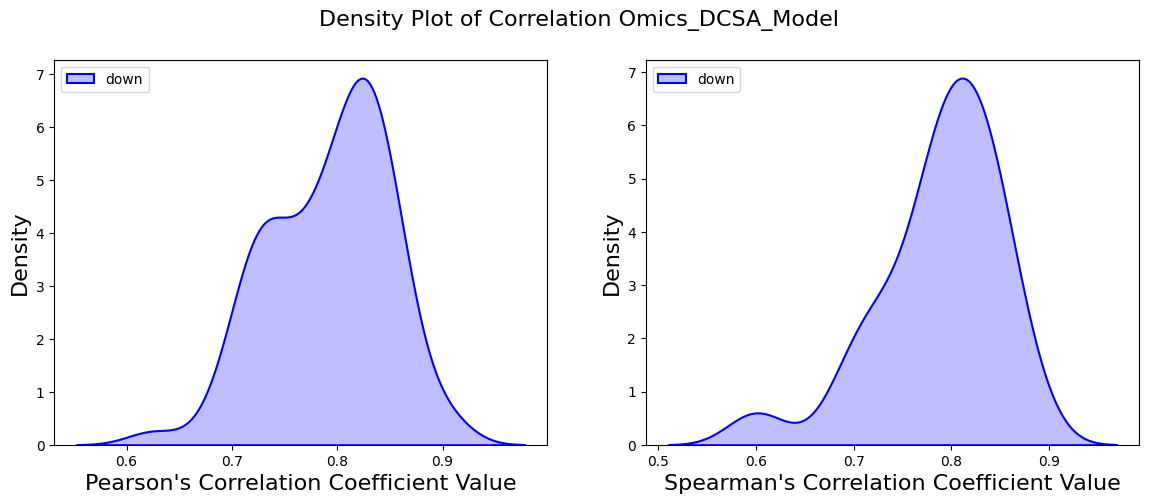

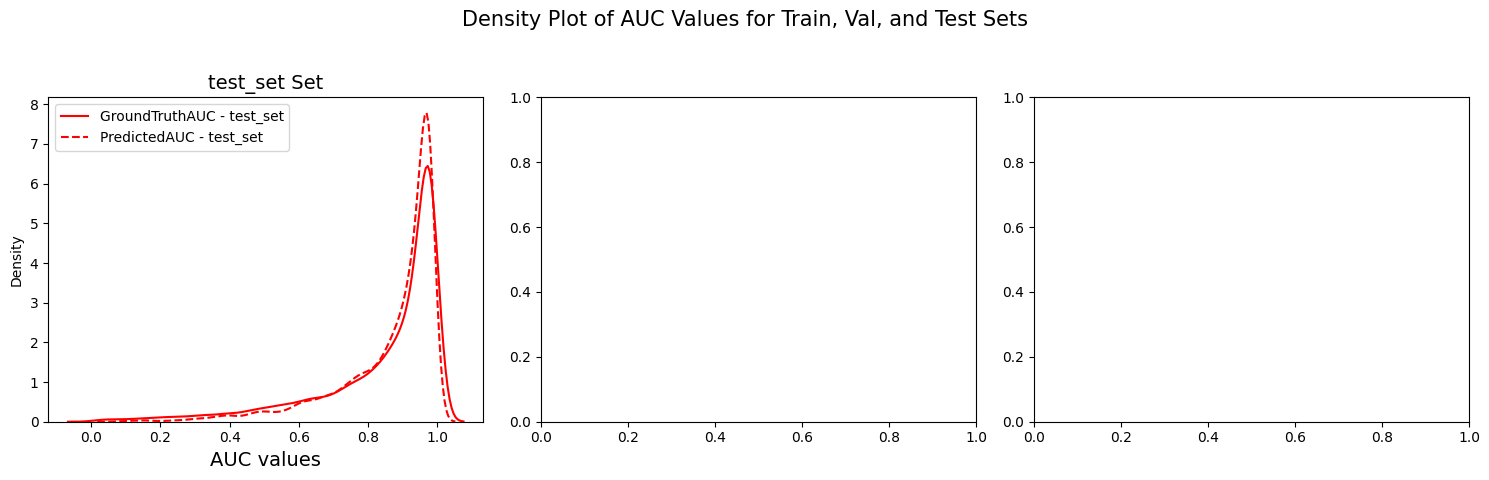

In [19]:
eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,torch.cat(eval_targets),torch.cat(eval_outputs))

#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot
plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

datas = [(eval_targets, eval_outputs, 'test_set', 'red')] #[torch.tensor([], device='cuda:0')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

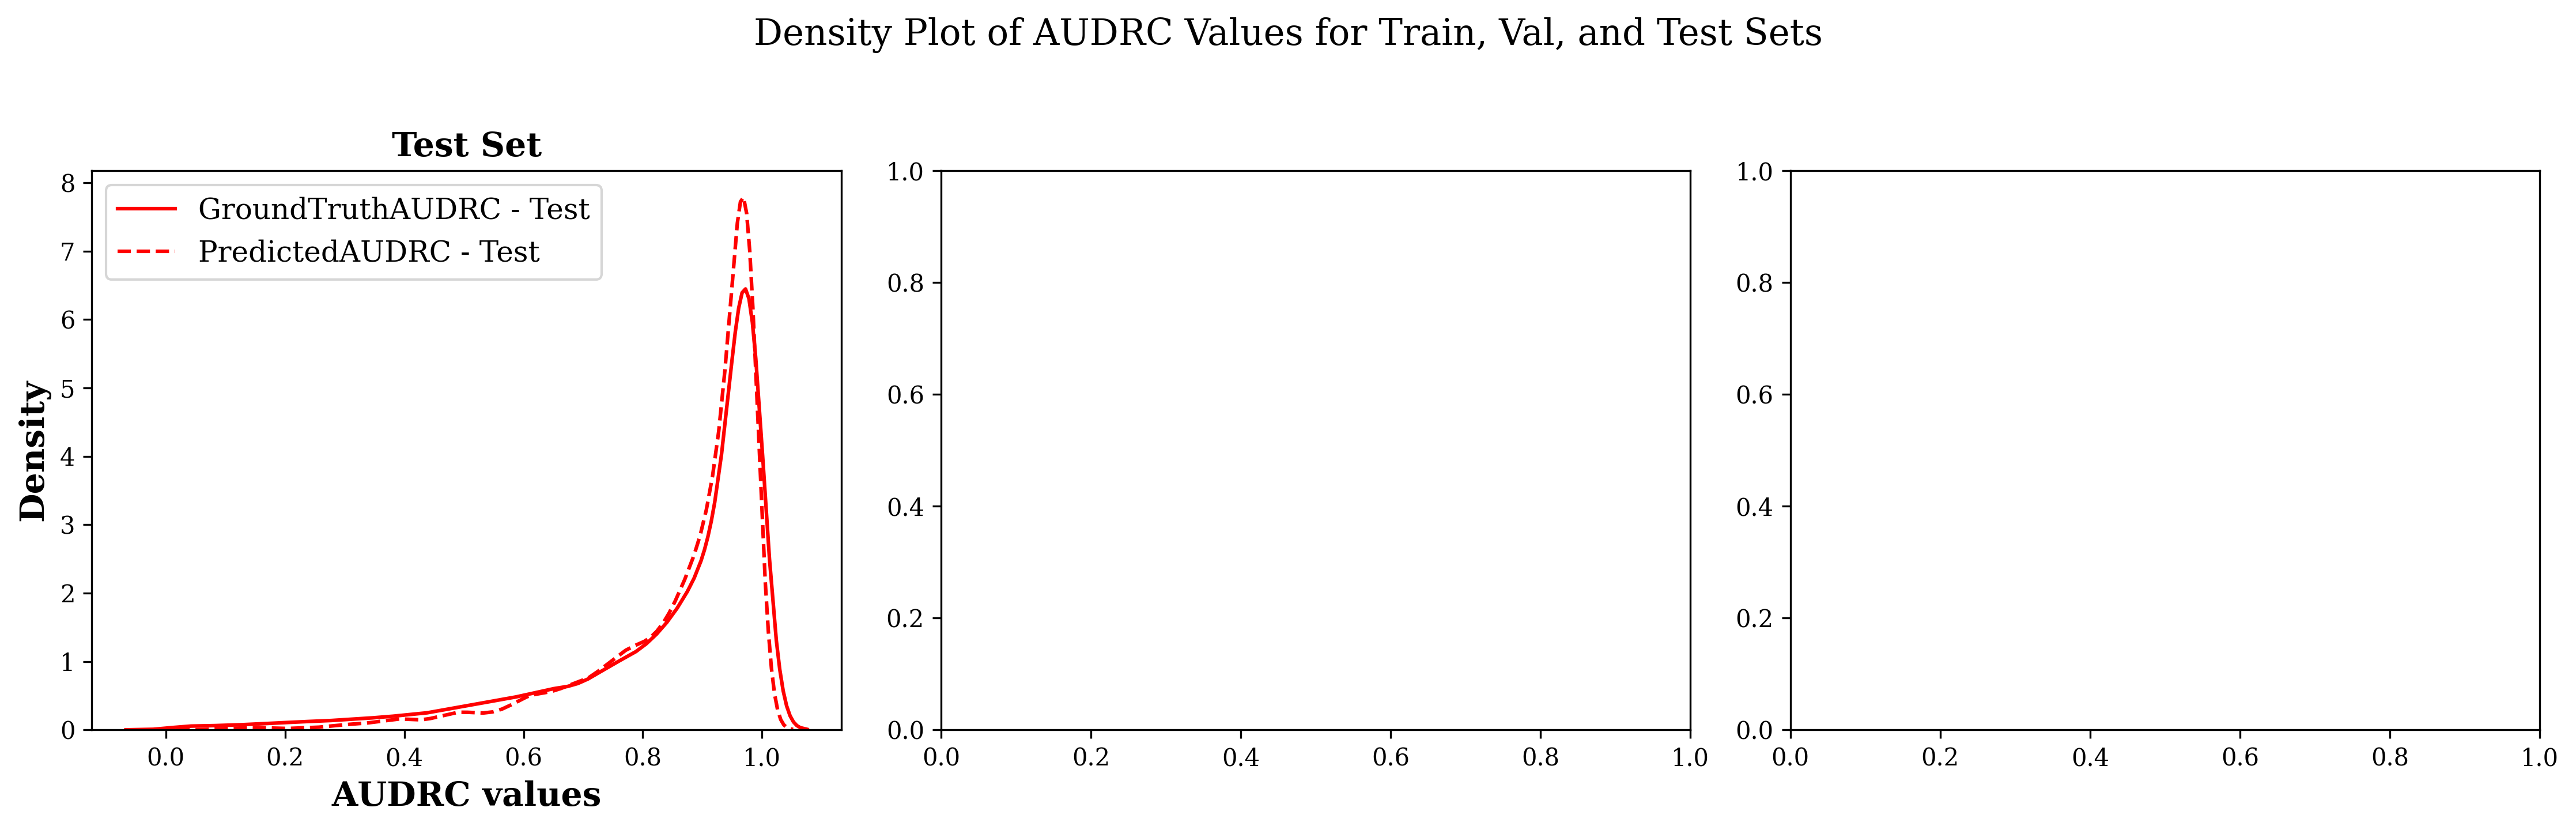

In [33]:

import matplotlib.font_manager as fm
import matplotlib as mpl
datas = [(eval_targets, eval_outputs, 'Test', 'red')] #[torch.tensor([], device='cuda:0')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [26]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(num_ccl, num_drug) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(267240,)
CSV file has been saved.


In [15]:
if criterion.loss_type == "BCE":
    print("mean_batch_eval_lossWOpenalty",mean_batch_eval_lossWOpenalty)
    eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    print(eval_metrics)
    (eval_cm , eval_GT_0_count, eval_GT_1_count, 
        eval_pred_binary_0_count, eval_pred_binary_1_count) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
    print("eval_cm",eval_cm)
    print("eval_GT_0_count",eval_GT_0_count)
    print("eval_GT_1_count",eval_GT_1_count)
    print("eval_pred_binary_0_count",eval_pred_binary_0_count)
    print("eval_pred_binary_1_count",eval_pred_binary_1_count)
    cm_datas = [(eval_cm, 'whole', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None)

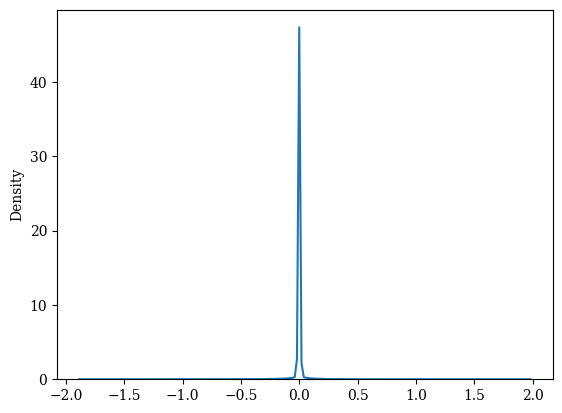

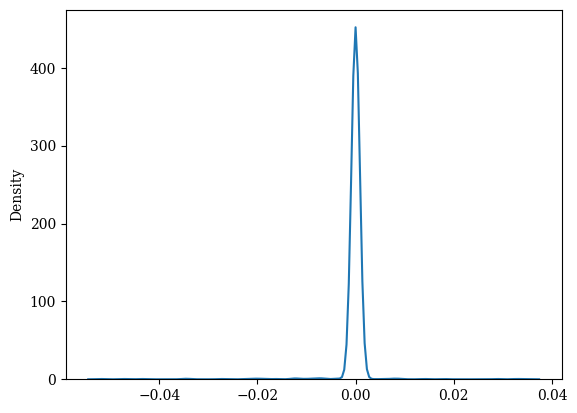

In [ ]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    CCLEexp_df = pd.DataFrame(latent_dict).T
sns.kdeplot(np.concatenate(CCLEexp_df.values).tolist())
plt.show()

In [20]:
# plot deconfounded exp latent embed for each sample
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/temozolomide_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    TCGAexp_df = pd.DataFrame(latent_dict).T
# plot Expression distribution of each TCGA sample
import math
n_rows = len(TCGAexp_df)
n_cols = 5  # 5 subplots per row
n_fig_rows = math.ceil(n_rows / n_cols)
fig, axes = plt.subplots(n_fig_rows, n_cols, figsize=(n_cols * 4, n_fig_rows * 3))
# Flatten axes for easy iteration
axes = axes.flatten()
for i, (index, row) in enumerate(TCGAexp_df.iterrows()):
    axes[i].bar(TCGAexp_df.columns, row.values)
    axes[i].set_title(f"Index: {index}", fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=6)
    axes[i].tick_params(axis='y', labelsize=6)
# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/DAPL/share/pretrain/None/TCGA/temozolomide_latent_results.pkl'

In [39]:
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/PDTC/sb216763_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)
    PDTCexp_df = pd.DataFrame(latent_dict).T 
PDTCexp_df

0         1         2         3         4         5         6   \
HCI001  -0.024758 -0.011422  0.028073 -0.020025 -0.003292  0.004797  0.023973   
HCI002  -0.031509 -0.028072  0.024267 -0.024959 -0.000138  0.003767  0.012679   
HCI005  -0.028609 -0.002172  0.025261 -0.029214 -0.009866  0.005048  0.024317   
HCI008  -0.016492  0.002075  0.040531  0.001571 -0.020362  0.007967  0.022753   
HCI009  -0.013215  0.003415  0.001019 -0.028130  0.002122 -0.007263  0.012923   
HCI010  -0.017144 -0.021525  0.020513 -0.009351 -0.010083  0.005475  0.015739   
HCI011  -0.031921  0.004495  0.030521 -0.030440 -0.003798  0.002630  0.021242   
IC007   -0.028853 -0.015862  0.024301 -0.028927 -0.011463  0.004393  0.020035   
STG139  -0.014809 -0.002374  0.023364 -0.018485 -0.002355  0.006401  0.001705   
STG139M -0.005021 -0.023402  0.017881  0.001199 -0.014131  0.008009  0.008983   
STG143  -0.029836 -0.025415  0.024268 -0.030795  0.002296  0.005410  0.022022   
STG195  -0.030386 -0.025265  0.024251 -0.028394 -0.005911  0.004846  0.025297   
STG201  -0.015177  0.011623  0.034104  0.002310 -0.011886  0.004915  0.013766   
STG282  -0.006294 -0.038550  0.034016 -0.041774 -0.004232  0.015828 -0.001145   
STG316  -0.028970 -0.025005  0.014267 -0.027357 -0.006287 -0.000154  0.022963   
STG335   0.010916 -0.063332 -0.084322 -0.051427 -0.125346  0.054438  0.080803   
VHIO098 -0.010407  0.004349  0.026339 -0.014385 -0.008133  0.006894  0.005414   
VHIO169 -0.031572  0.001888  0.024360 -0.029238 -0.003023  0.004995  0.019364   
VHIO179 -0.030383 -0.007802  0.024308 -0.025691  0.004496  0.004295  0.019868   
VHIO244 -0.007651  0.016460  0.027993 -0.025047  0.007326  0.010740 -0.008345   

               7         8         9   ...        22        23        24  \
HCI001   0.000183 -0.000859  0.005702  ...  0.003949 -0.028702 -0.021771   
HCI002  -0.001250 -0.006025  0.022532  ...  0.006785 -0.044171 -0.024588   
HCI005  -0.003346 -0.003627  0.013810  ...  0.006789 -0.031679 -0.016708   
HCI008   0.003359  0.014931  0.015304  ...  0.002180 -0.031235 -0.020506   
HCI009  -0.022050 -0.021216  0.010174  ...  0.006755 -0.016733 -0.020109   
HCI010   0.008157  0.007301  0.004222  ...  0.005468 -0.030213 -0.018742   
HCI011  -0.003064 -0.006293  0.021392  ...  0.001425 -0.032197 -0.026420   
IC007   -0.002726 -0.005577  0.014675  ...  0.007062 -0.031676 -0.027215   
STG139   0.013817  0.010968  0.002323  ... -0.002531 -0.018562  0.009130   
STG139M  0.016959  0.018128 -0.003079  ...  0.002600 -0.016967 -0.009232   
STG143  -0.006873 -0.003190  0.013678  ...  0.007322 -0.034881 -0.019492   
STG195  -0.003359 -0.008319  0.010723  ...  0.007515 -0.025251 -0.016465   
STG201   0.008172  0.015765  0.002687  ... -0.000445 -0.025456 -0.011817   
STG282   0.045016  0.007678 -0.029238  ... -0.005860 -0.066785 -0.009071   
STG316  -0.006241 -0.012478  0.024482  ...  0.008766 -0.033117 -0.022829   
STG335  -0.052170 -0.058288  0.001956  ...  0.032956 -0.055841 -0.124764   
VHIO098  0.018296  0.022709 -0.001849  ... -0.007342 -0.018518 -0.002674   
VHIO169 -0.004981 -0.003057  0.011429  ...  0.007034 -0.026189 -0.017494   
VHIO179 -0.000506 -0.005354  0.013186  ...  0.007667 -0.034309 -0.015447   
VHIO244  0.023452  0.016549 -0.005150  ... -0.027943 -0.014939  0.022305   

               25        26        27        28        29        30        31  
HCI001   0.000843  0.005196  0.003766 -0.013147 -0.032123  0.005581 -0.023908  
HCI002  -0.005145  0.004168  0.007585 -0.021894 -0.030832  0.003617 -0.035337  
HCI005   0.000049  0.006605  0.014964 -0.020817 -0.032022  0.008416 -0.034310  
HCI008   0.020276  0.020851  0.019262 -0.018166 -0.047978  0.001217 -0.003845  
HCI009   0.008470 -0.000429  0.006831 -0.019822 -0.011074 -0.008247 -0.009246  
HCI010  -0.009481 -0.004039  0.008666 -0.006990 -0.026719  0.006347 -0.023767  
HCI011   0.007159  0.000807  0.009227 -0.019045 -0.030906  0.003787 -0.023510  
IC007   -0.006903  0.005516  0.011974 -0.022633 -0.031045  0.006041 -0.03487

## TCGA inference, PDX inference

VAE_w10SC (5z)-7-oxozeaenol 
Exp latent Enbed : 
Range: 0.28077024
Minimum: -0.13454062
Maximum: 0.14622962
Mean: -0.00267718
Median: -0.00054326
Standard Deviation: 0.02646781
Skewness: 0.02302284
binary data:False
-------------------------------------
PDTCexp (5z)-7-oxozeaenoldata (15, 32)
label_df (5z)-7-oxozeaenoldata (15, 1)
Exp tensor shape: torch.Size([15, 32])
Exp num_features 32
                     PATHWAY_NAME                     synonyms  \
DRUG_NAME                                                        
(5z)-7-oxozeaenol  Other, kinases  5Z-7-Oxozeaenol, LL-Z1640-2   

                     pathway_name targets  pubchem Dataset               name  \
DRUG_NAME                                                                       
(5z)-7-oxozeaenol  Other, kinases    TAK1  9863776   GDSC1  (5z)-7-oxozeaenol   

                                                              SMILES  
DRUG_NAME                                                             
(5z)-7-oxozeaenol  C[C@H

/tmp/ipykernel_2180/4266382451.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='predicted AUDRC', data=df, ax=ax, palette = {'0.0': 'blue', '1.0': 'red'})
/tmp/ipykernel_2180/4266382451.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([    f'sensitive (n={len(sensitive)})', # \nlabel=0


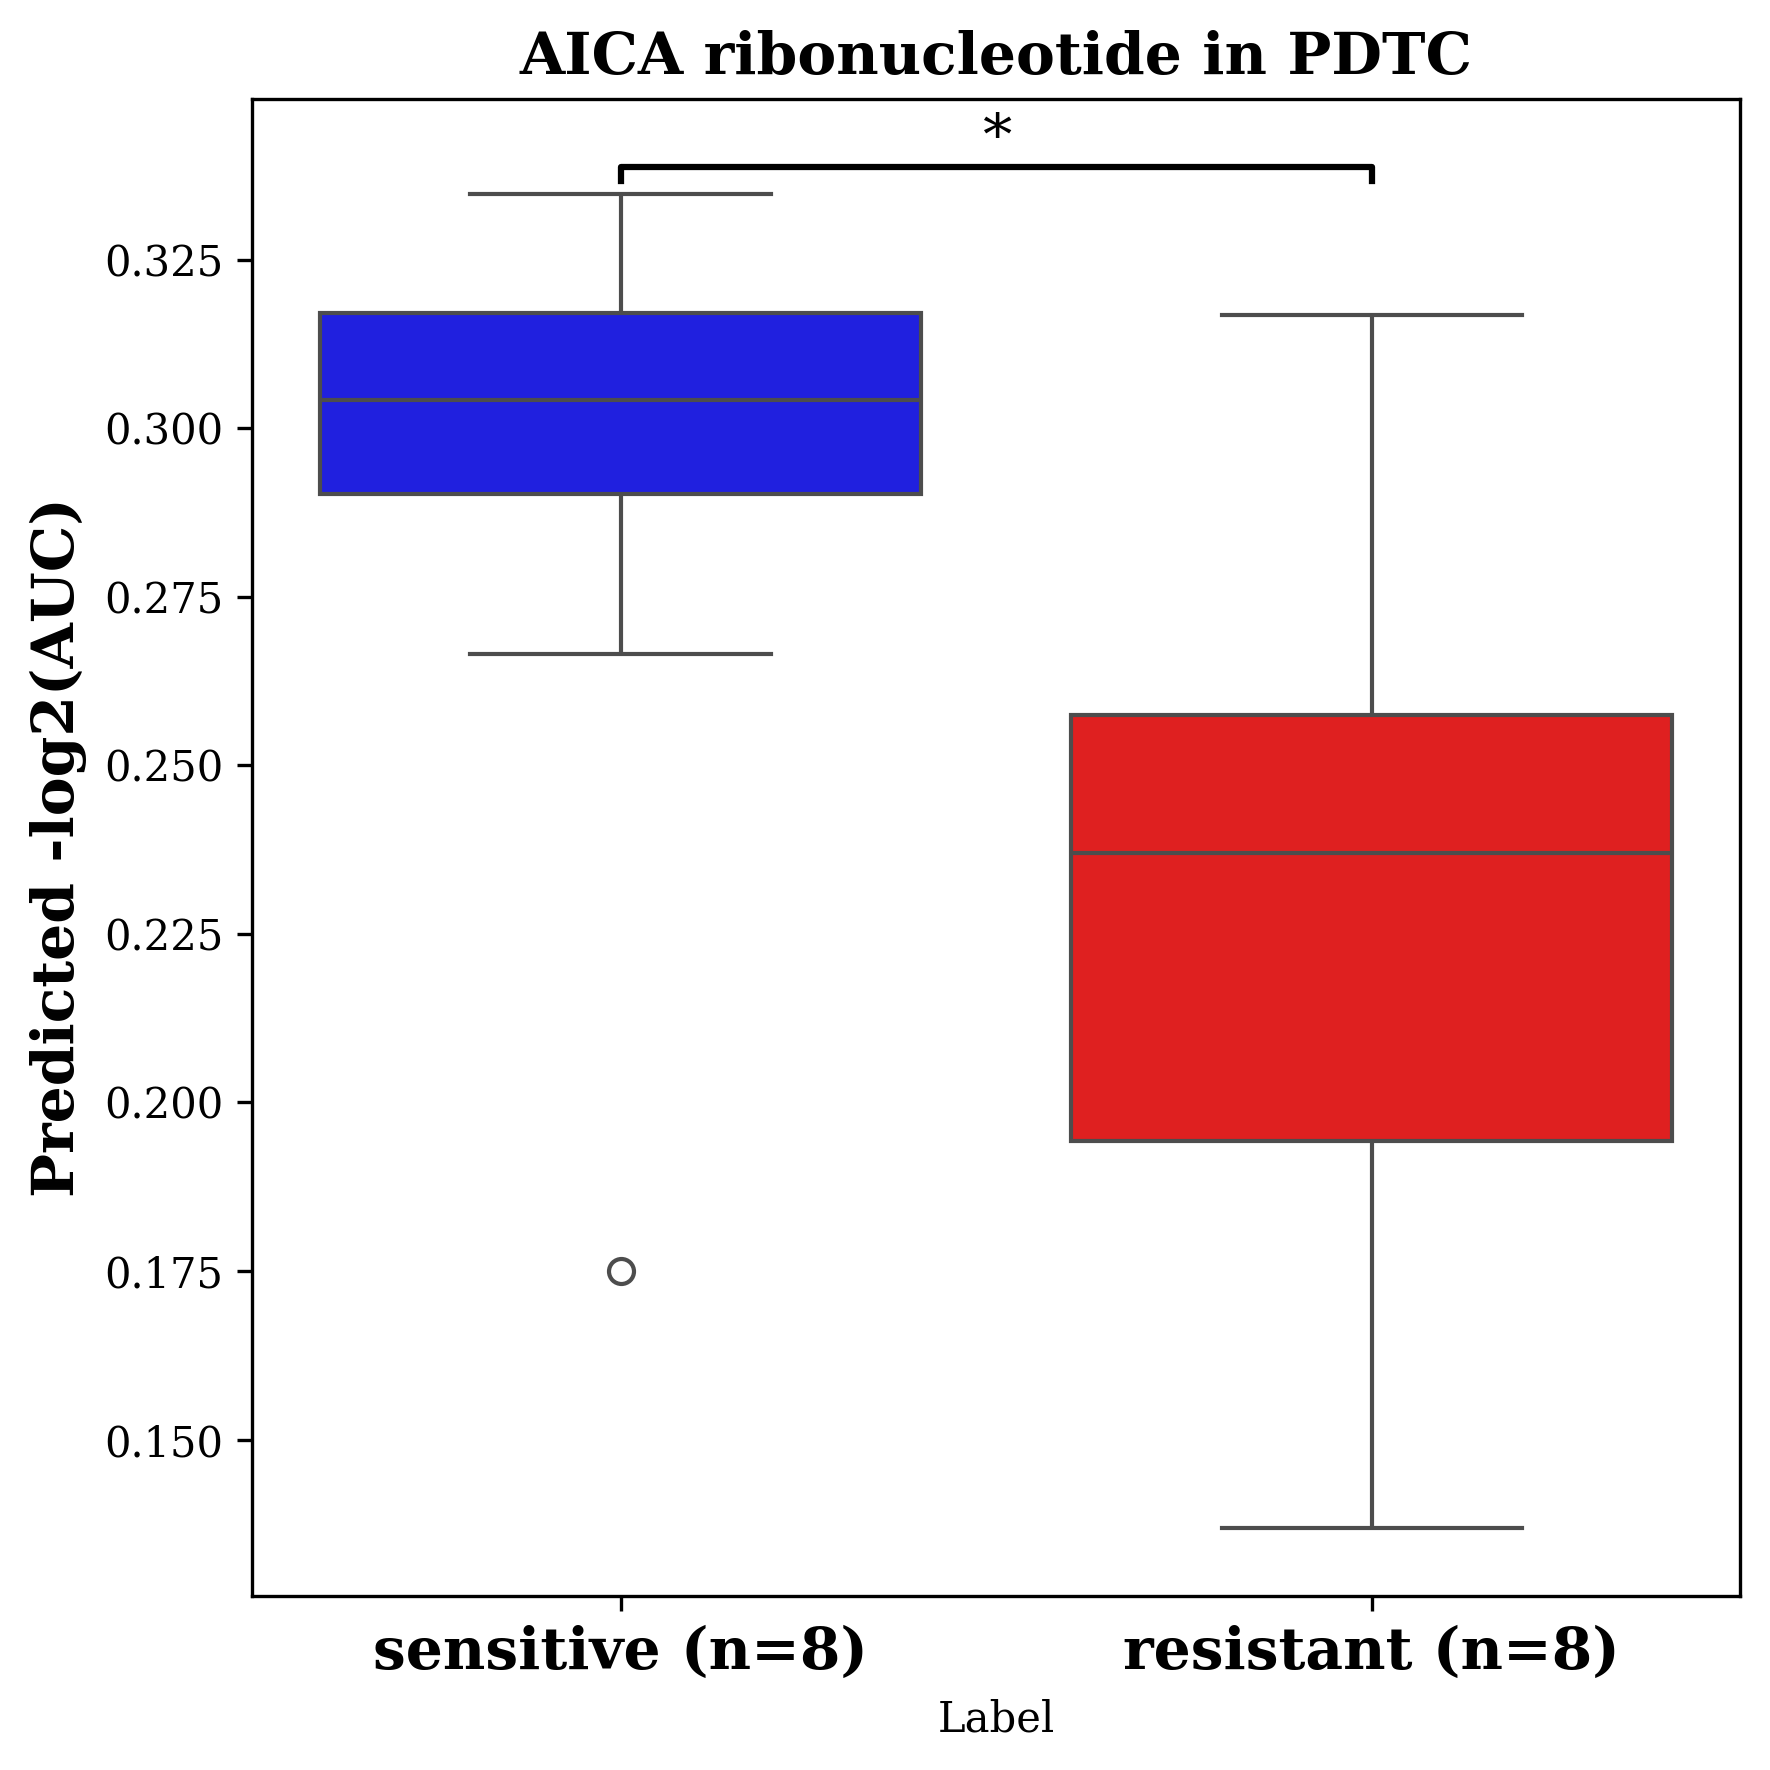

VAE_w10SC axitinib 
Exp latent Enbed : 
Range: 0.29570307
Minimum: -0.12858486
Maximum: 0.16711821
Mean: -0.00228481
Median: -0.00017298
Standard Deviation: 0.02562027
Skewness: 0.68545603
binary data:False
-------------------------------------
PDTCexp axitinibdata (20, 32)
label_df axitinibdata (20, 1)
Exp tensor shape: torch.Size([20, 32])
Exp num_features 32
            PATHWAY_NAME          synonyms   pathway_name            targets  \
DRUG_NAME                                                                      
axitinib   RTK signaling  AG-13736, Inlyta  RTK signaling  PDGFR, KIT, VEGFR   

           pubchem Dataset      name  \
DRUG_NAME                              
axitinib   6450551   GDSC2  axitinib   

                                                      SMILES  
DRUG_NAME                                                     
axitinib   CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)/C=C/C...  
drug_smiles DRUG_NAME
axitinib    CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)/C=C/C...
N

In [ ]:
import torchmetrics
from scipy.stats import ttest_ind
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"] #["cisplatin"]#
# drug_list=[
# "5zdata", "aicdata", "axidata", "az628data", "azd6482data", "azd7762data", "azd8055data",
# "bi2536data", "bms536data", "bms754data", "bosdata", "bx795data", "campdata", "chirdata",
# "dapdata", "embdata", "enzdata", "gefdata", "gsk19data", "gsk26data", "gw44data", "jnkdata",
# "jq1data", "kudata", "lesdata", "mkdata", "motdata", "nildata", "nutdata", "obadata",
# "pac1data", "paldata", "pd03data", "pd17data", "pf47data", "pf56data", "picdata", "ppldata",
# "rodata", "rucdata", "sbdata", "serddata", "sldata", "soradata", "tamdata", "twdata",
# "vordata", "weedata", "ykdata", "zmdata"
# ]
drug_list = [
    "(5z)-7-oxozeaenol", "aica ribonucleotide", "axitinib", "az628", "azd6482", "azd7762", "azd8055",
    "bi-2536", "bms-536924", "bms-754807", "bosutinib", "bx795", "camptothecin", "chir-99021",
    "daporinad", "embelin", "enzastaurin", "gefitinib", "gsk1904529a", "gsk269962a", "gw441756",
    "jnk inhibitor viii", "jq1", "ku-55933", "lestaurtinib", "mk-2206", "motesanib", "nilotinib",
    "nu7441", "obatoclax mesylate", "pac-1", "palbociclib", "pd0325901", "pd173074", "pf-4708671",
    "pf-562271", "pictilisib", "plx-4720", "ro-3306", "rucaparib", "sb216763", "serdemetan",
    "sl0101", "sorafenib", "tamoxifen", "tw 37", "vorinostat", "wee1 inhibitor", "yk-4-279", "zm447439"
]
cohort = "PDTC"  # TCGA
drugs_metrics={}
response_class_pvalue={}
for drug_name in drug_list:
    if deconfound_EXPembedding is True:
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            TCGAexp_df = pd.DataFrame(latent_dict).T # 32
            get_data_value_range(TCGAexp_df.values,f"{DA_Folder} {drug_name} \nExp latent Enbed")
    else:
        # TCGAexp_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtcdata.csv", sep=',', index_col=0)
        TCGAexp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data.csv", sep=',', index_col=0) #1426
    # label_df = pd.read_csv(f"../data/DAPL/share/PDTC_indiv_fromDAPL/{drug_name}/pdtclabel.csv", sep=',', index_col=0)
    label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label.csv", sep=',', index_col=0)
    label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match predicted output. after that 0: sensitive, 1: resistant
    print(f"{cohort}exp {drug_name}data",TCGAexp_df.shape)
    print(f"label_df {drug_name}data",label_df.shape)
    for omic_type in include_omics:
        if deconfound_EXPembedding is True:
            omics_data_dict["Exp"] = TCGAexp_df
        else:
            if omic_type == "Exp":
                scaler = StandardScaler() 
                omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
        omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
        omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

        print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
        print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
    drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
    # get specific drug and ccl
    drug_df= drug_df[drug_df['name'] == drug_name]
    print(drug_df)
    if ESPF is True:
        drug_smiles =drug_df["SMILES"] # 
        print("drug_smiles",drug_smiles)
        drug_names =drug_df.index
        # 挑出重複的SMILES
        duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
        #ESPF
        vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
        sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
        # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
        drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
        drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
    else:
        drug_encode = drug_df["MACCS166bits"]
        drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
        print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
        # Convert your data to tensors if they're in numpy
        drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
    #--------------------------------------------------------------------------------------------------------------------------
    num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
    num_drug = drug_encode.shape[0]
    print("num_ccl,num_drug: ",num_ccl,num_drug)

    response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device)
    # print(omics_data_tensor_dict)
    print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
    print(response_matrix_tensor.shape)
    # print(drug_encode.values)

    if 'weighted' in criterion.loss_type :    
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)   
    else:
        weighted_threshold = None
        few_weight = None
        more_weight = None
    print("weighted_threshold:",weighted_threshold)

    set_seed(seed)
    dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
    onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
    (eval_targets, eval_outputs,predAUCwithUnknownGT,
    AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
    eval_outputs_before_final_activation_list, 
    mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                weighted_threshold, few_weight, more_weight, 
                                                outputcontrol='inference')
    
        # Calculate classification metrics                                            
    drugs_metrics[drug_name] = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    
    print("eval_targets\n",eval_targets)
    print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list)
    print("eval_outputs\n",eval_outputs)

    plt.rcParams["font.family"] = "serif"
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    df = pd.DataFrame({'predicted AUDRC': -np.log2(torch.cat(eval_outputs).cpu().numpy()),
                        'Label': torch.cat(eval_targets).cpu().numpy()})
    # Perform t-test between the two groups
    sensitive = df[df['Label'] == 0]['predicted AUDRC']
    resistant = df[df['Label'] == 1]['predicted AUDRC']
    t_stat, p_val = ttest_ind(sensitive, resistant)
    print(p_val)
    if p_val<=0.05:
        def p_to_star(p):
            if p < 0.0001:
                return '***'
            elif p < 0.01:
                return '**'
            elif p < 0.05:
                return '*'
            else:
                return 'n.s.'
        # plot
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.boxplot(x='Label', y='predicted AUDRC', data=df, ax=ax, palette = {'0.0': 'blue', '1.0': 'red'})
        # Title and p-value annotation
        # ax.set_title(f"{drug_name} in PDTC", fontsize=14, fontweight="bold")
        ax.set_title(f"AICA ribonucleotide in PDTC", fontsize=14, fontweight="bold")
        # p_text = f"p = {p_val:.4f}"
        p_text = p_to_star(p_val)
        x1, x2 = 0, 1
        y, h = max(df['predicted AUDRC']) + 0.002, 0.002
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
        ax.text((x1+x2) / 2, y+h, p_text, ha='center', va='bottom', fontsize=14)#, color='red'
        # Axis labels
        ax.set_xticklabels([    f'sensitive (n={len(sensitive)})', # \nlabel=0
                                f'resistant (n={len(resistant)})'], fontsize=14, fontweight="bold") #\nlabel=1
        # ax.set_xlabel("Label", fontsize=14, fontweight="bold")
        ax.set_ylabel("Predicted -log2(AUC)", fontsize=14, fontweight="bold" )
        plt.tight_layout()
        plt.show()
    
    response_class_pvalue[drug_name]= p_val
    if criterion.loss_type == "BCE":
        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
        drugs_metrics[drug_name]["CM"] = test_cm
        # # plot confusion matrix
        cm_datas = [(test_cm, cohort, 'Blues')]
        Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None,drug=drug_name)
    else:
        device=torch.cat(eval_targets).device
        median_tensor = torch.tensor(median_value, dtype=torch.float32, device=device)
        GT = (torch.cat(eval_targets) > median_tensor).int()
        auroc = torchmetrics.classification.AUROC(task="binary").to(device)(torch.cat(eval_outputs),GT)  # Use raw scores
        auprc = torchmetrics.classification.AveragePrecision(task="binary").to(device)(torch.cat(eval_outputs),GT) # Use raw scores
        drugs_metrics[drug_name]["AUROC"] = auroc.item()
        drugs_metrics[drug_name]["AUPRC"] = auprc.item()
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty
        
if criterion.loss_type == "BCE":
    for drug, metrics in drugs_metrics.items():
        print(drug)
        print(f"  test {criterion.loss_type}loss: {mean_batch_eval_loss_WO_penalty:.4f}")
        for key in metrics_type_set:
            print(f"  '{key}': {metrics[key].item():.4f}")
        print()
else:
    for drug, metrics in drugs_metrics.items():
            print(drug)
            for key in ["AUROC", "AUPRC", criterion.loss_type]:
                print(f"  '{key}': {metrics[key]:.4f}")
            print()

for DrugName, pvalue in response_class_pvalue.items():
    print(f"{DrugName}: {pvalue}")
for DrugName, pvalue in response_class_pvalue.items():
    if pvalue <=0.05:
        print("pvalue <=0.05")
        print(DrugName)

## TCGA mutation boxplot

In [ ]:
drug_ID = 176870 # 5-flu:3385, pubchem ID 84691 Trametinib:11707110, Oxaliplatin:5310940, Gefitinib:123631, Erlotinib:176870
sample_type = "LUAD" # SKCM LUAD
drug_name = 'Erlotinib' # 5-fluorouracil Cisplatin
drug_name_short = 'Erlotinib'# Fluorouracil Cisplatin
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "EGFR" # TP53 BRAF KRAS EGFR
MutType = "Exon19 deletion/L858R"  #V600E    Exon19 deletion/L858R

In [42]:
sampletype_Genedf = pd.read_csv(f"../data/DAPL/share/{sample_type}_{inhibit_Gene}.tsv", sep='\t', index_col=0)
sampletype_Genedf

Sample ID    Patient ID  Altered  \
Study ID                                                               
luad_tcga_pan_can_atlas_2018  TCGA-71-8520-01  TCGA-71-8520        1   
luad_tcga_pan_can_atlas_2018  TCGA-69-7765-01  TCGA-69-7765        1   
luad_tcga_pan_can_atlas_2018  TCGA-69-7760-01  TCGA-69-7760        1   
luad_tcga_pan_can_atlas_2018  TCGA-67-6217-01  TCGA-67-6217        1   
luad_tcga_pan_can_atlas_2018  TCGA-67-3772-01  TCGA-67-3772        1   
...                                       ...           ...      ...   
luad_tcga_pan_can_atlas_2018  TCGA-75-6206-01  TCGA-75-6206        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-6205-01  TCGA-75-6205        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-6203-01  TCGA-75-6203        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-5147-01  TCGA-75-5147        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-5146-01  TCGA-75-5146        0   

                                                       EGFR  \
Study ID                                                      
luad_tcga_pan_can_atlas_2018  L62R (driver), L858R (driver)   
luad_tcga_pan_can_atlas_2018                          Q486*   
luad_tcga_pan_can_atlas_2018      E709_T710delinsD (driver)   
luad_tcga_pan_can_atlas_2018                 L858R (driver)   
luad_tcga_pan_can_atlas_2018                 L858R (driver)   
...                                                     ...   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   

                                                  EGFR: MUT  
Study ID                                                     
luad_tcga_pan_can_atlas_2018  L62R (driver), L858R (driver)  
luad_tcga_pan_can_atlas_2018                          Q486*  
luad_tcga_pan_can_atlas_2018      E709_T710delinsD (driver)  
luad_tcga_pan_can_atlas_2018                 L858R (driver)  
luad_tcga_pan_can_atlas_2018                 L858R (driver)  
...                                                     ...  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  

[566 rows x 5 columns]

In [43]:
if DA_Folder:
    with open(f"../data/DAPL/share/pretrain/{DA_Folder}/tcga_latent_results.pkl", 'rb') as f: #32dim
        latent_dict = pickle.load(f)
        TCGAexp_df = pd.DataFrame(latent_dict).T
        print(TCGAexp_df.shape)#(9808, 32)
    match_sample = list(set(sampletype_Genedf["Sample ID"]) & set(TCGAexp_df.index))
    print(len(match_sample))
else:
    TCGAexp_df = "tcga Exp 1426genes.csv"
    print(TCGAexp_df.shape)#(9808, 32)
    match_sample = list(set(sampletype_Genedf["Sample ID"]) & set(TCGAexp_df.index))
    len(match_sample)

(9808, 32)
508


In [44]:
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict[omic_type] = TCGAexp_df.loc[match_sample]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[match_sample]
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
    
# get specific drug and ccl
drug_df= pd.read_csv("../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv", sep=',', index_col=0)
# get specific drug and ccl
drug_df= drug_df[drug_df['pubchem'] == drug_ID]
print(drug_df)

Exp tensor shape: torch.Size([508, 32])
Exp num_features 32
             PATHWAY_NAME                                           synonyms  \
DRUG_NAME                                                                      
erlotinib  EGFR signaling  Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...   

             pathway_name targets  pubchem Dataset       name  \
DRUG_NAME                                                       
erlotinib  EGFR signaling    EGFR   176870   GDSC2  erlotinib   

                                                      SMILES  
DRUG_NAME                                                     
erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...  


In [45]:
# list(omics_data_tensor_dict.values())
omics_data_tensor_dict["Exp"].shape[0]

508

In [46]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = omics_data_tensor_dict["Exp"].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.zeros(num_ccl, 1, dtype=torch.float32).to(device)
print(omics_data_tensor_dict['Exp'])
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values)

num_ccl,num_drug:  508 1
tensor([[0.0267, 0.0120, 0.0213,  ..., 0.0594, 0.0003, 0.0223],
        [0.0050, 0.0099, 0.0221,  ..., 0.0388, 0.0077, 0.0051],
        [0.0035, 0.0096, 0.0223,  ..., 0.0219, 0.0074, 0.0041],
        ...,
        [0.0218, 0.0163, 0.0041,  ..., 0.0415, 0.0048, 0.0130],
        [0.0064, 0.0118, 0.0223,  ..., 0.0155, 0.0131, 0.0068],
        [0.0086, 0.0145, 0.0227,  ..., 0.0158, 0.0048, 0.0075]],
       device='cuda:0')
torch.Size([1, 2, 50])
torch.Size([508, 1])
[(array([ 867,  422,  248,   85,  122,  150,  434,  743,  189,   99,  117,
        1855,  282,  150,  268,  424,   37,  119,   89,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0,

In [47]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [48]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _) = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')
print(np.concatenate(predAUCwithUnknownGT).shape)
print(torch.cat(eval_outputs).shape)

self.num_drugs 1
(508,)
torch.Size([508])


In [66]:
predAUC_df = pd.DataFrame({
    "Sample ID": omics_data_dict[omic_type].index,
    "Predicted AUC": torch.cat(eval_outputs).cpu().numpy()
})
predAUC_df

Sample ID  Predicted AUC
0    TCGA-86-A4D0-01       0.962189
1    TCGA-05-4417-01       0.959913
2    TCGA-49-AAQV-01       0.964440
3    TCGA-75-7031-01       0.962807
4    TCGA-55-8089-01       0.963755
..               ...            ...
503  TCGA-55-A4DF-01       0.964873
504  TCGA-49-4488-01       0.964198
505  TCGA-55-7728-01       0.960367
506  TCGA-80-5608-01       0.961991
507  TCGA-78-7153-01       0.963575

[508 rows x 2 columns]

In [67]:
sampletype_Genedf=sampletype_Genedf[sampletype_Genedf["Sample ID"].isin(match_sample)]
sampletype_Genedf

Sample ID    Patient ID  Altered  \
Study ID                                                               
luad_tcga_pan_can_atlas_2018  TCGA-71-8520-01  TCGA-71-8520        1   
luad_tcga_pan_can_atlas_2018  TCGA-69-7765-01  TCGA-69-7765        1   
luad_tcga_pan_can_atlas_2018  TCGA-69-7760-01  TCGA-69-7760        1   
luad_tcga_pan_can_atlas_2018  TCGA-67-6217-01  TCGA-67-6217        1   
luad_tcga_pan_can_atlas_2018  TCGA-67-3772-01  TCGA-67-3772        1   
...                                       ...           ...      ...   
luad_tcga_pan_can_atlas_2018  TCGA-75-6206-01  TCGA-75-6206        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-6205-01  TCGA-75-6205        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-6203-01  TCGA-75-6203        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-5147-01  TCGA-75-5147        0   
luad_tcga_pan_can_atlas_2018  TCGA-75-5146-01  TCGA-75-5146        0   

                                                       EGFR  \
Study ID                                                      
luad_tcga_pan_can_atlas_2018  L62R (driver), L858R (driver)   
luad_tcga_pan_can_atlas_2018                          Q486*   
luad_tcga_pan_can_atlas_2018      E709_T710delinsD (driver)   
luad_tcga_pan_can_atlas_2018                 L858R (driver)   
luad_tcga_pan_can_atlas_2018                 L858R (driver)   
...                                                     ...   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   
luad_tcga_pan_can_atlas_2018                  no alteration   

                                                  EGFR: MUT  
Study ID                                                     
luad_tcga_pan_can_atlas_2018  L62R (driver), L858R (driver)  
luad_tcga_pan_can_atlas_2018                          Q486*  
luad_tcga_pan_can_atlas_2018      E709_T710delinsD (driver)  
luad_tcga_pan_can_atlas_2018                 L858R (driver)  
luad_tcga_pan_can_atlas_2018                 L858R (driver)  
...                                                     ...  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  
luad_tcga_pan_can_atlas_2018                  no alteration  

[508 rows x 5 columns]

In [68]:
# Merge the two dataframes on "Sample ID"
merged_df = pd.merge(predAUC_df, sampletype_Genedf[["Sample ID", f"{inhibit_Gene}"]], on="Sample ID", how="inner")
merged_df

Sample ID  Predicted AUC           EGFR
0    TCGA-86-A4D0-01       0.962189  no alteration
1    TCGA-05-4417-01       0.959913  no alteration
2    TCGA-49-AAQV-01       0.964440  no alteration
3    TCGA-75-7031-01       0.962807  no alteration
4    TCGA-55-8089-01       0.963755  no alteration
..               ...            ...            ...
503  TCGA-55-A4DF-01       0.964873  no alteration
504  TCGA-49-4488-01       0.964198  no alteration
505  TCGA-55-7728-01       0.960367  no alteration
506  TCGA-80-5608-01       0.961991  no alteration
507  TCGA-78-7153-01       0.963575  no alteration

[508 rows x 3 columns]

In [69]:
import re
def is_EGFRexon19_del(mutation):
    numbers = re.findall(r'\d+', mutation)
    for num in numbers:
        if 729 <= int(num) <= 760:
            return 'exon19 deletion'
    return mutation

# Apply the function to a new column
merged_df[f"{inhibit_Gene}"] = merged_df[f"{inhibit_Gene}"].apply(is_EGFRexon19_del)

# Display result
merged_df


Sample ID  Predicted AUC           EGFR
0    TCGA-86-A4D0-01       0.962189  no alteration
1    TCGA-05-4417-01       0.959913  no alteration
2    TCGA-49-AAQV-01       0.964440  no alteration
3    TCGA-75-7031-01       0.962807  no alteration
4    TCGA-55-8089-01       0.963755  no alteration
..               ...            ...            ...
503  TCGA-55-A4DF-01       0.964873  no alteration
504  TCGA-49-4488-01       0.964198  no alteration
505  TCGA-55-7728-01       0.960367  no alteration
506  TCGA-80-5608-01       0.961991  no alteration
507  TCGA-78-7153-01       0.963575  no alteration

[508 rows x 3 columns]

In [70]:
def process(mutation):
    if "exon19 deletion" in mutation or "L858R" in mutation:
        return "Exon19 deletion/L858R (driver)"
    elif "no alteration" in mutation:
        return "no alteration"
    else:
        return "Other mutations"

merged_df[f"{inhibit_Gene} Status"] = merged_df[f"{inhibit_Gene}"].apply(process)
merged_df


Sample ID  Predicted AUC           EGFR    EGFR Status
0    TCGA-86-A4D0-01       0.962189  no alteration  no alteration
1    TCGA-05-4417-01       0.959913  no alteration  no alteration
2    TCGA-49-AAQV-01       0.964440  no alteration  no alteration
3    TCGA-75-7031-01       0.962807  no alteration  no alteration
4    TCGA-55-8089-01       0.963755  no alteration  no alteration
..               ...            ...            ...            ...
503  TCGA-55-A4DF-01       0.964873  no alteration  no alteration
504  TCGA-49-4488-01       0.964198  no alteration  no alteration
505  TCGA-55-7728-01       0.960367  no alteration  no alteration
506  TCGA-80-5608-01       0.961991  no alteration  no alteration
507  TCGA-78-7153-01       0.963575  no alteration  no alteration

[508 rows x 4 columns]

In [ ]:
# Create a new column that classifies based on whether 'V600E (driver)' is in the BRAF column
merged_df[f"{inhibit_Gene} Status"] = merged_df[f"{inhibit_Gene}"].apply(
    lambda x: f"{MutType} (driver)" if pd.notna(x) and f"{MutType} (driver)" in x else "no alteration"
)

Sample ID  Predicted AUC            BRAF     BRAF Status
0    TCGA-FS-A1ZA-06       1.070154   no alteration   no alteration
1    TCGA-EB-A3HV-01       1.117589  V600E (driver)  V600E (driver)
2    TCGA-EE-A3JB-06       1.001953  V600E (driver)  V600E (driver)
3    TCGA-FR-A3R1-01       1.037298   no alteration   no alteration
4    TCGA-FW-A3TU-06       1.095232   no alteration   no alteration
..               ...            ...             ...             ...
431  TCGA-D3-A3BZ-06       0.871129   no alteration   no alteration
432  TCGA-ER-A19T-01       0.834939   no alteration   no alteration
433  TCGA-EE-A2GK-06       0.291556   no alteration   no alteration
434  TCGA-D9-A4Z6-06       0.877564           R726C   no alteration
435  TCGA-EE-A29E-06       0.749128  V600K (driver)   no alteration

[436 rows x 4 columns]

In [73]:
merged_df["Predicted AUC"] = -np.log2(merged_df["Predicted AUC"])
merged_df

Sample ID  Predicted AUC           EGFR    EGFR Status
0    TCGA-86-A4D0-01       0.055607  no alteration  no alteration
1    TCGA-05-4417-01       0.059024  no alteration  no alteration
2    TCGA-49-AAQV-01       0.052237  no alteration  no alteration
3    TCGA-75-7031-01       0.054681  no alteration  no alteration
4    TCGA-55-8089-01       0.053262  no alteration  no alteration
..               ...            ...            ...            ...
503  TCGA-55-A4DF-01       0.051588  no alteration  no alteration
504  TCGA-49-4488-01       0.052599  no alteration  no alteration
505  TCGA-55-7728-01       0.058342  no alteration  no alteration
506  TCGA-80-5608-01       0.055904  no alteration  no alteration
507  TCGA-78-7153-01       0.053531  no alteration  no alteration

[508 rows x 4 columns]

/tmp/ipykernel_93525/1341768835.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x=f"{inhibit_Gene} Status", y="Predicted AUC", palette=custom_palette,order =custom_order)


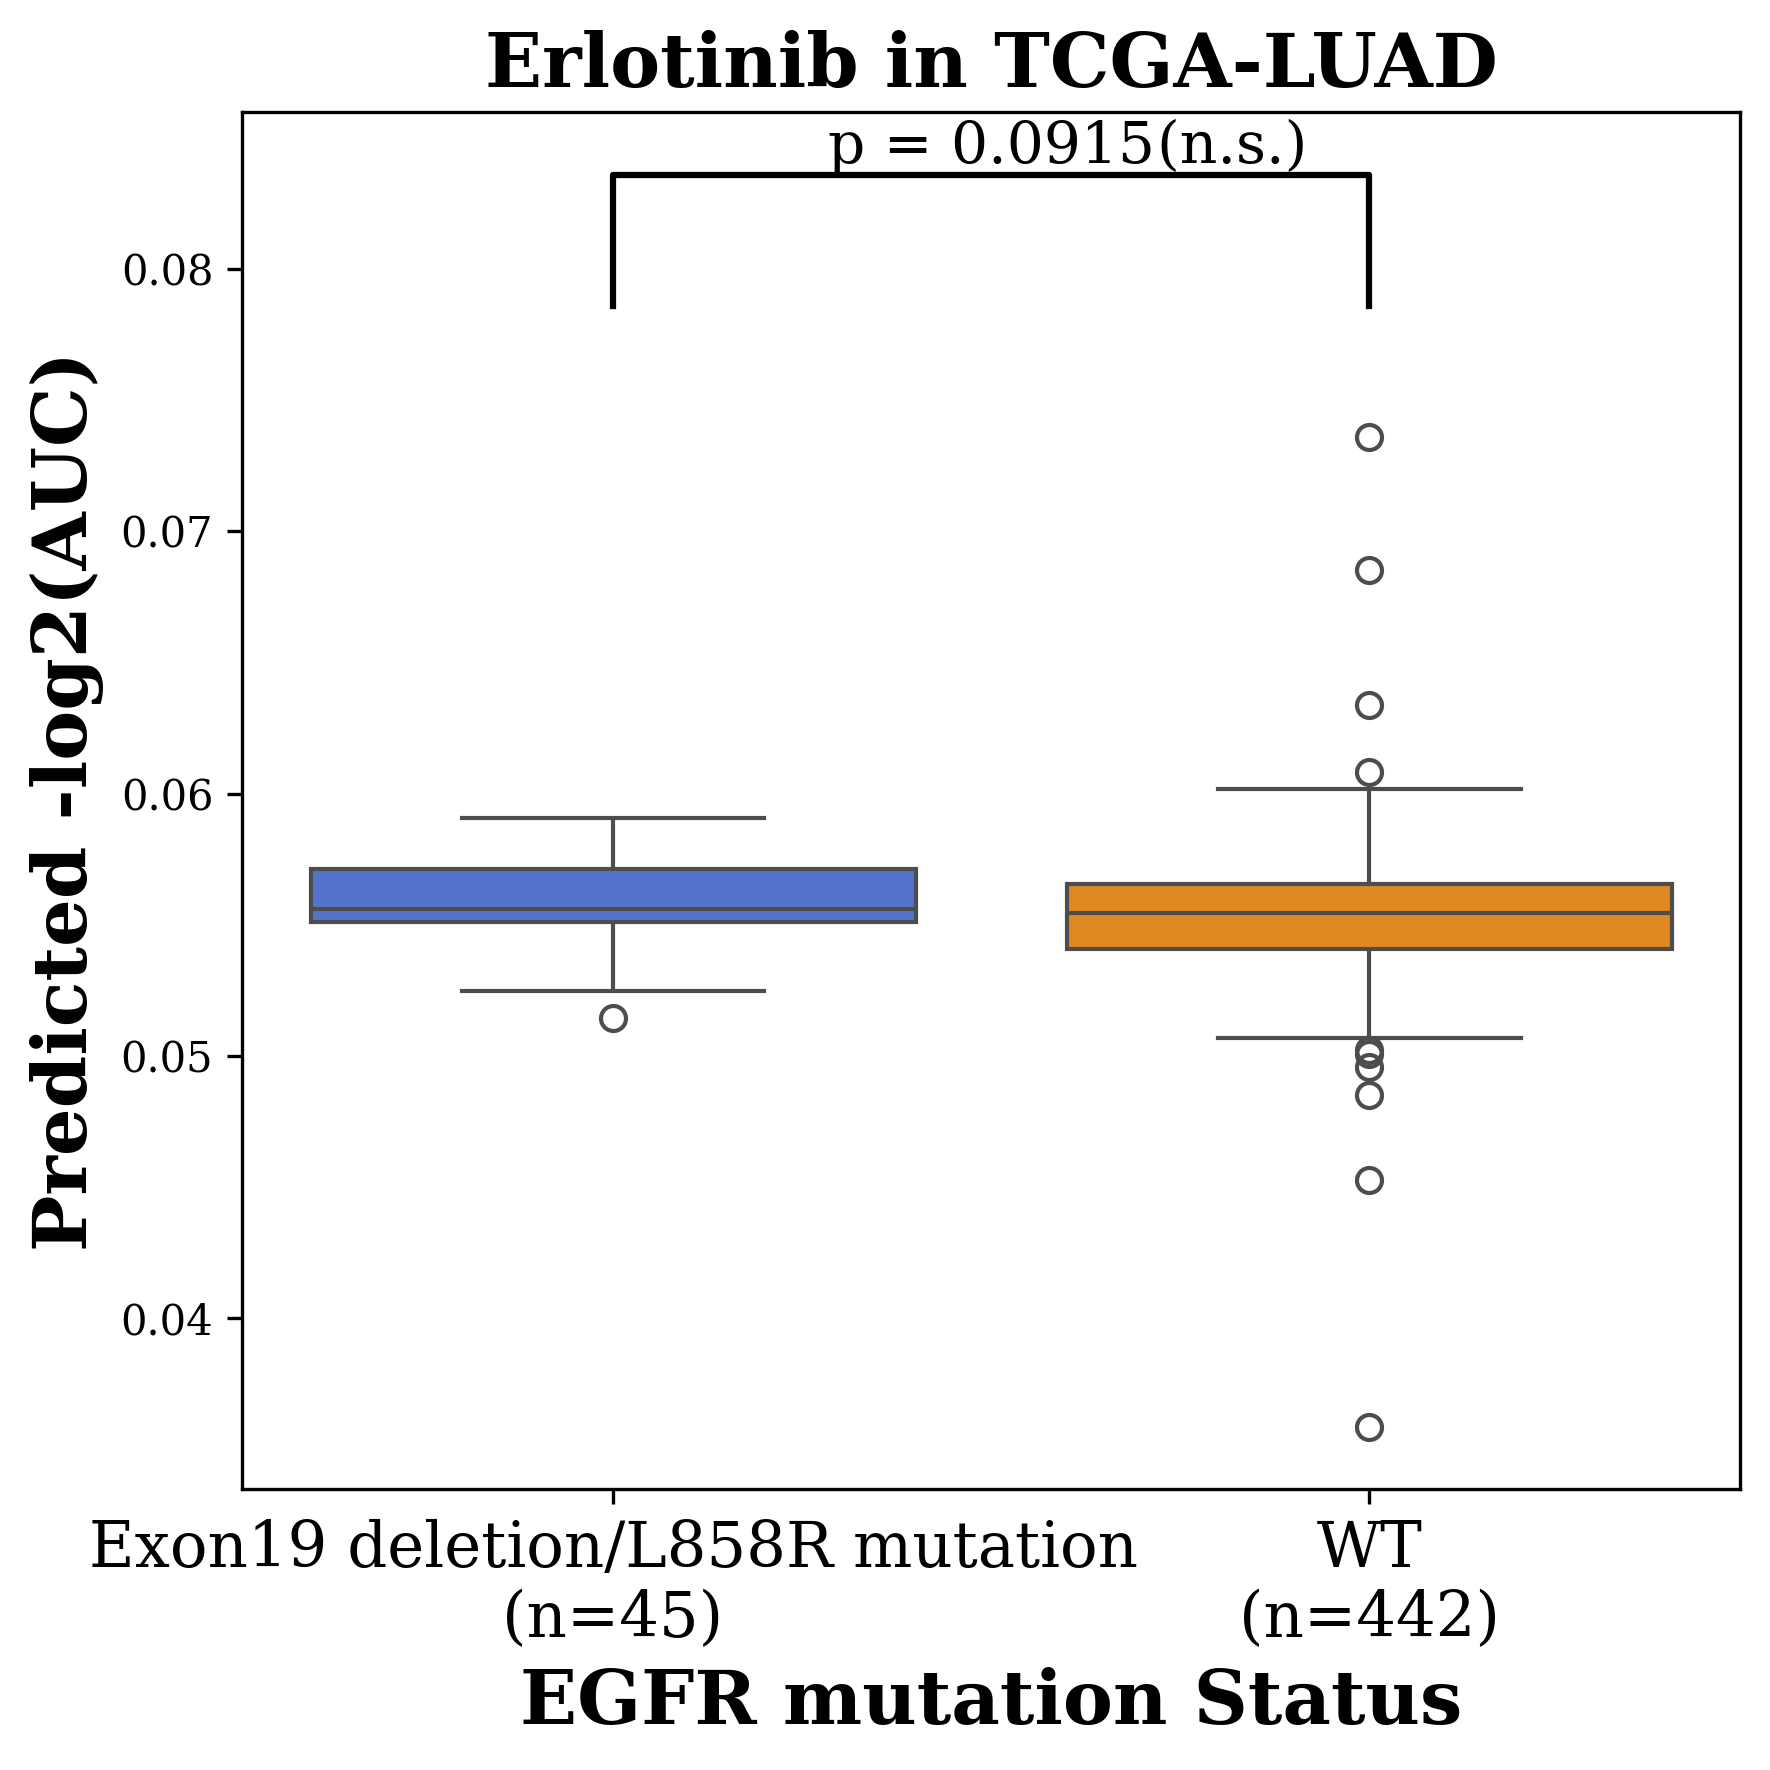

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
# plt.style.use('seaborn')  # Better default style
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (15, 6)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

# Plot the boxplot
plt.figure(figsize=(6, 6))
# custom_palette = {f'{MutType} (driver)': "royalblue", f'no alteration': "darkorange", f'Other mutations': "red"}
custom_palette = {f'{MutType} (driver)': "royalblue", f'no alteration': "darkorange"}
# custom_order = [ f"{MutType} (driver)", "no alteration", "Other mutations"]
custom_order = [ f"{MutType} (driver)", "no alteration"]
sns.boxplot(data=merged_df, x=f"{inhibit_Gene} Status", y="Predicted AUC", palette=custom_palette,order =custom_order)

# Split the data
group1 = merged_df[merged_df[f"{inhibit_Gene} Status"] == f"{MutType} (driver)"]["Predicted AUC"]
group2 = merged_df[merged_df[f"{inhibit_Gene} Status"] == "no alteration"]["Predicted AUC"]
# group3 = merged_df[merged_df[f"{inhibit_Gene} Status"] == "Other mutations"]["Predicted AUC"]
# Perform t-test
stat, p_value = ttest_ind(group1, group2, equal_var=False)
def p_to_star(p):
    if p < 0.0001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = merged_df["Predicted AUC"].max() + 0.005, 0.005  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.text((x1 + x2) / 2, y + h, f"                          ({p_to_star(p_value)})", ha='center', va='bottom', fontsize=14)
plt.xticks([0, 1], [f'{MutType} mutation\n(n={len(group1)})', f'WT\n(n={len(group2)})'], fontsize=15)
# plt.xticks([0,1,2], [f'Exon19 deletion/\nL858R mutation\n(n={len(group1)})', f'WT\n(n={len(group2)})', f'Other mutations\n(n={len(group3)})'], fontsize=15)

plt.title(f"{drug_name_short} in TCGA-{sample_type}", fontsize=18, fontweight='bold')
plt.ylabel("Predicted -log2(AUC)", fontsize=18, fontweight='bold')
plt.xlabel(f"{inhibit_Gene} mutation Status", fontsize=18, fontweight='bold')
# plt.tight_layout()
# plt.ylim(bottom=0.04,top=0.07)

plt.show()


 : 
Range: 0.48521891
Minimum: 0.43598142
Maximum: 0.92120034
Mean: 0.53200567
Median: 0.51976824
Standard Deviation: 0.06246929
Skewness: 2.11657047
binary data:False
-------------------------------------


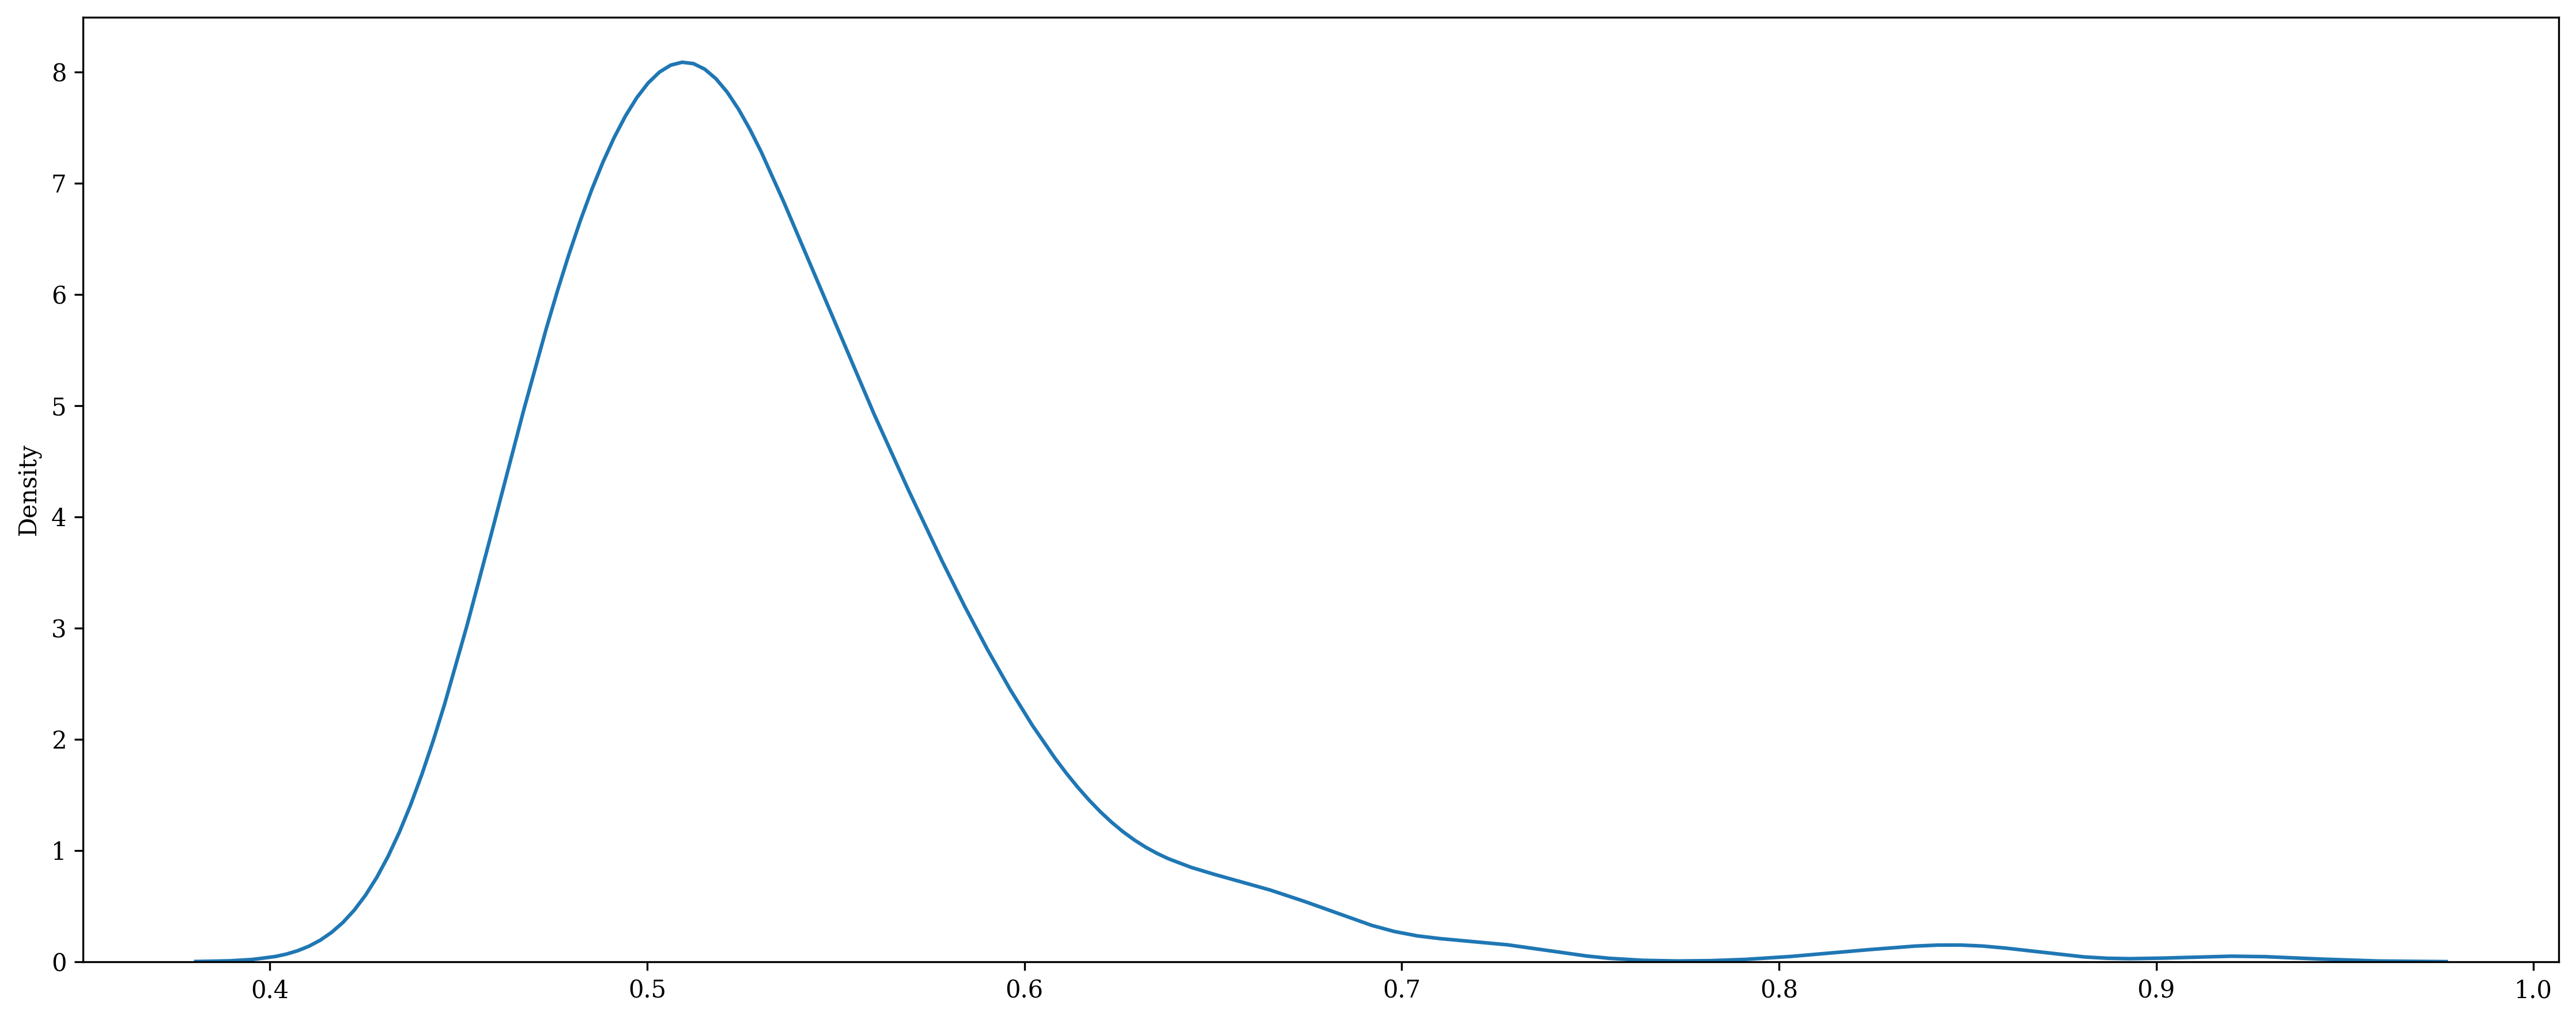

In [ ]:
get_data_value_range(torch.cat(eval_outputs).cpu().numpy())
sns.kdeplot(torch.cat(eval_outputs).cpu().numpy().tolist())
plt.show()

In [ ]:
omics_data_dict["Exp"][f"{inhibit_Gene} Status"]= merged_df[f"{inhibit_Gene} Status"].values
omics_data_dict["Exp"]

KeyError: 'BRAF Status'

/tmp/ipykernel_63851/1026356922.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


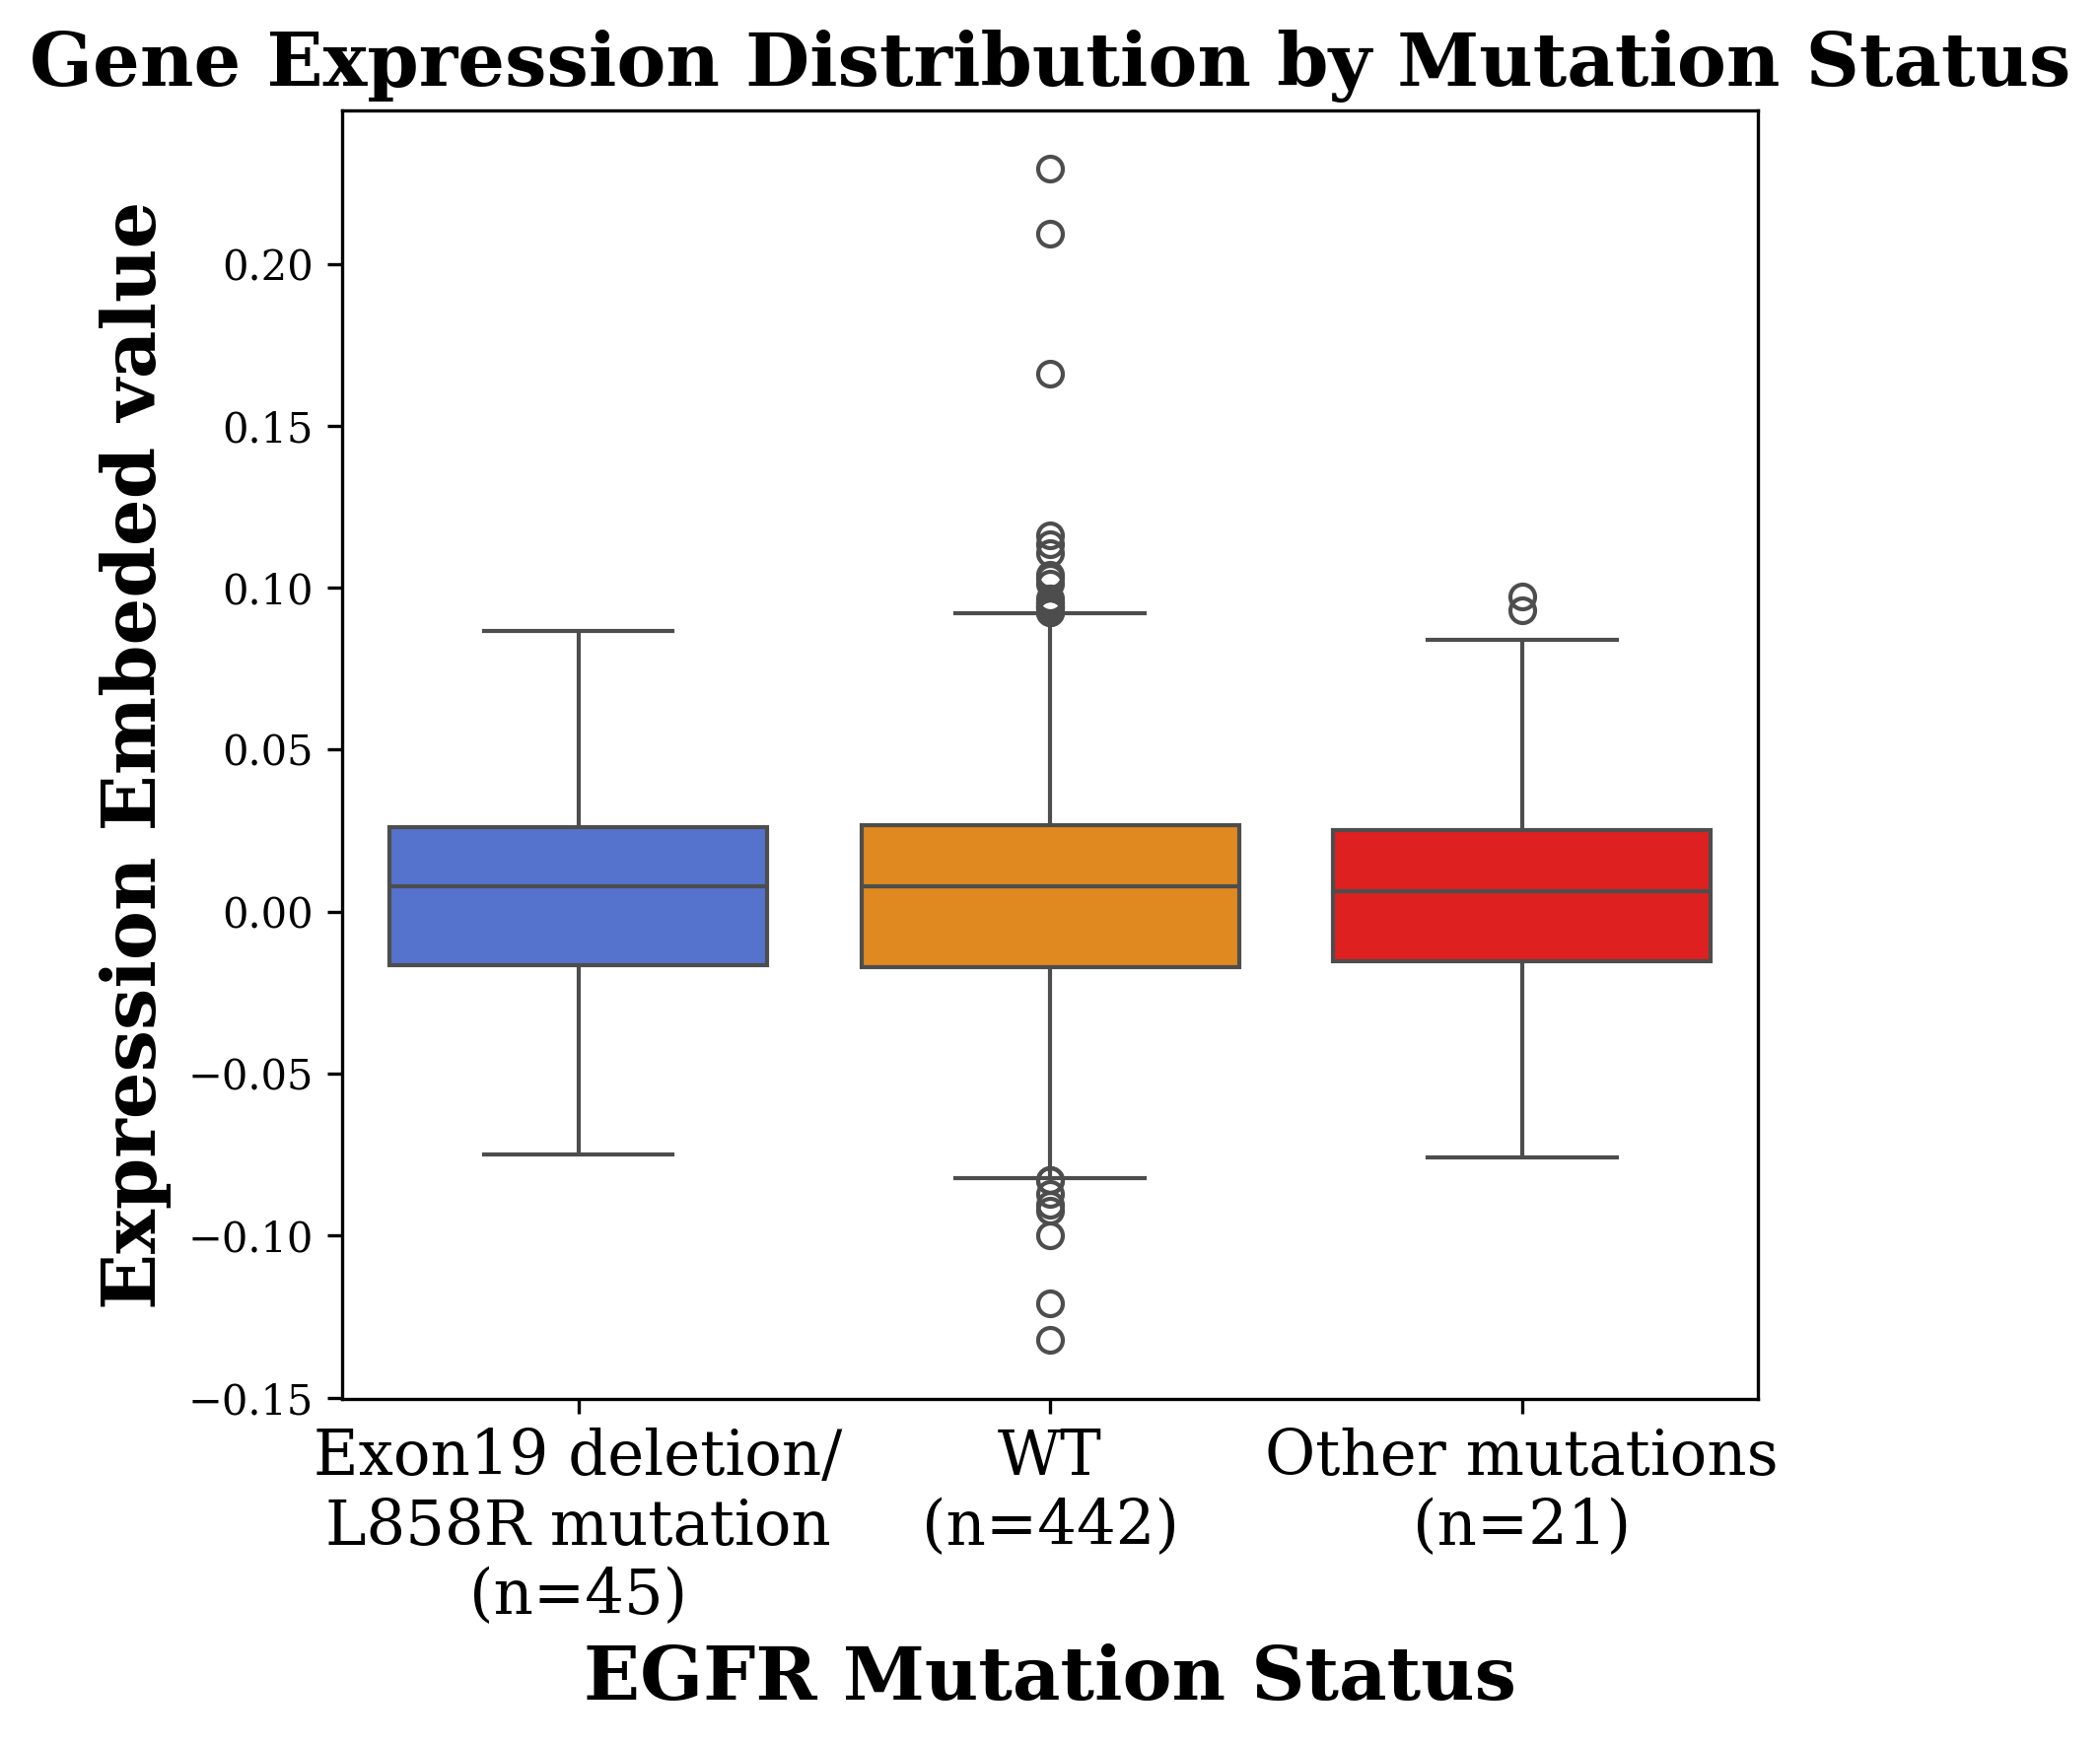

In [ ]:
inhibit_status_col = f"{inhibit_Gene} Status"
# Step 1: Melt the dataframe to long format
long_df = omics_data_dict["Exp"].melt(
    id_vars=inhibit_status_col,
    var_name="Gene",
    value_name="Expression")
custom_palette = {f'{MutType} (driver)': "royalblue", f'no alteration': "darkorange", f'Other mutations': "red"}
# Step 2: Plot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(
    data=long_df,
    x=inhibit_status_col,
    y="Expression",
    palette = custom_palette,
    order=[ "Exon19 deletion/L858R (driver)","no alteration", "Other mutations"])
plt.xticks([0,1,2], [f'Exon19 deletion/\nL858R mutation\n(n={len(group1)})', f'WT\n(n={len(group2)})', f'Other mutations\n(n={len(group3)})'], fontsize=15)
plt.title("Gene Expression Distribution by Mutation Status", fontsize=18, fontweight='bold')
plt.ylabel("Expression Embeded value", fontsize=18, fontweight='bold')
plt.xlabel(f"{inhibit_Gene} Mutation Status", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

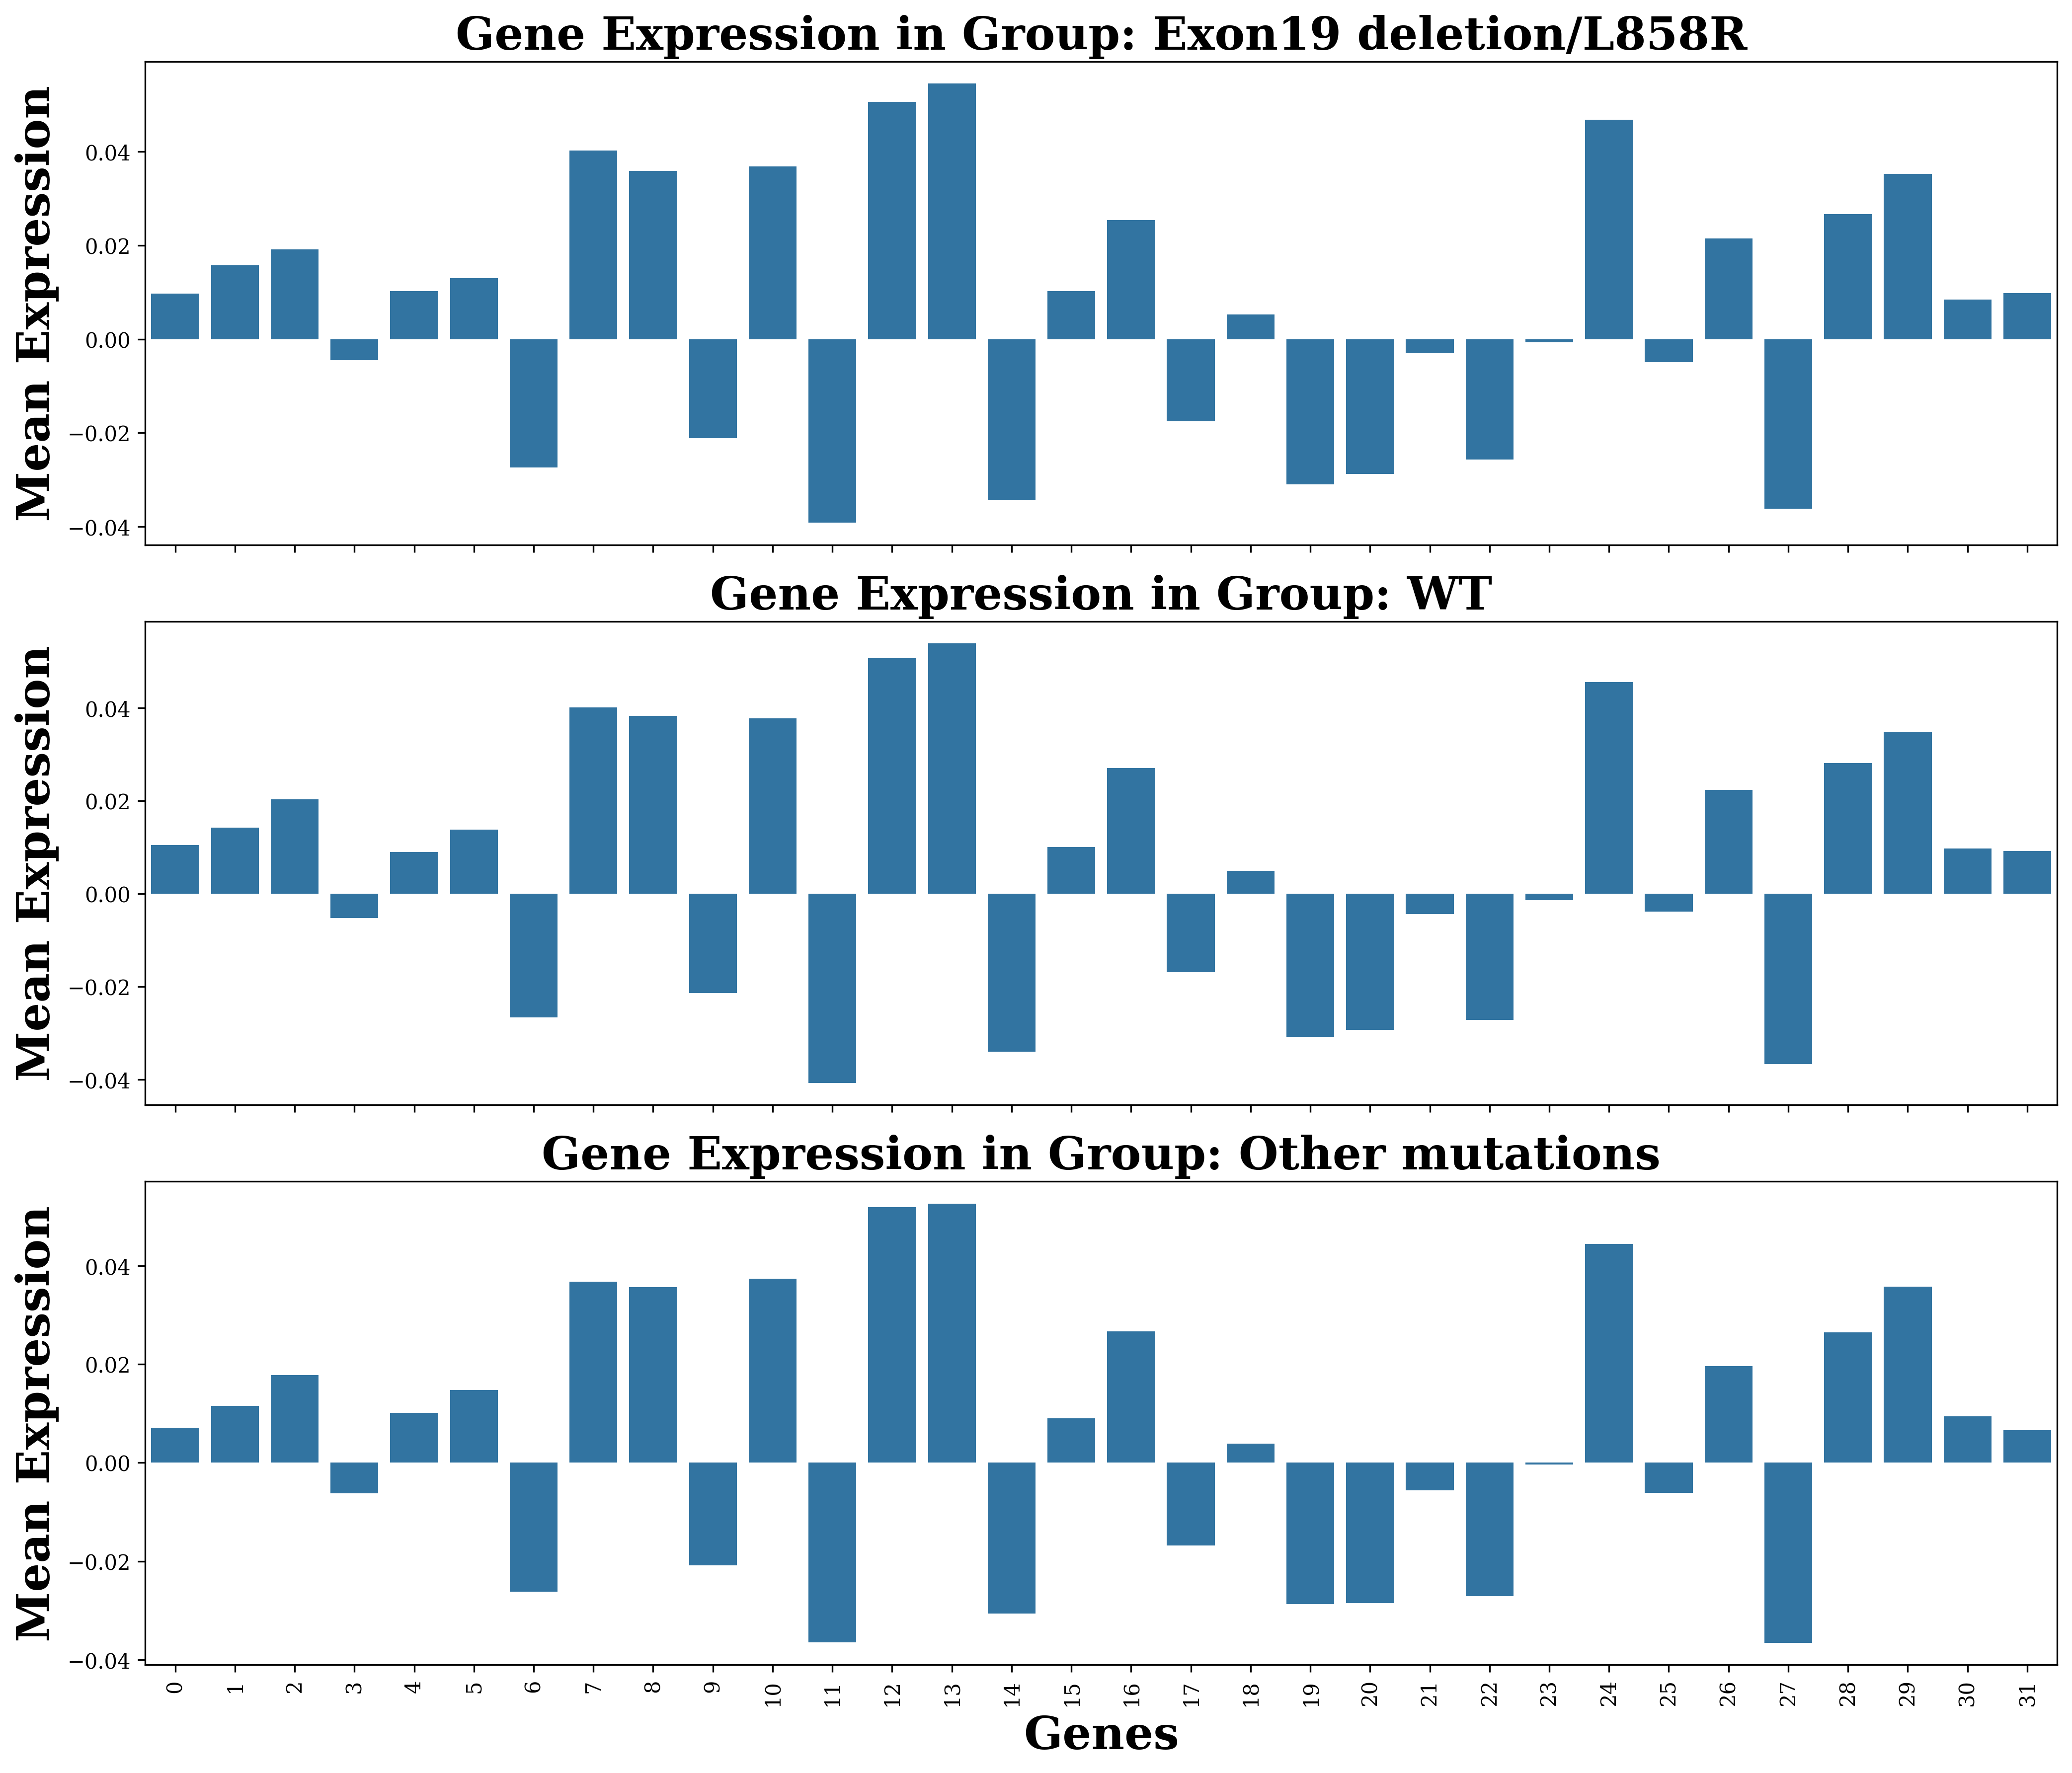

In [ ]:
# Assume first 32 columns are gene expression
gene_columns = omics_data_dict["Exp"].columns[:32]
status_col = f"{inhibit_Gene} Status"

# Prepare the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Get the three mutation status groups
status_order = [ f"{MutType} (driver)", "no alteration","Other mutations"]

for i, status in enumerate(status_order):
    group_df = omics_data_dict["Exp"][omics_data_dict["Exp"][status_col] == status]
    mean_values = group_df[gene_columns].mean()

    sns.barplot(
        x=gene_columns,
        y=mean_values.values,
        ax=axes[i],
    )
    Namedict={ f"{MutType} (driver)":f"{MutType}", "no alteration":"WT","Other mutations":"Other mutations"}
    axes[i].set_title(f"Gene Expression in Group: {Namedict[status]}",fontsize=22,fontweight="bold")
    axes[i].set_ylabel("Mean Expression",fontsize=22,fontweight="bold")
    axes[i].tick_params(axis='x', rotation=90)

axes[-1].set_xlabel("Genes",fontsize=22,fontweight="bold")
plt.tight_layout()
plt.show()

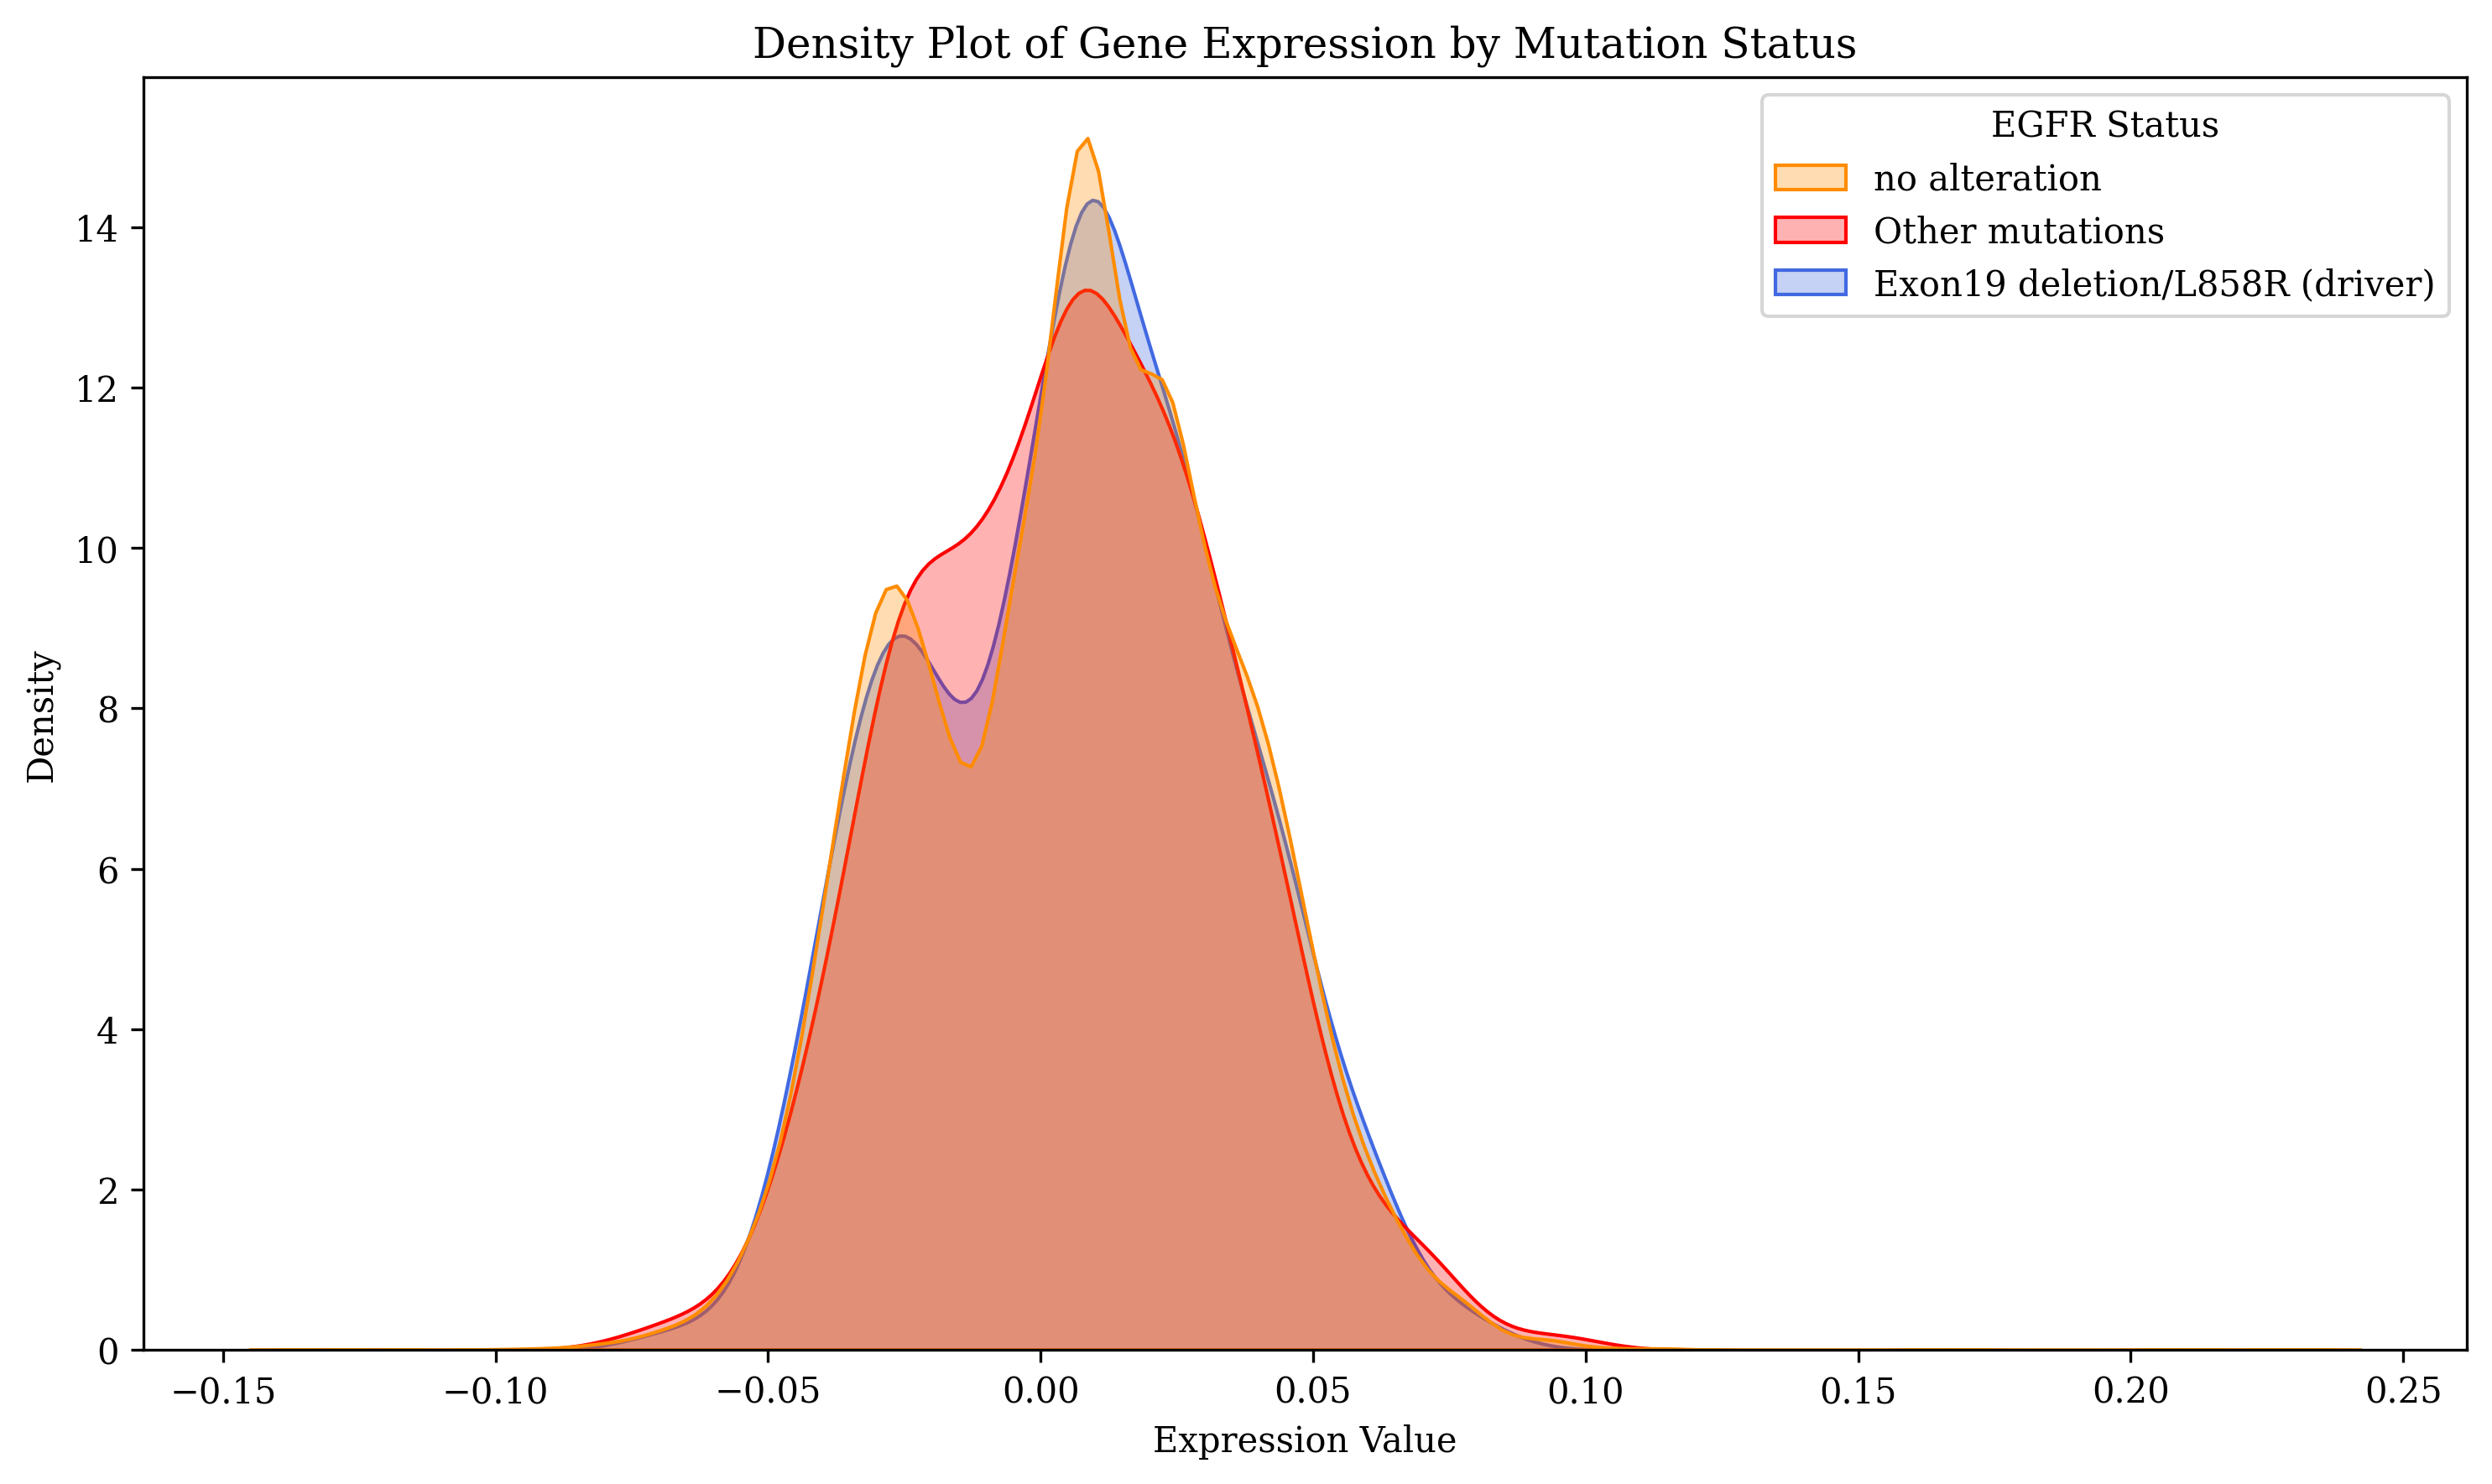

In [ ]:
# Melt the data to long format (if not already done)
long_df = omics_data_dict["Exp"].melt(
    id_vars=f"{inhibit_Gene} Status",
    var_name="Gene",
    value_name="Expression"
)
# Plot: density of all gene expression values by mutation status
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=long_df,
    x="Expression",
    hue=f"{inhibit_Gene} Status",
    palette=custom_palette,
    common_norm=False,  # if you want each group to have its own y-scaling
    fill=True,          # to fill under the curves
    alpha=0.3
)
plt.title("Density Plot of Gene Expression by Mutation Status")
plt.xlabel("Expression Value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

 : 
Range: 0.48521891
Minimum: 0.43598142
Maximum: 0.92120034
Mean: 0.53200567
Median: 0.51976824
Standard Deviation: 0.06246929
Skewness: 2.11657047
binary data:False
-------------------------------------


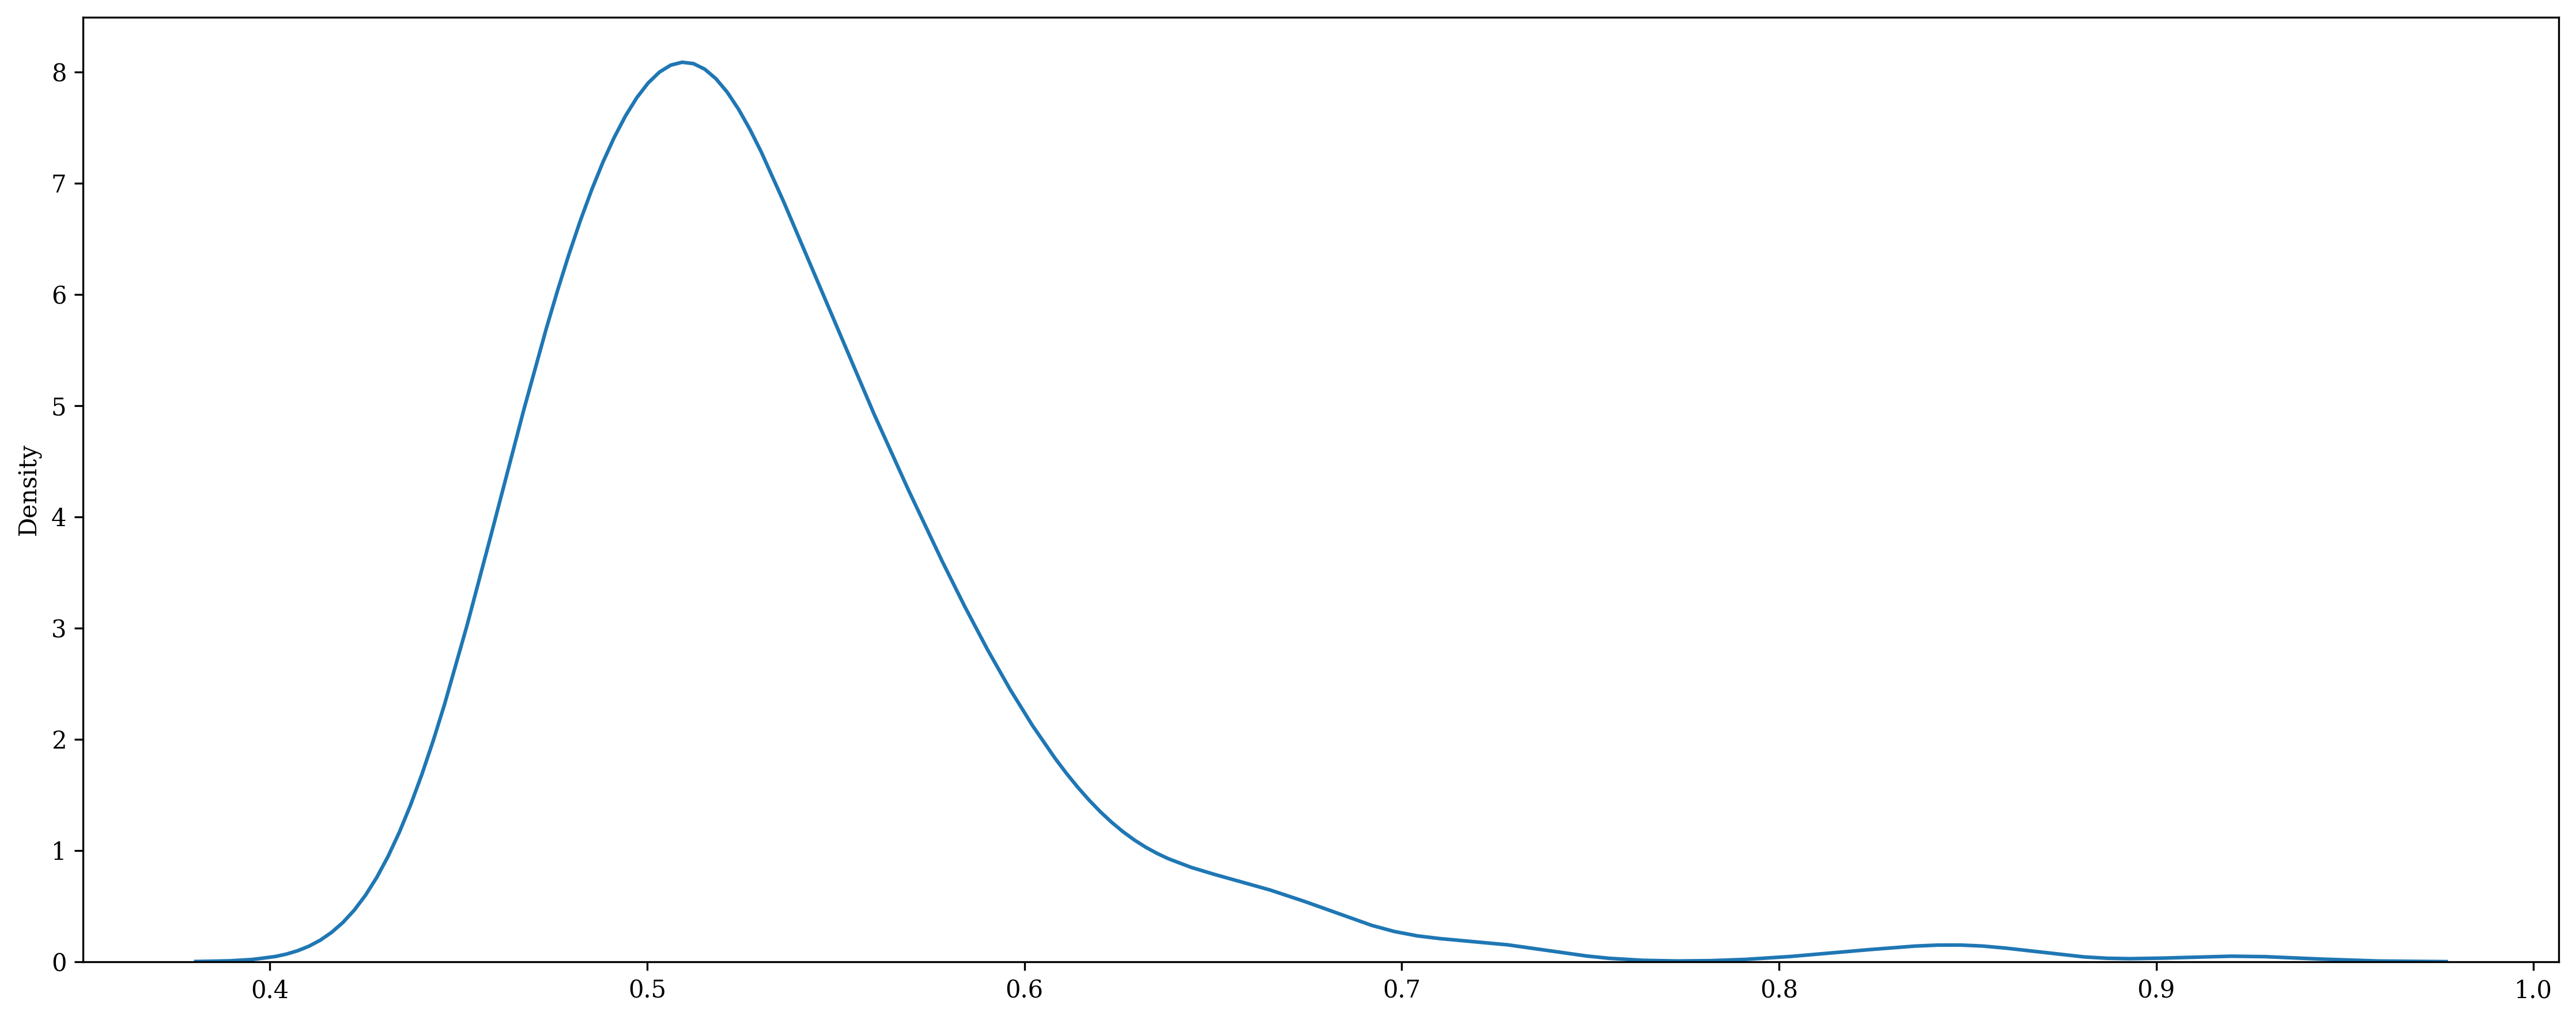

/tmp/ipykernel_63851/1866205291.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


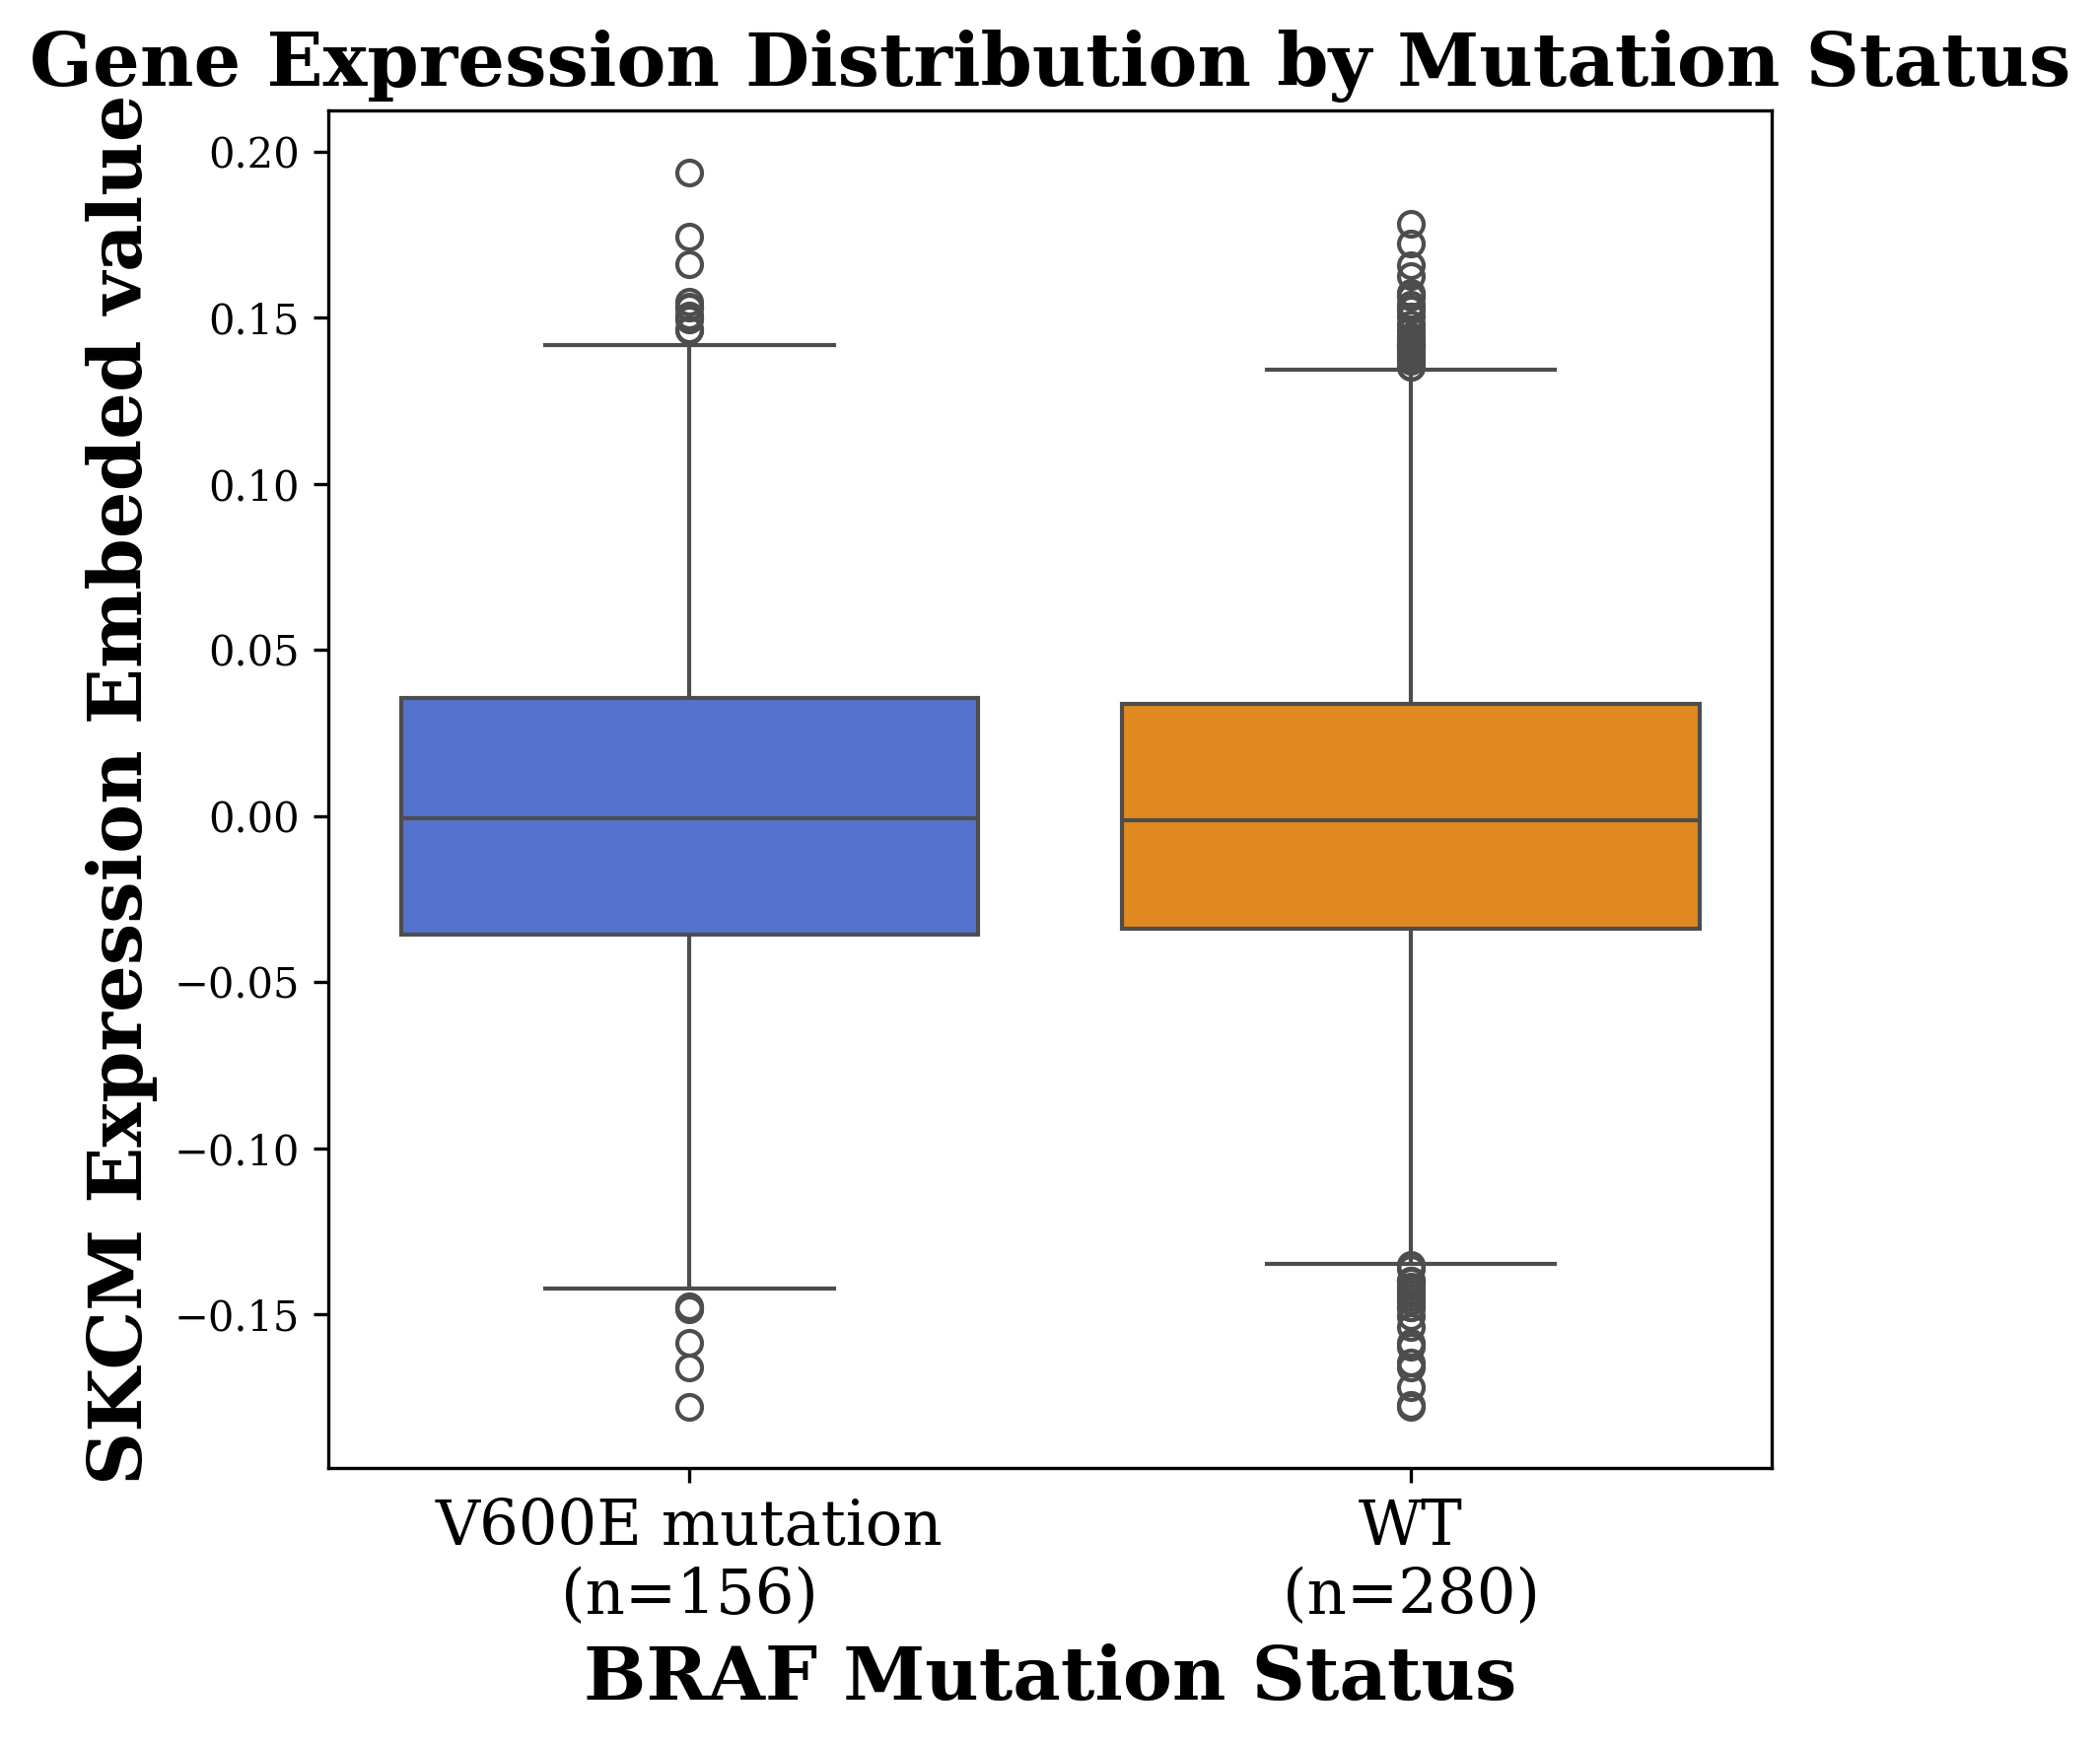

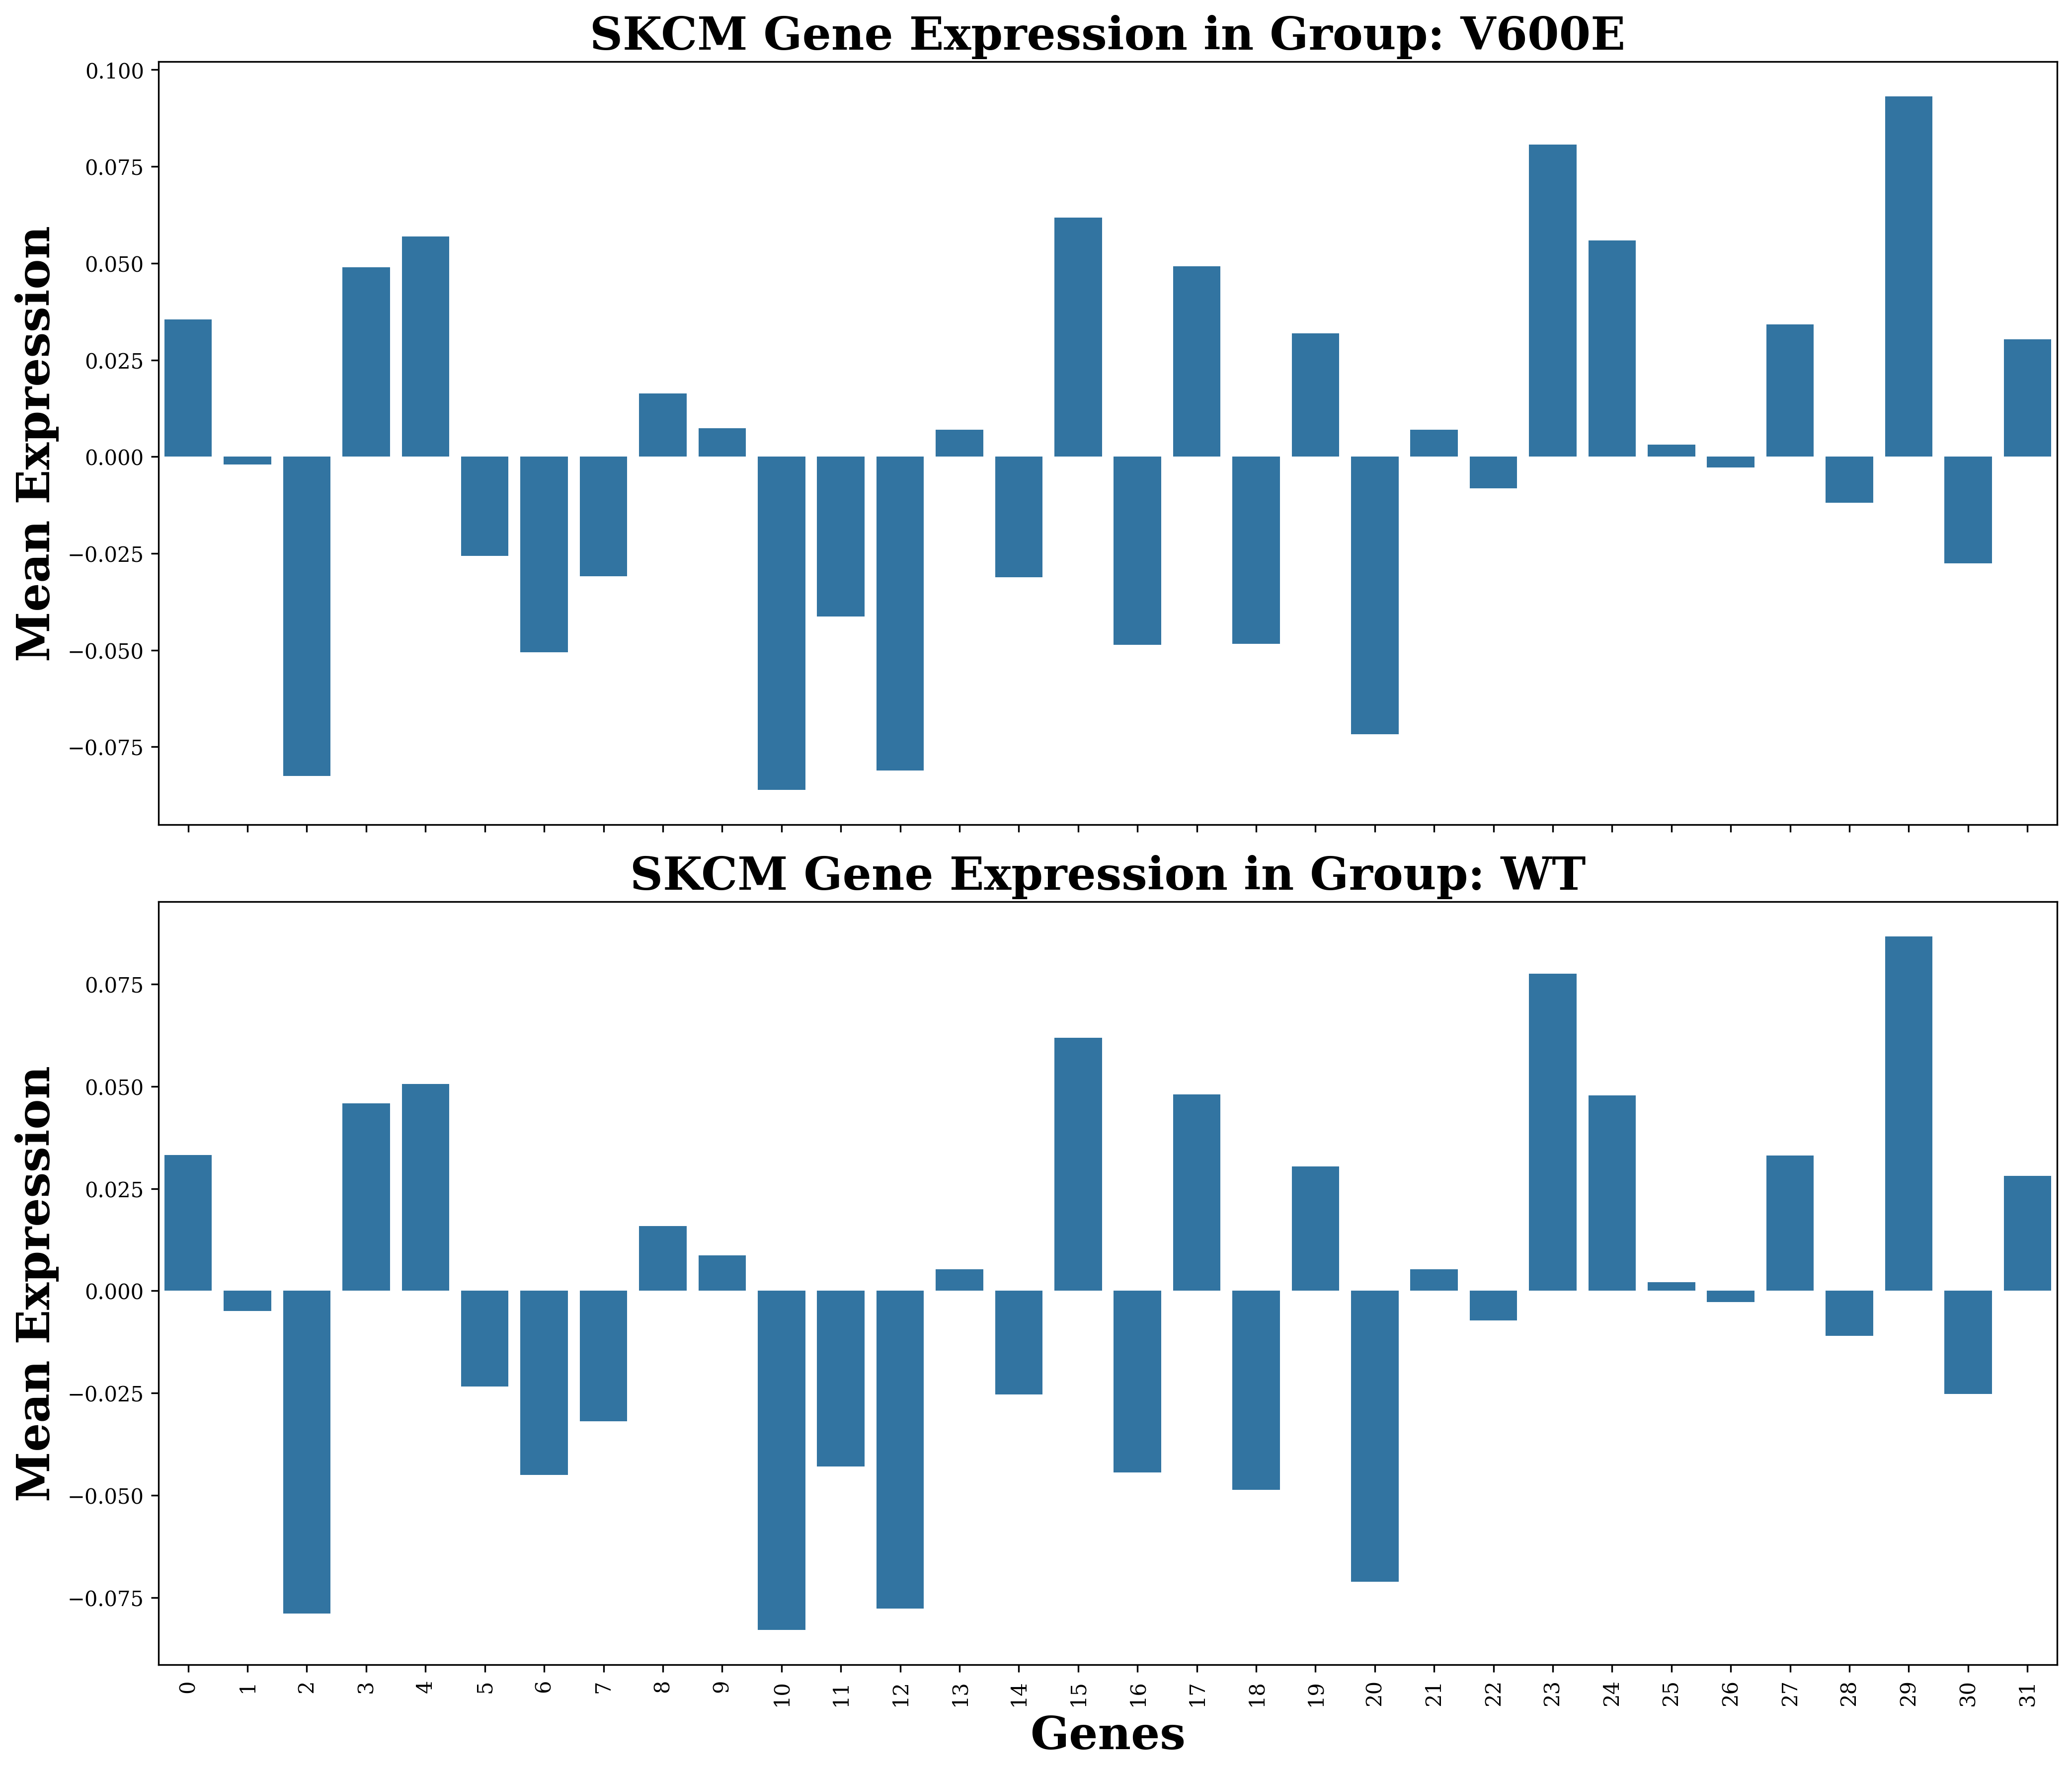

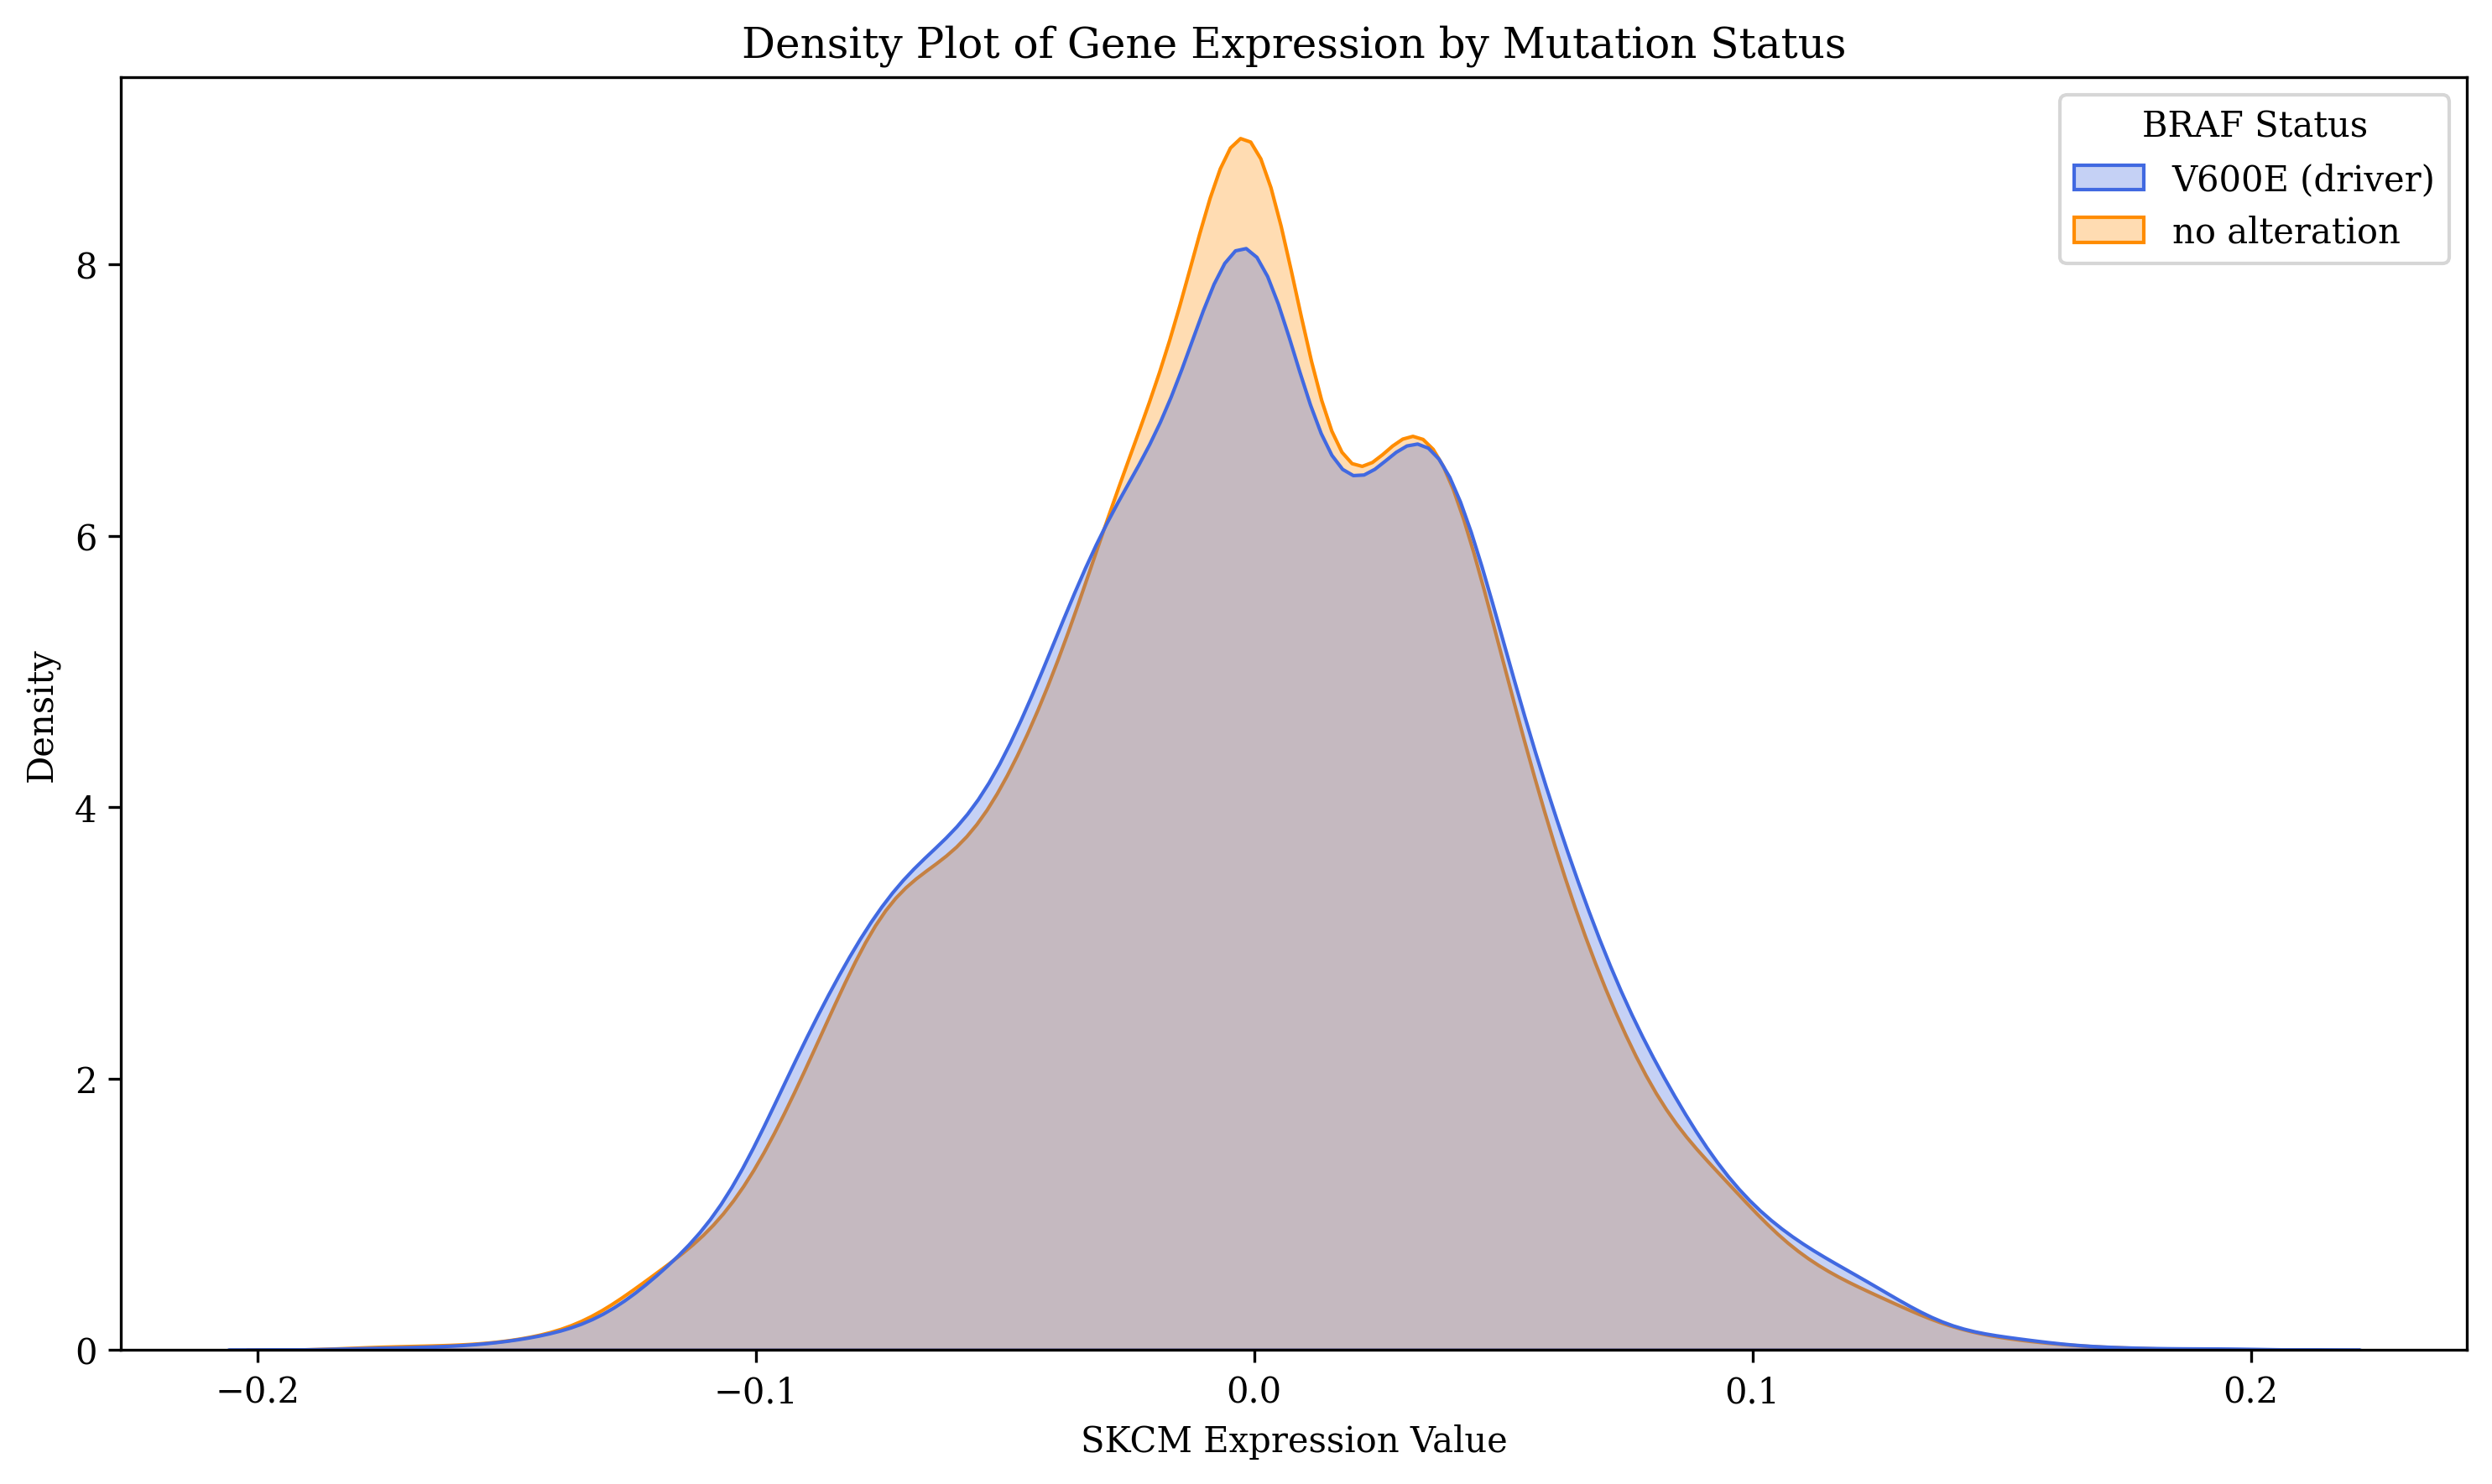

In [414]:
get_data_value_range(torch.cat(eval_outputs).cpu().numpy())
sns.kdeplot(torch.cat(eval_outputs).cpu().numpy().tolist())
plt.show()

omics_data_dict["Exp"][f"{inhibit_Gene} Status"]= merged_df[f"{inhibit_Gene} Status"].values
omics_data_dict["Exp"]

inhibit_status_col = f"{inhibit_Gene} Status"
# Step 1: Melt the dataframe to long format
long_df = omics_data_dict["Exp"].melt(
    id_vars=inhibit_status_col,
    var_name="Gene",
    value_name="Expression")
# Step 2: Plot using seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(
    data=long_df,
    x=inhibit_status_col,
    y="Expression",
    palette = custom_palette,
    order = custom_order )
# plt.xticks([0,1,2], [f'Exon19 deletion/\nL858R mutation\n(n={len(group1)})', f'WT\n(n={len(group2)})', f'Other mutations\n(n={len(group3)})'], fontsize=15)
plt.xticks([0, 1], [f'{MutType} mutation\n(n={len(group1)})', f'WT\n(n={len(group2)})'], fontsize=15)
plt.title("Gene Expression Distribution by Mutation Status", fontsize=18, fontweight='bold')
plt.ylabel(f"{sample_type} Expression Embeded value", fontsize=18, fontweight='bold')
plt.xlabel(f"{inhibit_Gene} Mutation Status", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Assume first 32 columns are gene expression
gene_columns = omics_data_dict["Exp"].columns[:32]
status_col = f"{inhibit_Gene} Status"
# Prepare the figure
fig, axes = plt.subplots(len(custom_order), 1, figsize=(14, 12), sharex=True)
# Get the three mutation status groups
for i, status in enumerate(custom_order):
    group_df = omics_data_dict["Exp"][omics_data_dict["Exp"][status_col] == status]
    mean_values = group_df[gene_columns].mean()
    sns.barplot(
        x=gene_columns,
        y=mean_values.values,
        ax=axes[i],    )
    NameDict={ f"{MutType} (driver)":f"{MutType}", "no alteration":"WT","Other mutations":"Other mutations"}
    axes[i].set_title(f"{sample_type} Gene Expression in Group: {NameDict[status]}",fontsize=22,fontweight="bold")
    axes[i].set_ylabel("Mean Expression",fontsize=22,fontweight="bold")
    axes[i].tick_params(axis='x', rotation=90)
axes[-1].set_xlabel("Genes",fontsize=22,fontweight="bold")
plt.tight_layout()
plt.show()

# Melt the data to long format (if not already done)
long_df = omics_data_dict["Exp"].melt(
    id_vars=f"{inhibit_Gene} Status",
    var_name="Gene",
    value_name="Expression")
# Plot: density of all gene expression values by mutation status
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=long_df,
    x="Expression",
    hue=f"{inhibit_Gene} Status",
    palette=custom_palette,
    common_norm=False,  # if you want each group to have its own y-scaling
    fill=True,          # to fill under the curves
    alpha=0.3)
plt.title("Density Plot of Gene Expression by Mutation Status")
plt.xlabel(f"{sample_type} Expression Value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

## TCGA response

In [100]:
tissue_type_df= pd.read_csv("../data/DAPL/share/TCGA_primarycancer_fromCombine_phenotype.csv", sep=',', index_col=0)
print(tissue_type_df.shape)
with open(f"../data/DAPL/share/pretrain/{DA_Folder}/tcga_latent_results.pkl", 'rb') as f: #32dim
    latent_dict = pickle.load(f)
    TCGAexp_df = pd.DataFrame(latent_dict).T
    print(TCGAexp_df.shape)
tcga_reponse_df = pd.read_csv("../data/DAPL/share/tcga_drug_first_response_type.csv", sep=',', index_col=0)
print(tcga_reponse_df.shape)

(9185, 6)
(9808, 32)
(4144, 2)


In [ ]:
match_sample1 = set(tissue_type_df.index.str[:-3]) & set(TCGAexp_df.index.str[:-3])
print(len(match_sample1))
match_sample2 = match_sample1 & set(tcga_reponse_df.index)
print(len(match_sample2))
tissue_type_df.index = tissue_type_df.index.str[:-3]
TCGAexp_df.index = TCGAexp_df.index.str[:-3]
tissue_type_df=tissue_type_df.loc[list(match_sample2)] # (3545, 6)
TCGAexp_df=TCGAexp_df.loc[list(match_sample2)] 
tcga_reponse_df = tcga_reponse_df.loc[list(match_sample2)] # (3545, 2)
TCGAexp_df = TCGAexp_df[~TCGAexp_df.index.duplicated(keep='first')] # (3545, 32)
print(tissue_type_df.shape)
print(TCGAexp_df.shape)

9185
3545


In [112]:
tcga_reponse_df

treatment_outcome_at_tcga_followup tcga_project
bcr_patient_barcode                                                
TCGA-EY-A549                         Complete Response         UCEC
TCGA-BR-8297                       Progressive Disease         STAD
TCGA-IA-A40U               Complete Remission/Response         KIRP
TCGA-FD-A6TK                         Complete Response         BLCA
TCGA-50-6594                       Progressive Disease         LUAD
...                                                ...          ...
TCGA-DK-A3IQ                       Progressive Disease         BLCA
TCGA-FD-A3SQ                       Progressive Disease         BLCA
TCGA-BG-A0MK                       Progressive Disease         UCEC
TCGA-DX-A8BL                         Complete Response         SARC
TCGA-GS-A9TX               Complete Remission/Response         DLBC

[3545 rows x 2 columns]

In [ ]:
tissue_type_df["_primary_site"]

detailed_category  \
sample                                                
TCGA-EY-A549  Uterine Corpus Endometrioid Carcinoma   
TCGA-BR-8297                 Stomach Adenocarcinoma   
TCGA-IA-A40U        Kidney Papillary Cell Carcinoma   
TCGA-FD-A6TK           Bladder Urothelial Carcinoma   
TCGA-50-6594                    Lung Adenocarcinoma   
...                                             ...   
TCGA-DK-A3IQ           Bladder Urothelial Carcinoma   
TCGA-FD-A3SQ           Bladder Urothelial Carcinoma   
TCGA-BG-A0MK  Uterine Corpus Endometrioid Carcinoma   
TCGA-DX-A8BL                                Sarcoma   
TCGA-GS-A9TX          Diffuse Large B-Cell Lymphoma   

                          primary disease or tissue     _primary_site  \
sample                                                                  
TCGA-EY-A549  Uterine Corpus Endometrioid Carcinoma       Endometrium   
TCGA-BR-8297                 Stomach Adenocarcinoma           Stomach   
TCGA-IA-A40U        Kidney Papillary Cell Carcinoma            Kidney   
TCGA-FD-A6TK           Bladder Urothelial Carcinoma           Bladder   
TCGA-50-6594                    Lung Adenocarcinoma              Lung   
...                                             ...               ...   
TCGA-DK-A3IQ           Bladder Urothelial Carcinoma           Bladder   
TCGA-FD-A3SQ           Bladder Urothelial Carcinoma           Bladder   
TCGA-BG-A0MK  Uterine Corpus Endometrioid Carcinoma       Endometrium   
TCGA-DX-A8BL                                Sarcoma  Soft tissue,Bone   
TCGA-GS-A9TX          Diffuse Large B-Cell Lymphoma  Lymphatic tissue   

               _sample_type _gender _study  
sample                                      
TCGA-EY-A549  Primary Tumor  Female   TCGA  
TCGA-BR-8297  Primary Tumor    Male   TCGA  
TCGA-IA-A40U  Primary Tumor    Male   TCGA  
TCGA-FD-A6TK  Primary Tumor    Male   TCGA  
TCGA-50-6594  Primary Tumor  Female   TCGA  
...                     ...     ...    ...  
TCGA-DK-A3IQ  Primary Tumor    Male   TCGA  
TCGA-FD-A3SQ  Primary Tumor    Male   TCGA  
TCGA-BG-A0MK  Primary Tumor  Female   TCGA  
TCGA-DX-A8BL  Primary Tumor    Male   TCGA  
TCGA-GS-A9TX  Primary Tumor    Male   TCGA  

[3545 rows x 6 columns]

In [ ]:
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict["Exp"] = TCGAexp_df
    else:
        if omic_type == "Exp":
            # apply Column-wise Standardization
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


(3545, 6)
(3545, 32)


#### TCGA reponse df 沒有說是用什麼藥

In [78]:
def find_best_thresholds_torchmetrics(probs: torch.Tensor, targets: torch.Tensor, num_thresholds: int = 10000):
    """ Find best threshold using AUROC and AUPRC via torchmetrics.
        Args:
            probs (torch.Tensor): Probabilities (float) of shape [N]
            targets (torch.Tensor): Binary targets (0/1) of shape [N]
            num_thresholds (int): Number of thresholds to try
        Returns:
            best_thresh_roc: Best threshold based on TPR - FPR (Youden's J)
            best_thresh_pr: Best threshold based on F1 score    """
    thresholds = torch.linspace(0, 1, num_thresholds).to(probs.device)
    best_j = -float('inf')
    best_thresh_roc = 0.5
    best_f1 = -float('inf')
    best_thresh_pr = 0.5
    for thresh in thresholds:
        preds = (probs > thresh).int()
        tp = ((preds == 1) & (targets == 1)).sum().float()
        fn = ((preds == 0) & (targets == 1)).sum().float()
        fp = ((preds == 1) & (targets == 0)).sum().float()
        tn = ((preds == 0) & (targets == 0)).sum().float()
        # ROC-based (Youden's J)
        tpr = tp / (tp + fn + 1e-8)  # Sensitivity
        fpr = fp / (fp + tn + 1e-8)
        j_stat = tpr - fpr
        if j_stat > best_j:
            best_j = j_stat
            best_thresh_roc = thresh.item()
        # PR-based (F1 score)
        precision = tp / (tp + fp + 1e-8)
        recall = tpr
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh_pr = thresh.item()
    return best_thresh_roc, best_thresh_pr

In [79]:
probs = torch.cat(eval_outputs)  # shape [N]
targets = torch.cat(eval_targets).int().to(probs.device)

best_thresh_roc, best_thresh_pr = find_best_thresholds_torchmetrics(probs, targets)
print(f"Best AUROC-based threshold: {best_thresh_roc:.4f}")
print(f"Best AUPRC-based threshold: {best_thresh_pr:.4f}")

Best AUROC-based threshold: 0.9217
Best AUPRC-based threshold: 0.0000


In [17]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [18]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    mse = np.mean((pred_AUC[mask] - GT_AUC[mask]) ** 2)
    mae = np.mean(np.abs(pred_AUC[mask] - GT_AUC[mask]))
    dict["MAE"].append(mae)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000182', 'ACH-001239', 'ACH-000762', 'ACH-000946', 'ACH-000618', 'ACH-000444', 'ACH-000833', 'ACH-000500', 'ACH-000758', 'ACH-000582', 'ACH-000632', 'ACH-000164', 'ACH-000734', 'ACH-000891', 'ACH-000771', 'ACH-000732', 'ACH-000774', 'ACH-000461', 'ACH-000237', 'ACH-000661', 'ACH-000022', 'ACH-000901', 'ACH-000921', 'ACH-000014', 'ACH-001128', 'ACH-000123', 'ACH-000808', 'ACH-000209', 'ACH-000721', 'ACH-000086', 'ACH-000753', 'ACH-000845', 'ACH-000344', 'ACH-000390', 'ACH-000097', 'ACH-000630', 'ACH-000735', 'ACH-000302', 'ACH-000898', 'ACH-000994', 'ACH-000163', 'ACH-000477', 'ACH-000307', 'ACH-000255', 'ACH-000990', 'ACH-000884', 'ACH-000133', 'ACH-000027', 'ACH-000331', 'ACH-000537', 'ACH-000280', 'ACH-000502', 'ACH-000404', 'ACH-000289', 'ACH-001145', 'ACH-000592', 'ACH-000418', 'ACH-000467', 'ACH-000324', 'ACH-000274', 'ACH-000723', 'ACH-000984', 'ACH-000909', 'ACH-000471', 'ACH-000839', 'ACH-000266', 'ACH-000682', 'ACH-000407', 'ACH-000701', 'ACH-001113', 'ACH-00020

KeyError: "['ACH-000001', 'ACH-000002', 'ACH-000004', 'ACH-000006', 'ACH-000009', 'ACH-000020', 'ACH-000024', 'ACH-000038', 'ACH-000045', 'ACH-000050', 'ACH-000053', 'ACH-000055', 'ACH-000056', 'ACH-000058', 'ACH-000059', 'ACH-000061', 'ACH-000065', 'ACH-000067', 'ACH-000070', 'ACH-000072', 'ACH-000073', 'ACH-000074', 'ACH-000075', 'ACH-000078', 'ACH-000081', 'ACH-000094', 'ACH-000100', 'ACH-000101', 'ACH-000103', 'ACH-000104', 'ACH-000105', 'ACH-000106', 'ACH-000111', 'ACH-000112', 'ACH-000113', 'ACH-000114', 'ACH-000115', 'ACH-000116', 'ACH-000120', 'ACH-000121', 'ACH-000124', 'ACH-000129', 'ACH-000135', 'ACH-000136', 'ACH-000144', 'ACH-000145', 'ACH-000146', 'ACH-000148', 'ACH-000149', 'ACH-000151', 'ACH-000157', 'ACH-000162', 'ACH-000168', 'ACH-000181', 'ACH-000183', 'ACH-000187', 'ACH-000190', 'ACH-000193', 'ACH-000196', 'ACH-000197', 'ACH-000198', 'ACH-000200', 'ACH-000204', 'ACH-000213', 'ACH-000218', 'ACH-000225', 'ACH-000226', 'ACH-000227', 'ACH-000233', 'ACH-000236', 'ACH-000238', 'ACH-000245', 'ACH-000247', 'ACH-000248', 'ACH-000249', 'ACH-000254', 'ACH-000257', 'ACH-000258', 'ACH-000263', 'ACH-000267', 'ACH-000269', 'ACH-000271', 'ACH-000282', 'ACH-000287', 'ACH-000290', 'ACH-000291', 'ACH-000293', 'ACH-000294', 'ACH-000295', 'ACH-000298', 'ACH-000301', 'ACH-000303', 'ACH-000304', 'ACH-000315', 'ACH-000326', 'ACH-000330', 'ACH-000334', 'ACH-000336', 'ACH-000337', 'ACH-000338', 'ACH-000341', 'ACH-000345', 'ACH-000346', 'ACH-000348', 'ACH-000349', 'ACH-000350', 'ACH-000353', 'ACH-000354', 'ACH-000355', 'ACH-000357', 'ACH-000358', 'ACH-000360', 'ACH-000362', 'ACH-000363', 'ACH-000365', 'ACH-000366', 'ACH-000369', 'ACH-000371', 'ACH-000372', 'ACH-000373', 'ACH-000378', 'ACH-000379', 'ACH-000380', 'ACH-000381', 'ACH-000386', 'ACH-000392', 'ACH-000394', 'ACH-000399', 'ACH-000400', 'ACH-000410', 'ACH-000422', 'ACH-000424', 'ACH-000430', 'ACH-000431', 'ACH-000432', 'ACH-000438', 'ACH-000439', 'ACH-000440', 'ACH-000442', 'ACH-000443', 'ACH-000448', 'ACH-000451', 'ACH-000464', 'ACH-000465', 'ACH-000470', 'ACH-000475', 'ACH-000478', 'ACH-000483', 'ACH-000489', 'ACH-000491', 'ACH-000501', 'ACH-000506', 'ACH-000508', 'ACH-000514', 'ACH-000515', 'ACH-000518', 'ACH-000522', 'ACH-000525', 'ACH-000530', 'ACH-000534', 'ACH-000536', 'ACH-000538', 'ACH-000546', 'ACH-000547', 'ACH-000548', 'ACH-000551', 'ACH-000554', 'ACH-000555', 'ACH-000556', 'ACH-000559', 'ACH-000560', 'ACH-000567', 'ACH-000568', 'ACH-000574', 'ACH-000577', 'ACH-000580', 'ACH-000581', 'ACH-000583', 'ACH-000584', 'ACH-000585', 'ACH-000586', 'ACH-000596', 'ACH-000607', 'ACH-000610', 'ACH-000611', 'ACH-000615', 'ACH-000616', 'ACH-000617', 'ACH-000621', 'ACH-000626', 'ACH-000631', 'ACH-000633', 'ACH-000636', 'ACH-000638', 'ACH-000639', 'ACH-000640', 'ACH-000641', 'ACH-000644', 'ACH-000653', 'ACH-000654', 'ACH-000655', 'ACH-000656', 'ACH-000660', 'ACH-000664', 'ACH-000668', 'ACH-000675', 'ACH-000689', 'ACH-000691', 'ACH-000697', 'ACH-000698', 'ACH-000699', 'ACH-000702', 'ACH-000703', 'ACH-000706', 'ACH-000714', 'ACH-000718', 'ACH-000722', 'ACH-000725', 'ACH-000727', 'ACH-000729', 'ACH-000740', 'ACH-000743', 'ACH-000745', 'ACH-000751', 'ACH-000752', 'ACH-000754', 'ACH-000755', 'ACH-000757', 'ACH-000763', 'ACH-000767', 'ACH-000770', 'ACH-000772', 'ACH-000780', 'ACH-000786', 'ACH-000789', 'ACH-000790', 'ACH-000793', 'ACH-000794', 'ACH-000795', 'ACH-000798', 'ACH-000806', 'ACH-000815', 'ACH-000816', 'ACH-000817', 'ACH-000818', 'ACH-000821', 'ACH-000825', 'ACH-000828', 'ACH-000830', 'ACH-000838', 'ACH-000857', 'ACH-000859', 'ACH-000861', 'ACH-000864', 'ACH-000865', 'ACH-000867', 'ACH-000871', 'ACH-000874', 'ACH-000876', 'ACH-000883', 'ACH-000894', 'ACH-000902', 'ACH-000910', 'ACH-000914', 'ACH-000918', 'ACH-000920', 'ACH-000922', 'ACH-000930', 'ACH-000932', 'ACH-000934', 'ACH-000935', 'ACH-000937', 'ACH-000938', 'ACH-000944', 'ACH-000949', 'ACH-000951', 'ACH-000953', 'ACH-000960', 'ACH-000963', 'ACH-000969', 'ACH-000980', 'ACH-000981', 'ACH-000983', 'ACH-000986', 'ACH-000989', 'ACH-000995', 'ACH-000998', 'ACH-000999', 'ACH-001086', 'ACH-001106', 'ACH-001193', 'ACH-001274', 'ACH-001328', 'ACH-001332', 'ACH-001333', 'ACH-001334', 'ACH-001336', 'ACH-001341', 'ACH-001344', 'ACH-001345', 'ACH-001360', 'ACH-001368', 'ACH-001373', 'ACH-001374', 'ACH-001399', 'ACH-001400', 'ACH-001401', 'ACH-001402', 'ACH-001418', 'ACH-001442', 'ACH-001443', 'ACH-001494', 'ACH-001496', 'ACH-001497', 'ACH-001498', 'ACH-001500', 'ACH-001517', 'ACH-001525', 'ACH-001526', 'ACH-001529', 'ACH-001530', 'ACH-001542', 'ACH-001549', 'ACH-001617', 'ACH-001638', 'ACH-001642', 'ACH-001650', 'ACH-001653', 'ACH-001654', 'ACH-001655', 'ACH-001674', 'ACH-001702', 'ACH-001711', 'ACH-001715'] not in index"

In [ ]:
combined_data = list(zip(dict['Tissue_Type'], dict['MAE'], dict['Sample_Size']))
# Sort the list by the MAE value (second element of each tuple)
sorted_dict = sorted(combined_data, key=lambda x: x[1])
# Unzip the sorted dict back into separate lists
sorted_tissue_type, sorted_mae, sorted_sample_size = zip(*sorted_dict)
# Convert back to lists
sorted_tissue_type = list(sorted_tissue_type)
sorted_mae = list(sorted_mae)
sorted_sample_size = list(sorted_sample_size)
# Update the dictionary with sorted values
sorted_data_dict = {'Tissue_Type': sorted_tissue_type,
                    'MAE': sorted_mae,
                    'Sample_Size': sorted_sample_size}
print(sorted_data_dict)

{'Tissue_Type': ['Ovary and Fallopian Tube', 'Esophagus and Stomach', 'Skin', 'Head and Neck', 'Uterus', 'Biliary Tract', 'Lung', 'CNS Brain', 'Bladder or Urinary Tract', 'Breast', 'Thyroid', 'Pancreas', 'Prostate', 'Kidney', 'Liver', 'Bowel', 'Pleura'], 'MAE': [0.04807667112087825, 0.048818469367331696, 0.05010206953891626, 0.05038012766762808, 0.0504408430583611, 0.05048725885369153, 0.050509283479876654, 0.05071948666172378, 0.05120264580784668, 0.05139497059868344, 0.05151358878648829, 0.051602280614034414, 0.053161212311937864, 0.0547444460281538, 0.056035468440888754, 0.05739064591184097, 0.05928841260387694], 'Sample_Size': [30, 40, 39, 23, 23, 7, 92, 34, 23, 22, 9, 33, 3, 17, 17, 27, 9]}


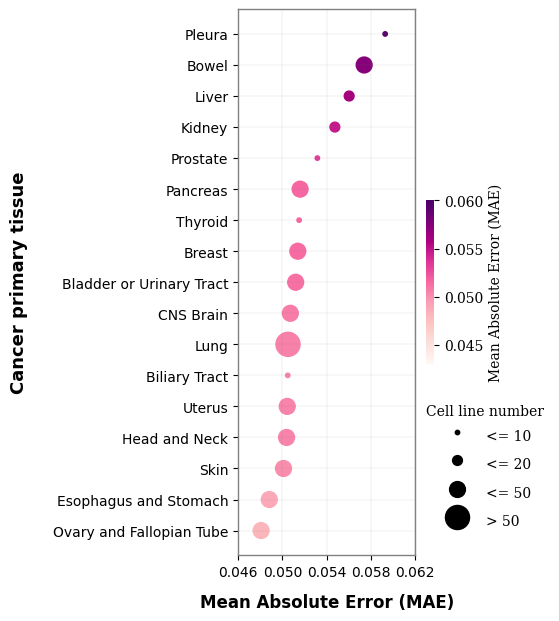

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Sample data
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = result = [10 if x <= 10 else
                        50 if x <= 20 else
                        130 if x <= 50 else
                        300
                        for x in data['Sample_Size']   ]
# Create figure
fig, ax = plt.subplots(figsize=(5, 6))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot)
sc = ax.scatter(
    data['MAE'], data['Tissue_Type'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu',vmin=0.043,vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax,shrink=0.3)
cbar.set_label("Mean Absolute Error (MAE)")
cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Example reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",
    bbox_to_anchor=(1.8, 0.3),
    handlelength=2.5,        # Length of the legend handles (e.g., lines)
    handleheight=2.0, )
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
plt.ylabel("Cancer primary tissue", fontsize=13, fontweight="bold", labelpad=18)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=12, fontweight="bold", labelpad=10)
plt.xticks([0.046, 0.050, 0.054, 0.058, 0.062])
for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
    spine.set_color('gray')      # Set spine color to gray
    spine.set_linewidth(1)
plt.show()

## boxplot

In [81]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)
binary_predAUCmatrix_df = predAUCmatrix_df.where(predAUCmatrix_df.isna(), (predAUCmatrix_df >= median_value).astype(int))
num_zeros = (binary_predAUCmatrix_df == 0).sum().sum()
num_ones = (binary_predAUCmatrix_df == 1).sum().sum()

In [82]:
from sklearn.metrics import log_loss # CrossEntropy
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    bce = log_loss(GT_AUC[mask], pred_AUC[mask])  # Compute BCE
    dict["BCE"].append(bce)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000479', 'ACH-000592', 'ACH-000458', 'ACH-000715', 'ACH-000954', 'ACH-000836', 'ACH-000735', 'ACH-000734', 'ACH-000086', 'ACH-000445', 'ACH-000758', 'ACH-000961', 'ACH-000390', 'ACH-000324', 'ACH-000813', 'ACH-000418', 'ACH-000316', 'ACH-000842', 'ACH-000066', 'ACH-001239', 'ACH-000495', 'ACH-000774', 'ACH-000808', 'ACH-000255', 'ACH-000471', 'ACH-000517', 'ACH-000037', 'ACH-000097', 'ACH-001024', 'ACH-000205', 'ACH-001145', 'ACH-001321', 'ACH-000839', 'ACH-000237', 'ACH-000172', 'ACH-000764', 'ACH-000845', 'ACH-000011', 'ACH-000407', 'ACH-000721', 'ACH-000209', 'ACH-000891', 'ACH-000899', 'ACH-000901', 'ACH-000274', 'ACH-000736', 'ACH-000946', 'ACH-000279', 'ACH-001128', 'ACH-000280', 'ACH-000502', 'ACH-000921', 'ACH-000941', 'ACH-000537', 'ACH-000163', 'ACH-000026', 'ACH-000500', 'ACH-000796', 'ACH-000632', 'ACH-000732', 'ACH-000397', 'ACH-000884', 'ACH-001318', 'ACH-000141', 'ACH-000477', 'ACH-000701', 'ACH-000959', 'ACH-000261', 'ACH-000984', 'ACH-000996', 'ACH-00075

KeyError: "['ACH-000001', 'ACH-000002', 'ACH-000004', 'ACH-000006', 'ACH-000009', 'ACH-000020', 'ACH-000024', 'ACH-000038', 'ACH-000045', 'ACH-000050', 'ACH-000053', 'ACH-000055', 'ACH-000056', 'ACH-000058', 'ACH-000059', 'ACH-000061', 'ACH-000065', 'ACH-000067', 'ACH-000070', 'ACH-000072', 'ACH-000073', 'ACH-000074', 'ACH-000075', 'ACH-000078', 'ACH-000081', 'ACH-000094', 'ACH-000100', 'ACH-000101', 'ACH-000103', 'ACH-000104', 'ACH-000105', 'ACH-000106', 'ACH-000111', 'ACH-000112', 'ACH-000113', 'ACH-000114', 'ACH-000115', 'ACH-000116', 'ACH-000120', 'ACH-000121', 'ACH-000124', 'ACH-000129', 'ACH-000135', 'ACH-000136', 'ACH-000144', 'ACH-000145', 'ACH-000146', 'ACH-000148', 'ACH-000149', 'ACH-000151', 'ACH-000157', 'ACH-000162', 'ACH-000168', 'ACH-000181', 'ACH-000183', 'ACH-000187', 'ACH-000190', 'ACH-000193', 'ACH-000196', 'ACH-000197', 'ACH-000198', 'ACH-000200', 'ACH-000204', 'ACH-000213', 'ACH-000218', 'ACH-000225', 'ACH-000226', 'ACH-000227', 'ACH-000233', 'ACH-000236', 'ACH-000238', 'ACH-000245', 'ACH-000247', 'ACH-000248', 'ACH-000249', 'ACH-000254', 'ACH-000257', 'ACH-000258', 'ACH-000263', 'ACH-000267', 'ACH-000269', 'ACH-000271', 'ACH-000282', 'ACH-000287', 'ACH-000290', 'ACH-000291', 'ACH-000293', 'ACH-000294', 'ACH-000295', 'ACH-000298', 'ACH-000301', 'ACH-000303', 'ACH-000304', 'ACH-000315', 'ACH-000326', 'ACH-000330', 'ACH-000334', 'ACH-000336', 'ACH-000337', 'ACH-000338', 'ACH-000341', 'ACH-000345', 'ACH-000346', 'ACH-000348', 'ACH-000349', 'ACH-000350', 'ACH-000353', 'ACH-000354', 'ACH-000355', 'ACH-000357', 'ACH-000358', 'ACH-000360', 'ACH-000362', 'ACH-000363', 'ACH-000365', 'ACH-000366', 'ACH-000369', 'ACH-000371', 'ACH-000372', 'ACH-000373', 'ACH-000378', 'ACH-000379', 'ACH-000380', 'ACH-000381', 'ACH-000386', 'ACH-000392', 'ACH-000394', 'ACH-000399', 'ACH-000400', 'ACH-000410', 'ACH-000422', 'ACH-000424', 'ACH-000430', 'ACH-000431', 'ACH-000432', 'ACH-000438', 'ACH-000439', 'ACH-000440', 'ACH-000442', 'ACH-000443', 'ACH-000448', 'ACH-000451', 'ACH-000464', 'ACH-000465', 'ACH-000470', 'ACH-000475', 'ACH-000478', 'ACH-000483', 'ACH-000489', 'ACH-000491', 'ACH-000501', 'ACH-000506', 'ACH-000508', 'ACH-000514', 'ACH-000515', 'ACH-000518', 'ACH-000522', 'ACH-000525', 'ACH-000530', 'ACH-000534', 'ACH-000536', 'ACH-000538', 'ACH-000546', 'ACH-000547', 'ACH-000548', 'ACH-000551', 'ACH-000554', 'ACH-000555', 'ACH-000556', 'ACH-000559', 'ACH-000560', 'ACH-000567', 'ACH-000568', 'ACH-000574', 'ACH-000577', 'ACH-000580', 'ACH-000581', 'ACH-000583', 'ACH-000584', 'ACH-000585', 'ACH-000586', 'ACH-000596', 'ACH-000607', 'ACH-000610', 'ACH-000611', 'ACH-000615', 'ACH-000616', 'ACH-000617', 'ACH-000621', 'ACH-000626', 'ACH-000631', 'ACH-000633', 'ACH-000636', 'ACH-000638', 'ACH-000639', 'ACH-000640', 'ACH-000641', 'ACH-000644', 'ACH-000653', 'ACH-000654', 'ACH-000655', 'ACH-000656', 'ACH-000660', 'ACH-000664', 'ACH-000668', 'ACH-000675', 'ACH-000689', 'ACH-000691', 'ACH-000697', 'ACH-000698', 'ACH-000699', 'ACH-000702', 'ACH-000703', 'ACH-000706', 'ACH-000714', 'ACH-000718', 'ACH-000722', 'ACH-000725', 'ACH-000727', 'ACH-000729', 'ACH-000740', 'ACH-000743', 'ACH-000745', 'ACH-000751', 'ACH-000752', 'ACH-000754', 'ACH-000755', 'ACH-000757', 'ACH-000763', 'ACH-000767', 'ACH-000770', 'ACH-000772', 'ACH-000780', 'ACH-000786', 'ACH-000789', 'ACH-000790', 'ACH-000793', 'ACH-000794', 'ACH-000795', 'ACH-000798', 'ACH-000806', 'ACH-000815', 'ACH-000816', 'ACH-000817', 'ACH-000818', 'ACH-000821', 'ACH-000825', 'ACH-000828', 'ACH-000830', 'ACH-000838', 'ACH-000857', 'ACH-000859', 'ACH-000861', 'ACH-000864', 'ACH-000865', 'ACH-000867', 'ACH-000871', 'ACH-000874', 'ACH-000876', 'ACH-000883', 'ACH-000894', 'ACH-000902', 'ACH-000910', 'ACH-000914', 'ACH-000918', 'ACH-000920', 'ACH-000922', 'ACH-000930', 'ACH-000932', 'ACH-000934', 'ACH-000935', 'ACH-000937', 'ACH-000938', 'ACH-000944', 'ACH-000949', 'ACH-000951', 'ACH-000953', 'ACH-000960', 'ACH-000963', 'ACH-000969', 'ACH-000980', 'ACH-000981', 'ACH-000983', 'ACH-000986', 'ACH-000989', 'ACH-000995', 'ACH-000998', 'ACH-000999', 'ACH-001086', 'ACH-001106', 'ACH-001193', 'ACH-001274', 'ACH-001328', 'ACH-001332', 'ACH-001333', 'ACH-001334', 'ACH-001336', 'ACH-001341', 'ACH-001344', 'ACH-001345', 'ACH-001360', 'ACH-001368', 'ACH-001373', 'ACH-001374', 'ACH-001399', 'ACH-001400', 'ACH-001401', 'ACH-001402', 'ACH-001418', 'ACH-001442', 'ACH-001443', 'ACH-001494', 'ACH-001496', 'ACH-001497', 'ACH-001498', 'ACH-001500', 'ACH-001517', 'ACH-001525', 'ACH-001526', 'ACH-001529', 'ACH-001530', 'ACH-001542', 'ACH-001549', 'ACH-001617', 'ACH-001638', 'ACH-001642', 'ACH-001650', 'ACH-001653', 'ACH-001654', 'ACH-001655', 'ACH-001674', 'ACH-001702', 'ACH-001711', 'ACH-001715'] not in index"

In [68]:
aucDF = pd.read_csv("../data/DAPL/share/gdsc1+2_ccle_AUC_sorted.csv", sep='\t', index_col=0)
sampleDF = pd.read_csv("../data/DAPL/share/ccle_sample_info.csv", sep='\t', index_col=0)

## 1drug 1ccl inference

In [21]:
drug_ID = 3385 # 3385 pubchem ID 84691
cell_ID = "ACH-000007"
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = '5-fluorouracil' # 5-fluorouracil Cisplatin
drug_name_short = 'Fluorouracil'# Fluorouracil Cisplatin
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [24]:
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict["Exp"] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)
        if omic_type == "Mut":
            sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
            print(sample_mut_label)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns).loc[matched_samples]
        
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]) )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


0    -0.003889
1     0.010637
2    -0.034393
3    -0.071766
4     0.015496
5     0.025469
6    -0.000439
7    -0.098812
8     0.006448
9     0.023278
10   -0.004053
11    0.011762
12    0.024248
13    0.031672
14    0.016654
15    0.066275
16   -0.000352
17    0.059901
18   -0.035663
19    0.000797
20    0.027645
21    0.001808
22   -0.019528
23    0.031730
24   -0.021850
25    0.045532
26    0.079920
27   -0.071936
28   -0.055074
29    0.075353
30   -0.000936
31   -0.061376
Name: ACH-000007, dtype: float64
Exp tensor shape: torch.Size([1, 32])
Exp num_features 32


In [26]:
drug_df= pd.read_csv("../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv", sep=',', index_col=0)
# get specific drug and ccl
drug_df= drug_df[drug_df['pubchem'] == drug_ID]
print(drug_df)
print("\n")
#get pair GT response 
matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_name in col]
print("matching_columns_name", matching_columns_name)

GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

               PATHWAY_NAME synonyms pathway_name                     targets  \
DRUG_NAME                                                                       
5-fluorouracil        Other     5-FU        Other  Antimetabolite (DNA & RNA)   

                pubchem Dataset            name                 SMILES  
DRUG_NAME                                                               
5-fluorouracil     3385   GDSC2  5-fluorouracil  Fc1c[nH]c(=O)[nH]c1=O  


matching_columns_name ['5-fluorouracil']
GT_AUC_df_pair
 5-fluorouracil    0.760223
Name: ACH-000007, dtype: float64
predAUCmatrix_df_pair
 5-fluorouracil    0.951694
Name: ACH-000007, dtype: float64


In [27]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values)

num_ccl,num_drug:  1 1
{'Exp': tensor([[-0.0039,  0.0106, -0.0344, -0.0718,  0.0155,  0.0255, -0.0004, -0.0988,
          0.0064,  0.0233, -0.0041,  0.0118,  0.0242,  0.0317,  0.0167,  0.0663,
         -0.0004,  0.0599, -0.0357,  0.0008,  0.0276,  0.0018, -0.0195,  0.0317,
         -0.0218,  0.0455,  0.0799, -0.0719, -0.0551,  0.0754, -0.0009, -0.0614]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([1, 1])
[(array([ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), ['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O'])                                                           ]


In [28]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [30]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _) = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')

self.num_drugs 1


# Attention Score Matrix 

In [31]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

torch.Size([1, 8, 50, 50])
torch.Size([50, 50])
torch.Size([1, 8, 51, 51])
torch.Size([51, 51])


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # # Define the colors and their corresponding positions (anchors)
    # colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    # anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)
    # custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    colors = [ "#6581b2", "#b4d5e5", "white", "#fae19b", "#e9a94f", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_attention", colors)

    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    

    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} \n SelfAttention Score Matrix\n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} \n SelfAttention Score Matrix \n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

In [33]:
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']
7


tensor([[[ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]], device='cuda:0')
torch.Size([7, 7])


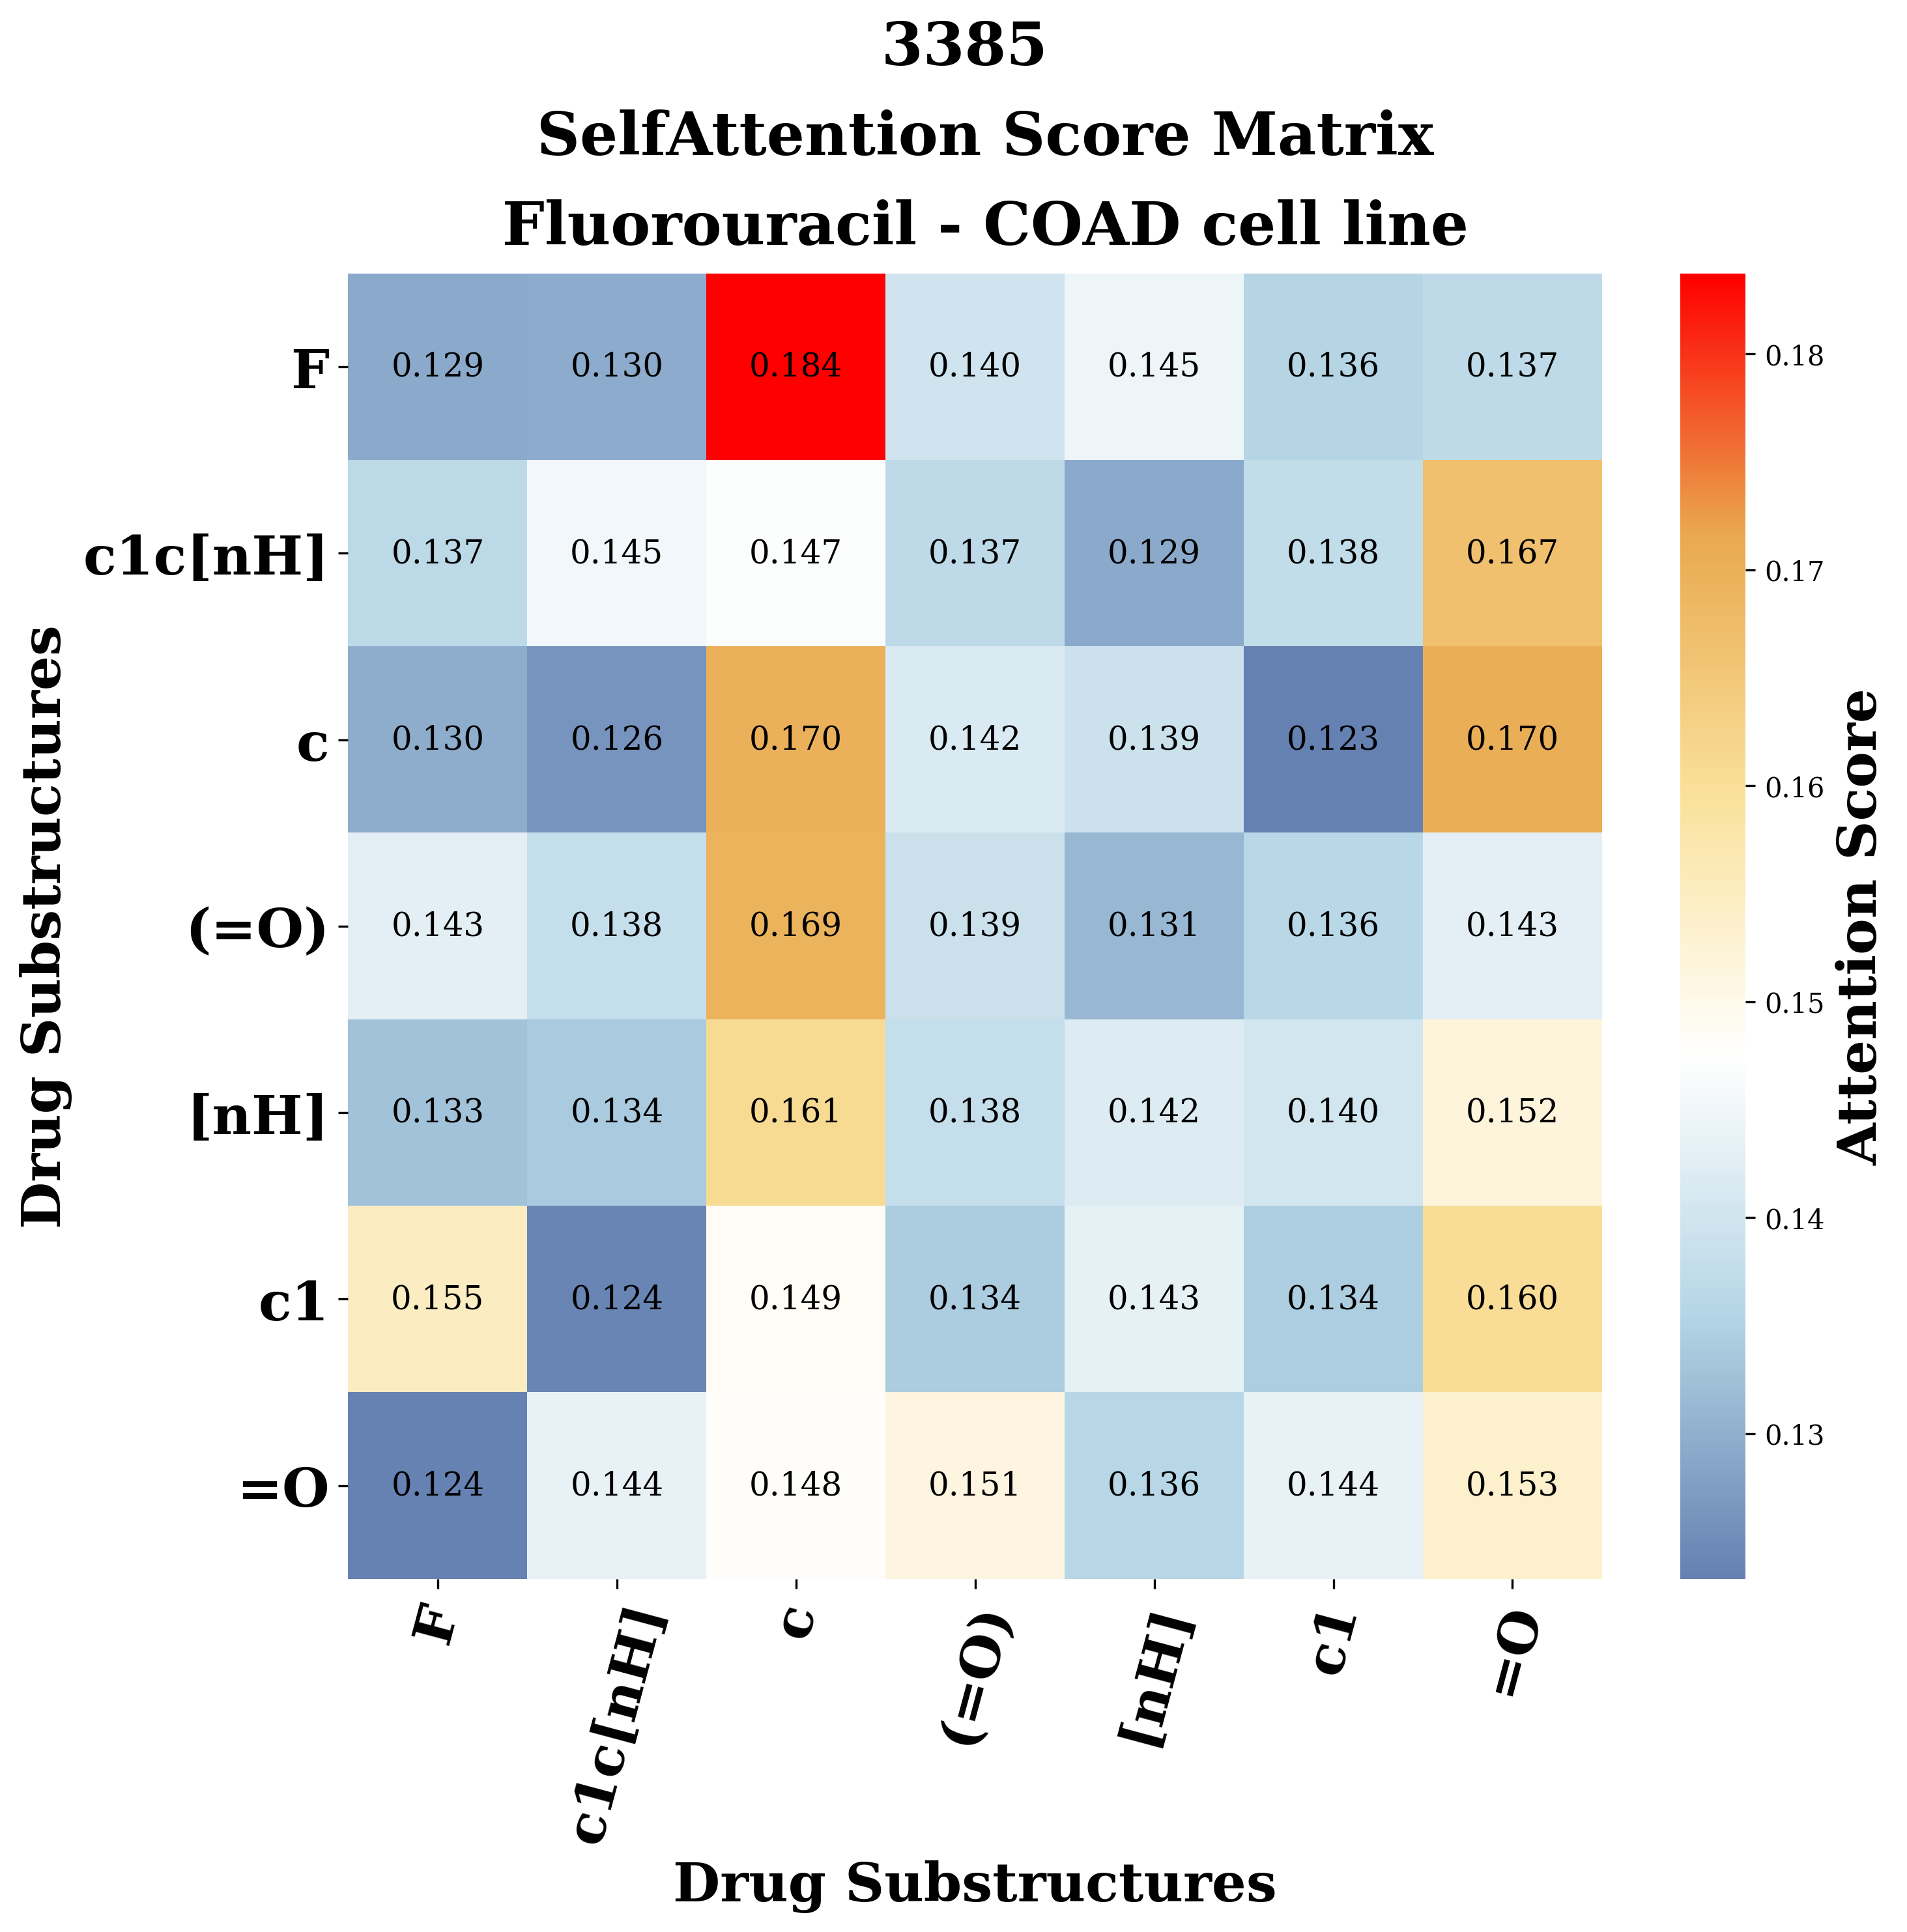

In [36]:
print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [37]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [2, 20] 
 score values: [0.18370944261550903, 0.17035652697086334]
max score matrix index pair: sub 1 , sub 3
max score matrix index pair y-axis: F
max score matrix index pair x-axis: c
sec_max score matrix index pair: sub 3 , sub 7
sec_max score matrix index pair y-axis: c
sec_max score matrix index pair x-axis: =O


torch.Size([8, 8])


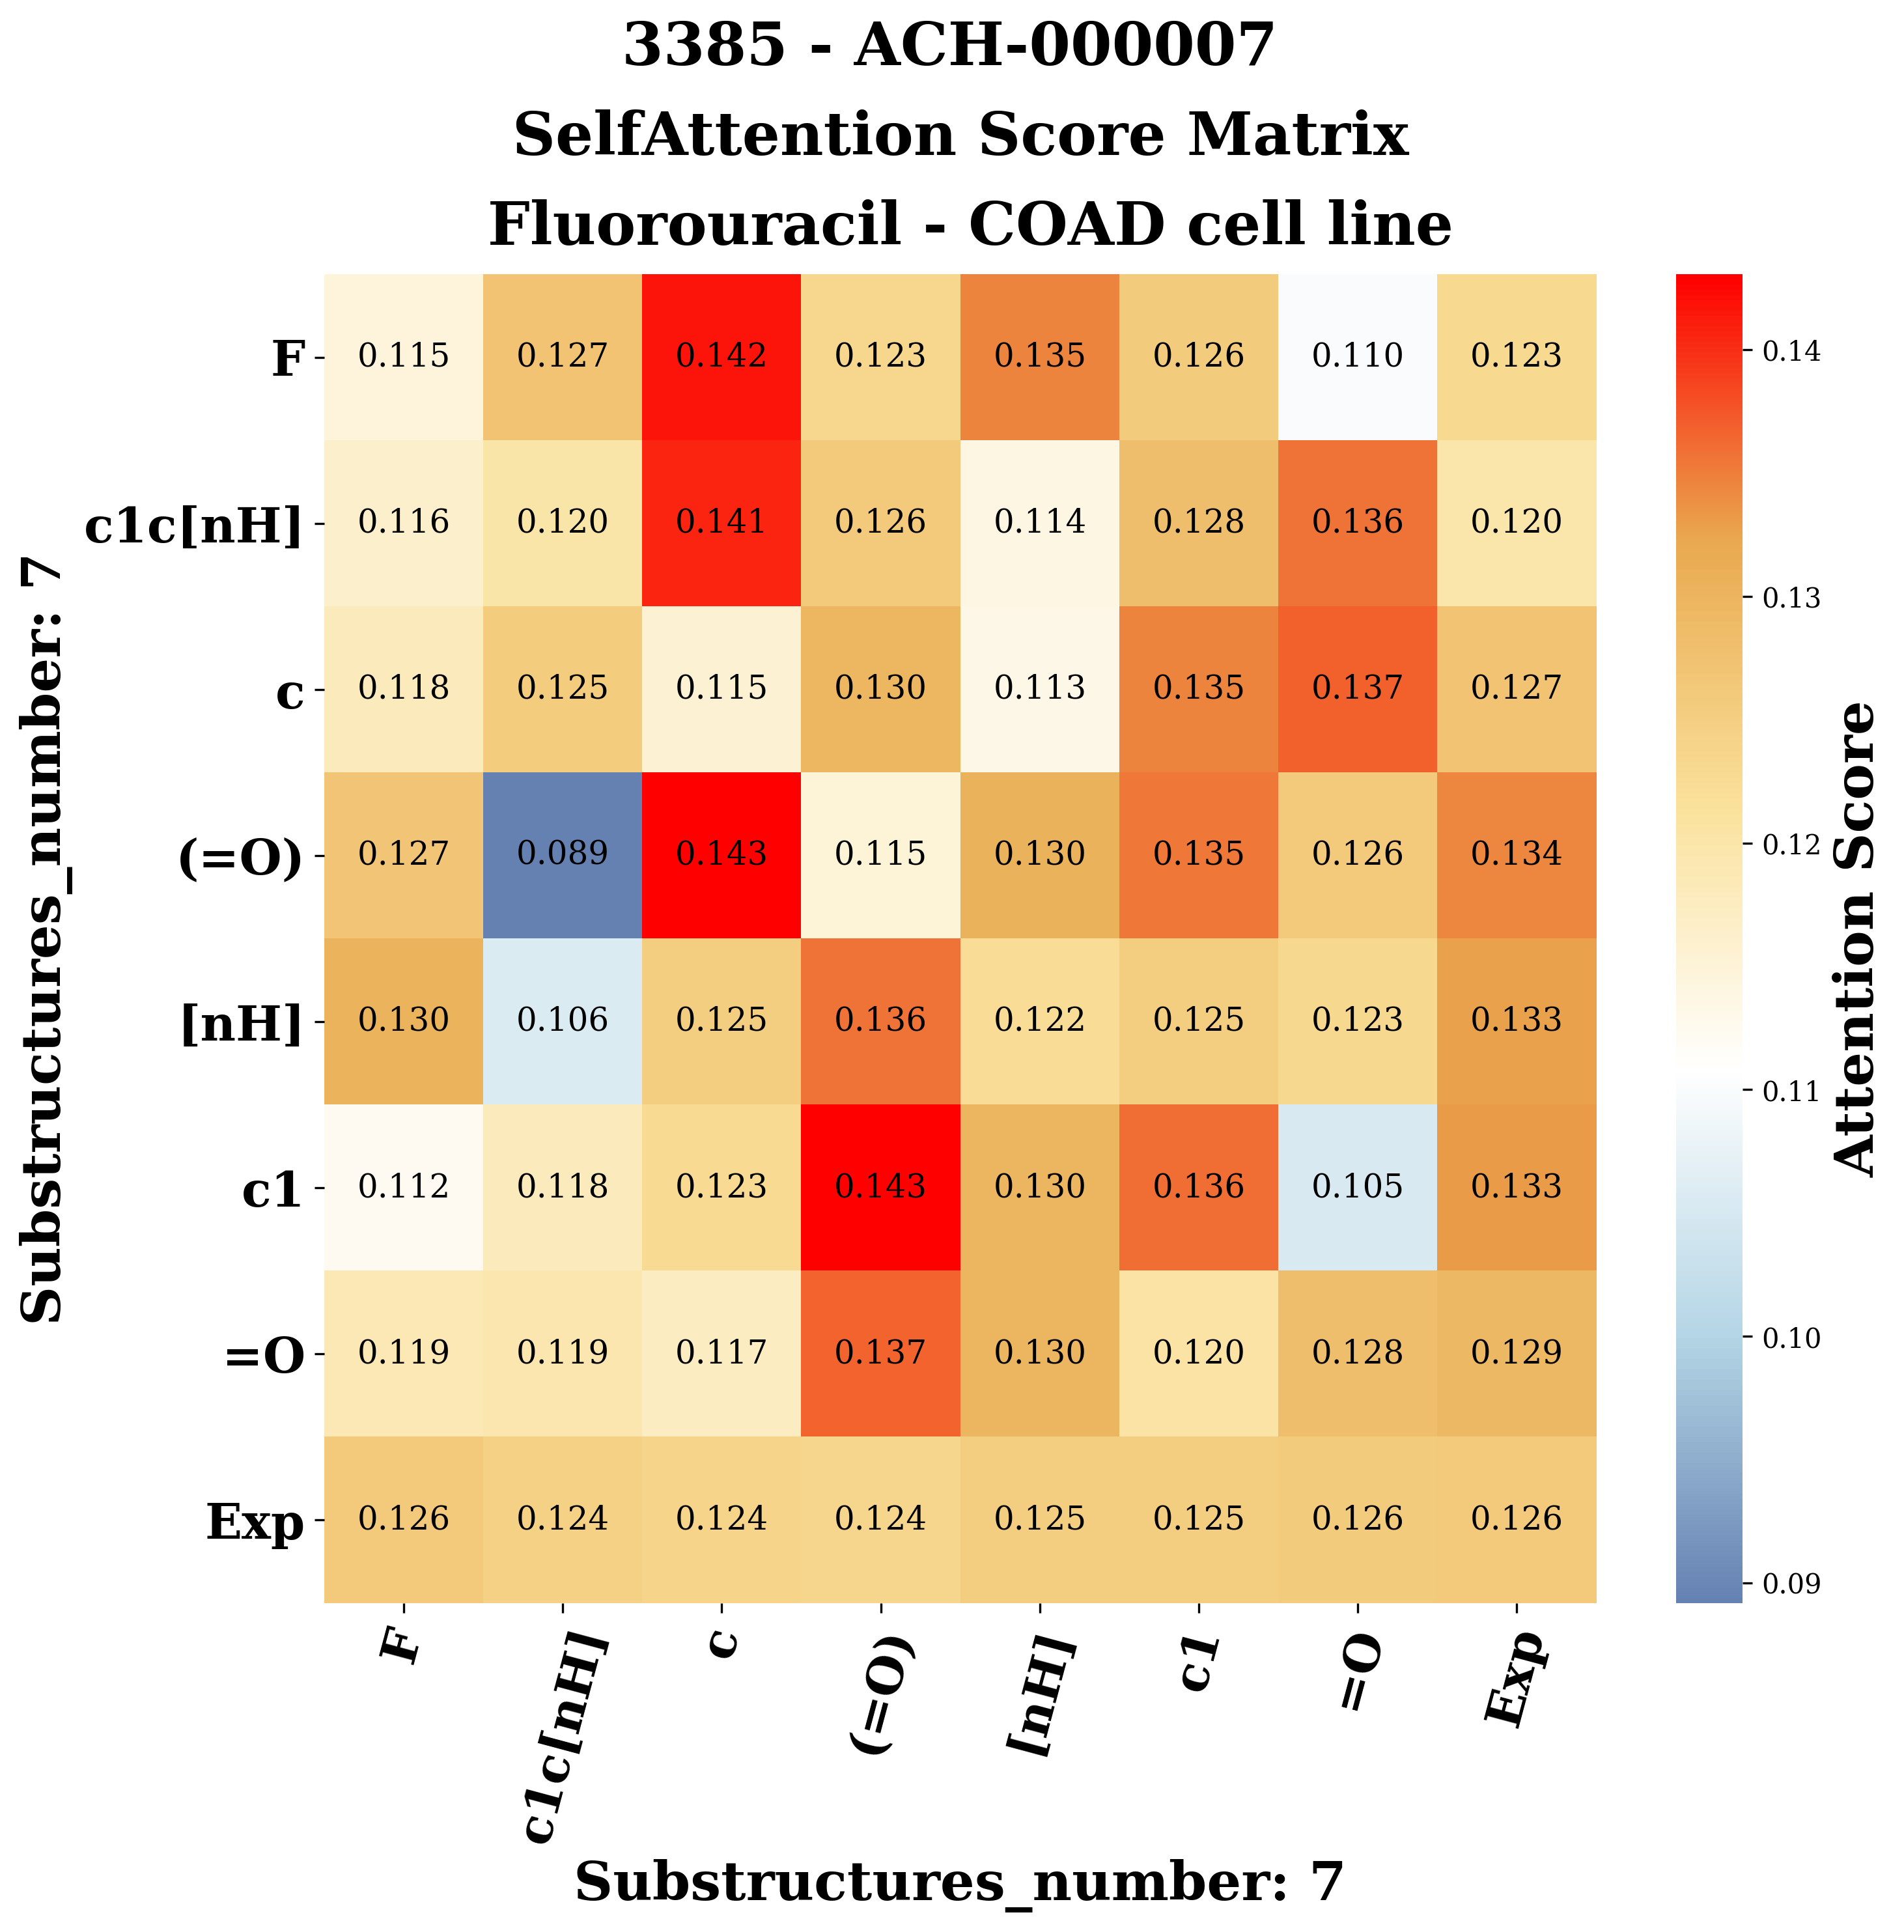

In [38]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [41]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_y] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [26, 43] 
 score values: [0.14306175708770752, 0.1429300606250763]
max score matrix index pair: sub 4 , sub 3
max score matrix index pair y-axis: (=O)
max score matrix index pair x-axis: c
sec_max score matrix index pair: sub 6 , sub 4
sec_max score matrix index pair y-axis: c1
sec_max score matrix index pair x-axis: c1


In [ ]:
def interpret_indices(y, x, drug_subunits, omics_names):
    len_drug = len(drug_subunits)
    if y >= len_drug and x >= len_drug:
        y_label = omics_names[y - len_drug]
        x_label = omics_names[x - len_drug]
    elif y >= len_drug:
        y_label = omics_names[y - len_drug]
        x_label = drug_subunits[x]
    elif x >= len_drug:
        y_label = drug_subunits[y]
        x_label = omics_names[x - len_drug]
    else:
        y_label = drug_subunits[y]
        x_label = drug_subunits[x]
    return y_label, x_label
# Flatten and sort
top3_vals, top3_indices = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)
top3_vals = top3_vals[:3]
top3_indices = top3_indices[:3]
print("Top 3 indices of flattened score matrix:", top3_indices.tolist())
print("Score values:", top3_vals.tolist())
# Get dimensions
n_cols = AttenScorMat_DrugCellSelf_dropnan.shape[1]
drug_subunits = drug_encode.values[0][2]
# Process top-1
y1, x1 = divmod(top3_indices[0].item(), n_cols)
label_y1, label_x1 = interpret_indices(y1, x1, drug_subunits, include_omics)
print(f"Max score index pair: sub{y1+1}, sub{x1+1}")
print("→ y-axis:", label_y1)
print("→ x-axis:", label_x1)
# Process top-2
y2, x2 = divmod(top3_indices[1].item(), n_cols)
label_y2, label_x2 = interpret_indices(y2, x2, drug_subunits, include_omics)
print(f"Second max score index pair: sub{y2+1}, sub{x2+1}")
print("→ y-axis:", label_y2)
print("→ x-axis:", label_x2)
# Process top-3
y3, x3 = divmod(top3_indices[2].item(), n_cols)
label_y3, label_x3 = interpret_indices(y3, x3, drug_subunits, include_omics)
print(f"Second max score index pair: sub{y3+1}, sub{x3+1}")
print("→ y-axis:", label_y3)
print("→ x-axis:", label_x3)

Top 3 indices of flattened score matrix: [35, 0, 1]
Score values: [0.18524563312530518, 0.16992023587226868, 0.16992023587226868]
Max score index pair: sub6, sub6
→ y-axis: Exp
→ x-axis: Exp
Second max score index pair: sub1, sub1
→ y-axis: C1
→ x-axis: C1
Second max score index pair: sub1, sub2
→ y-axis: C1
→ x-axis: =C(C(=O)


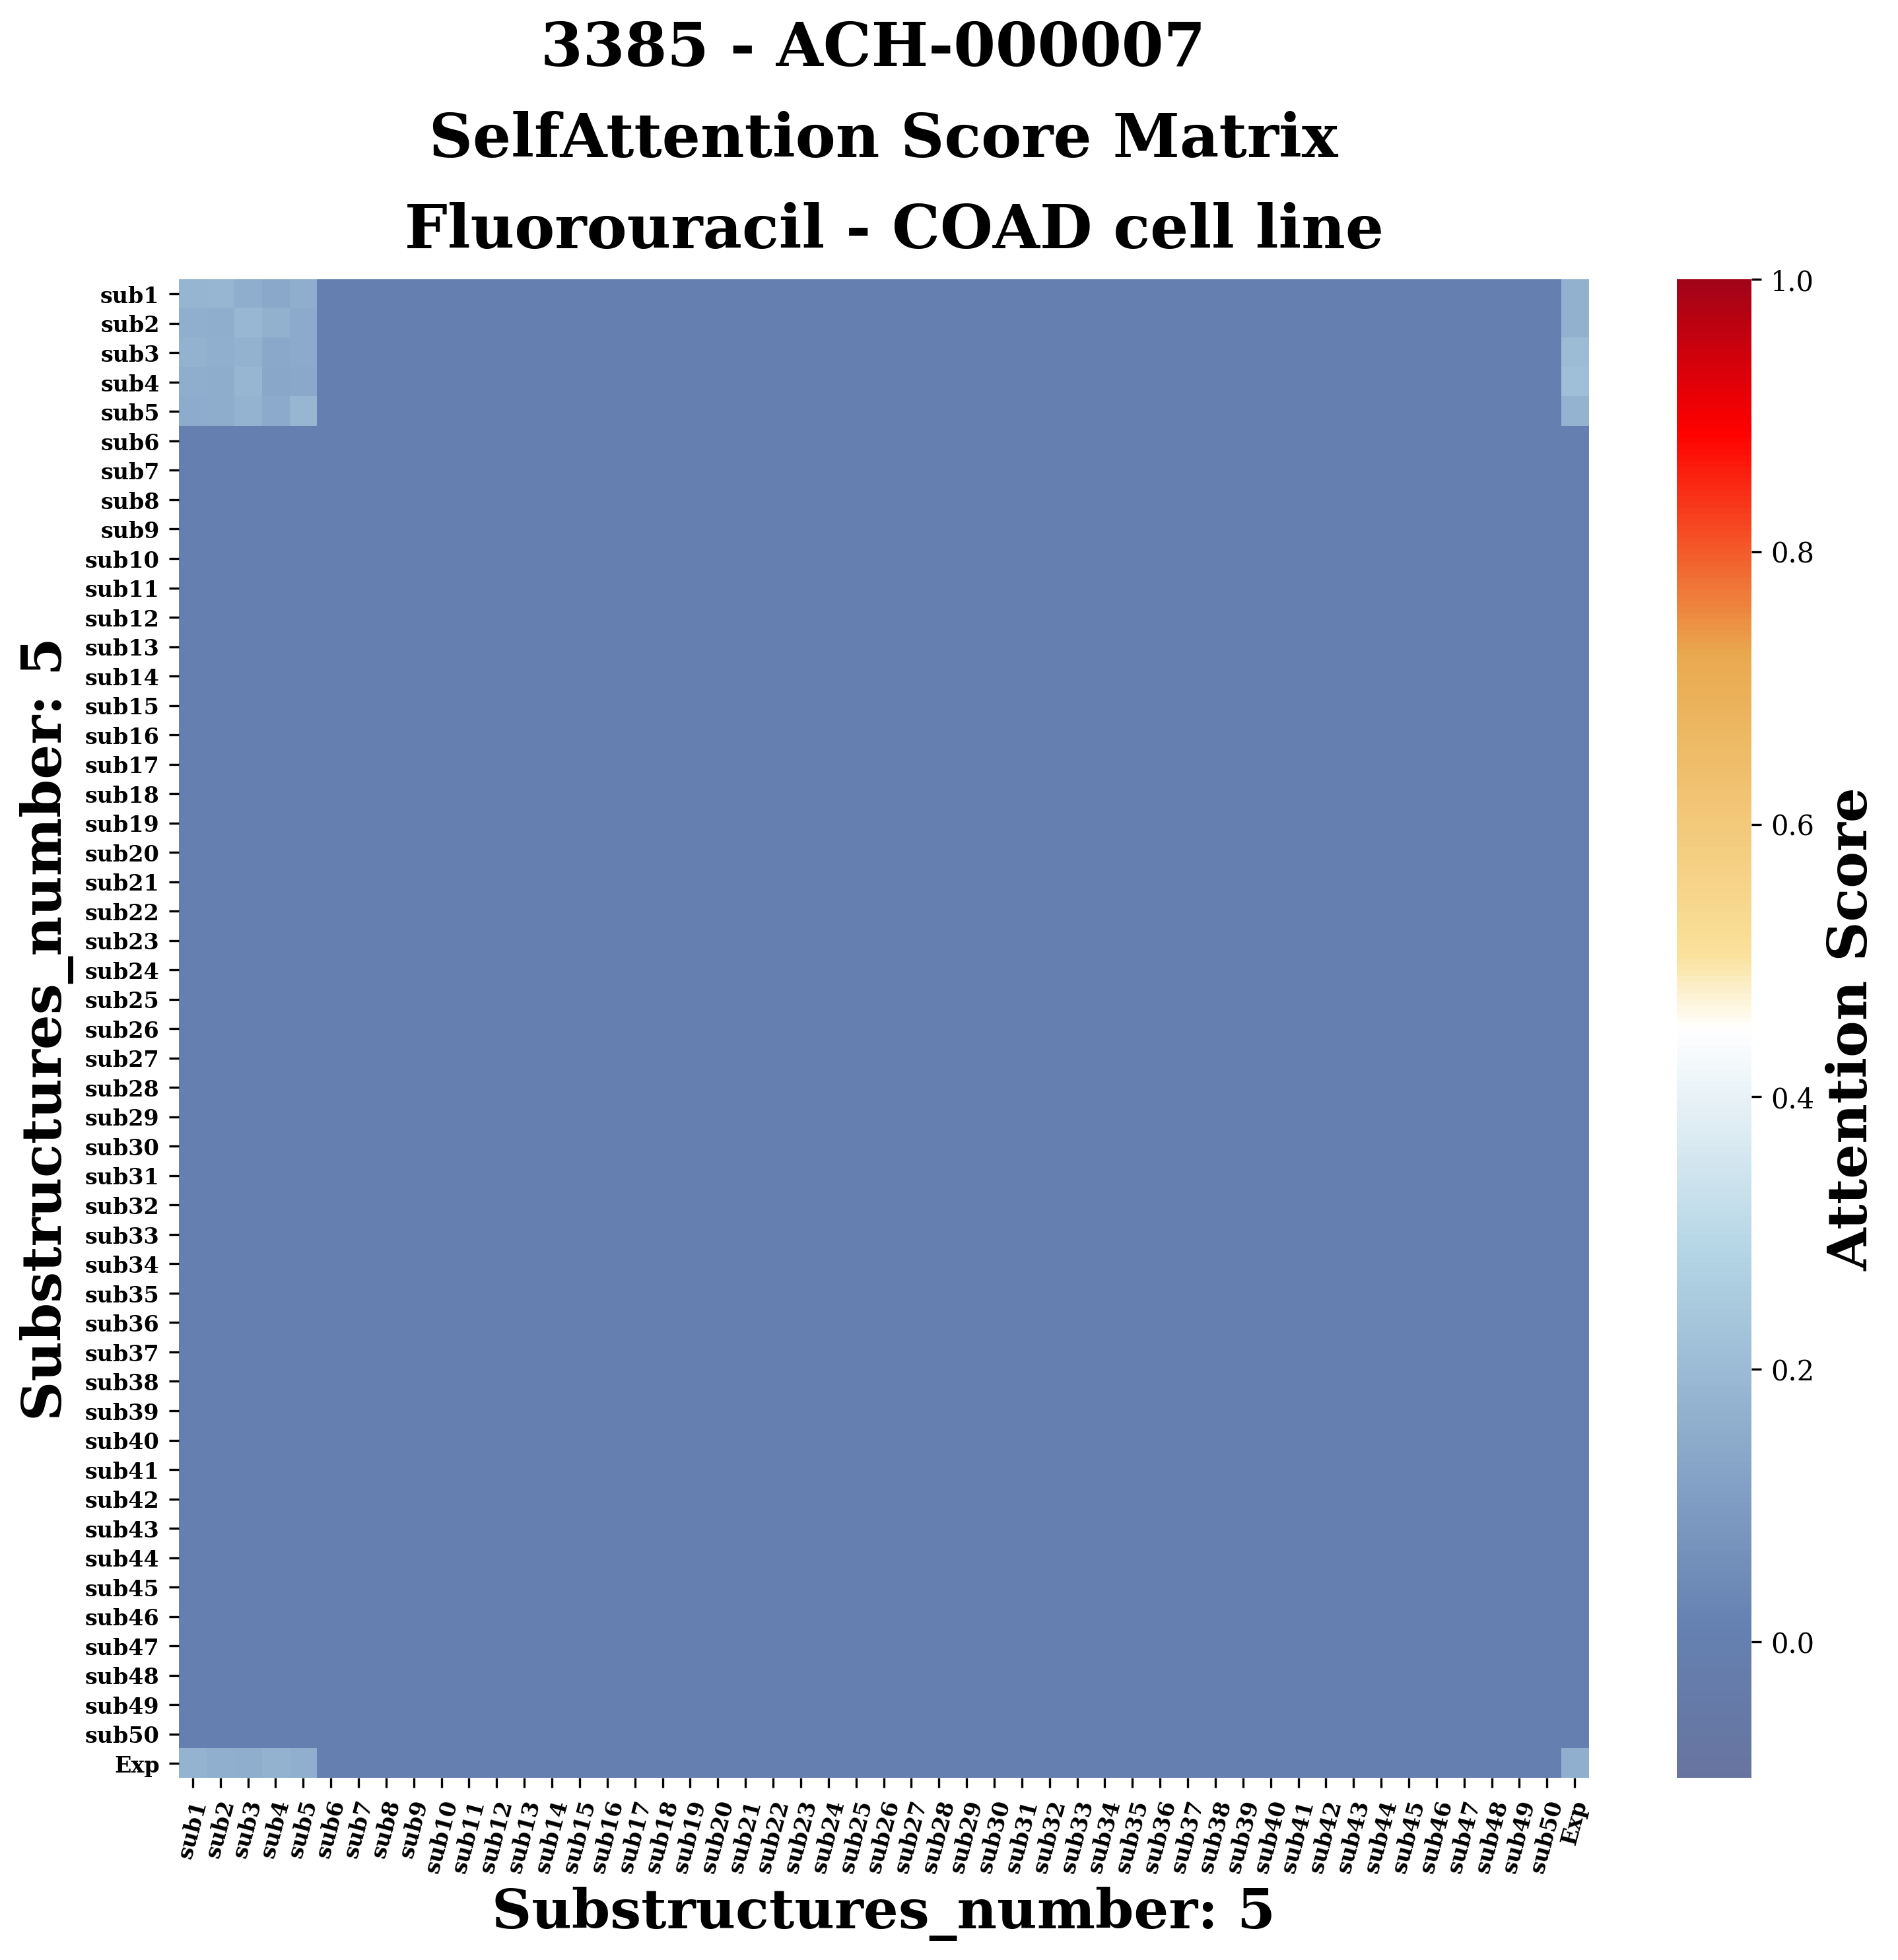

In [103]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

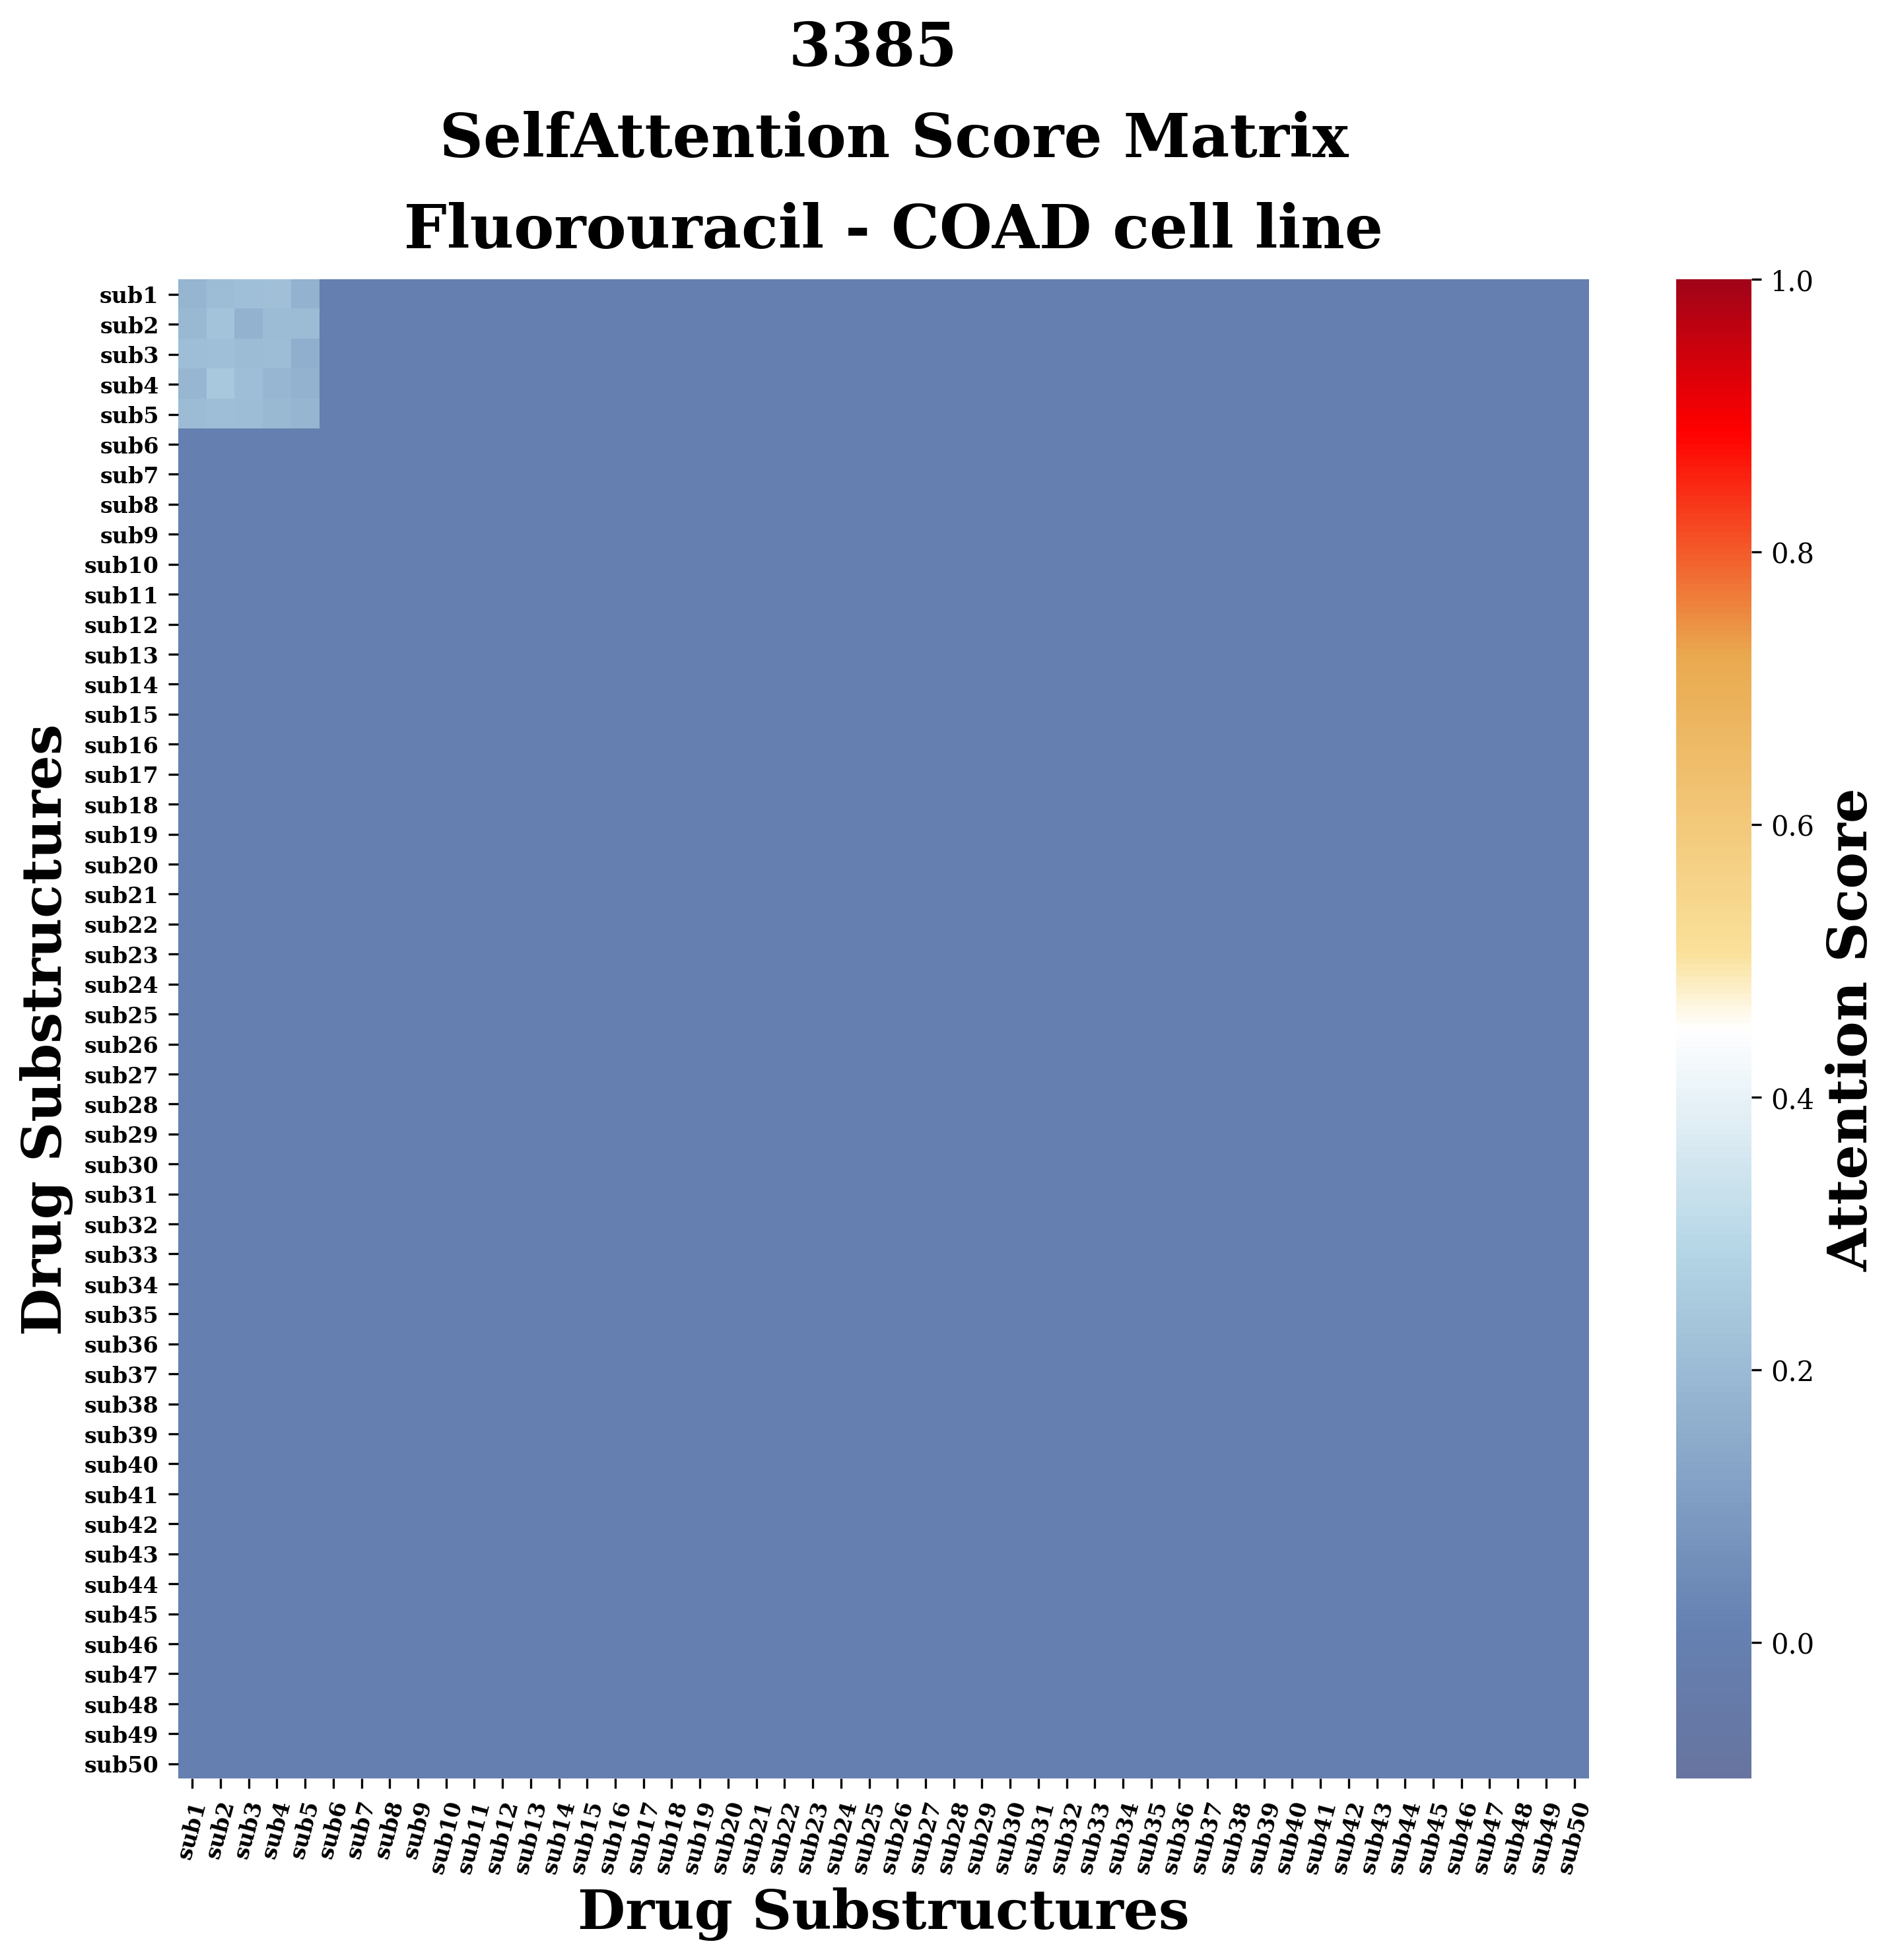

In [104]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )